# Cospectra with Variability

We have to understand the probability density functions for cospectra of light curves that contain variability. This notebook is aimed at testing our understanding with simulated data.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray import Lightcurve, Crossspectrum, Powerspectrum
from stingray.simulator.simulator import Simulator


/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/bispectrum.py:10: User

The light curve we create will have 10,000 data points and a time resolution of 0.1ms:

In [2]:
npoints = 10000
dt = 0.0001

Let's simulate a light curve with a power-law PSD with a spectral index of $\gamma = 2.5$, a fractional rms amplitude of $\mathrm{rms}_f = 0.2$ and a mean count rate of $\mu_\mathrm{cr}=10$ counts/bin

In [3]:
# set the random state for reproducibility
rng = np.random.RandomState(100)
sim = Simulator(dt=dt, N=npoints, mean=1000, rms=0.2, random_state=rng)

In [4]:
lc = sim.simulate(2.0)

/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/utils.py:126: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


What does our light curve look like?

In [5]:
np.mean(lc.countrate)

10000000.000000002

<IPython.core.display.Javascript object>


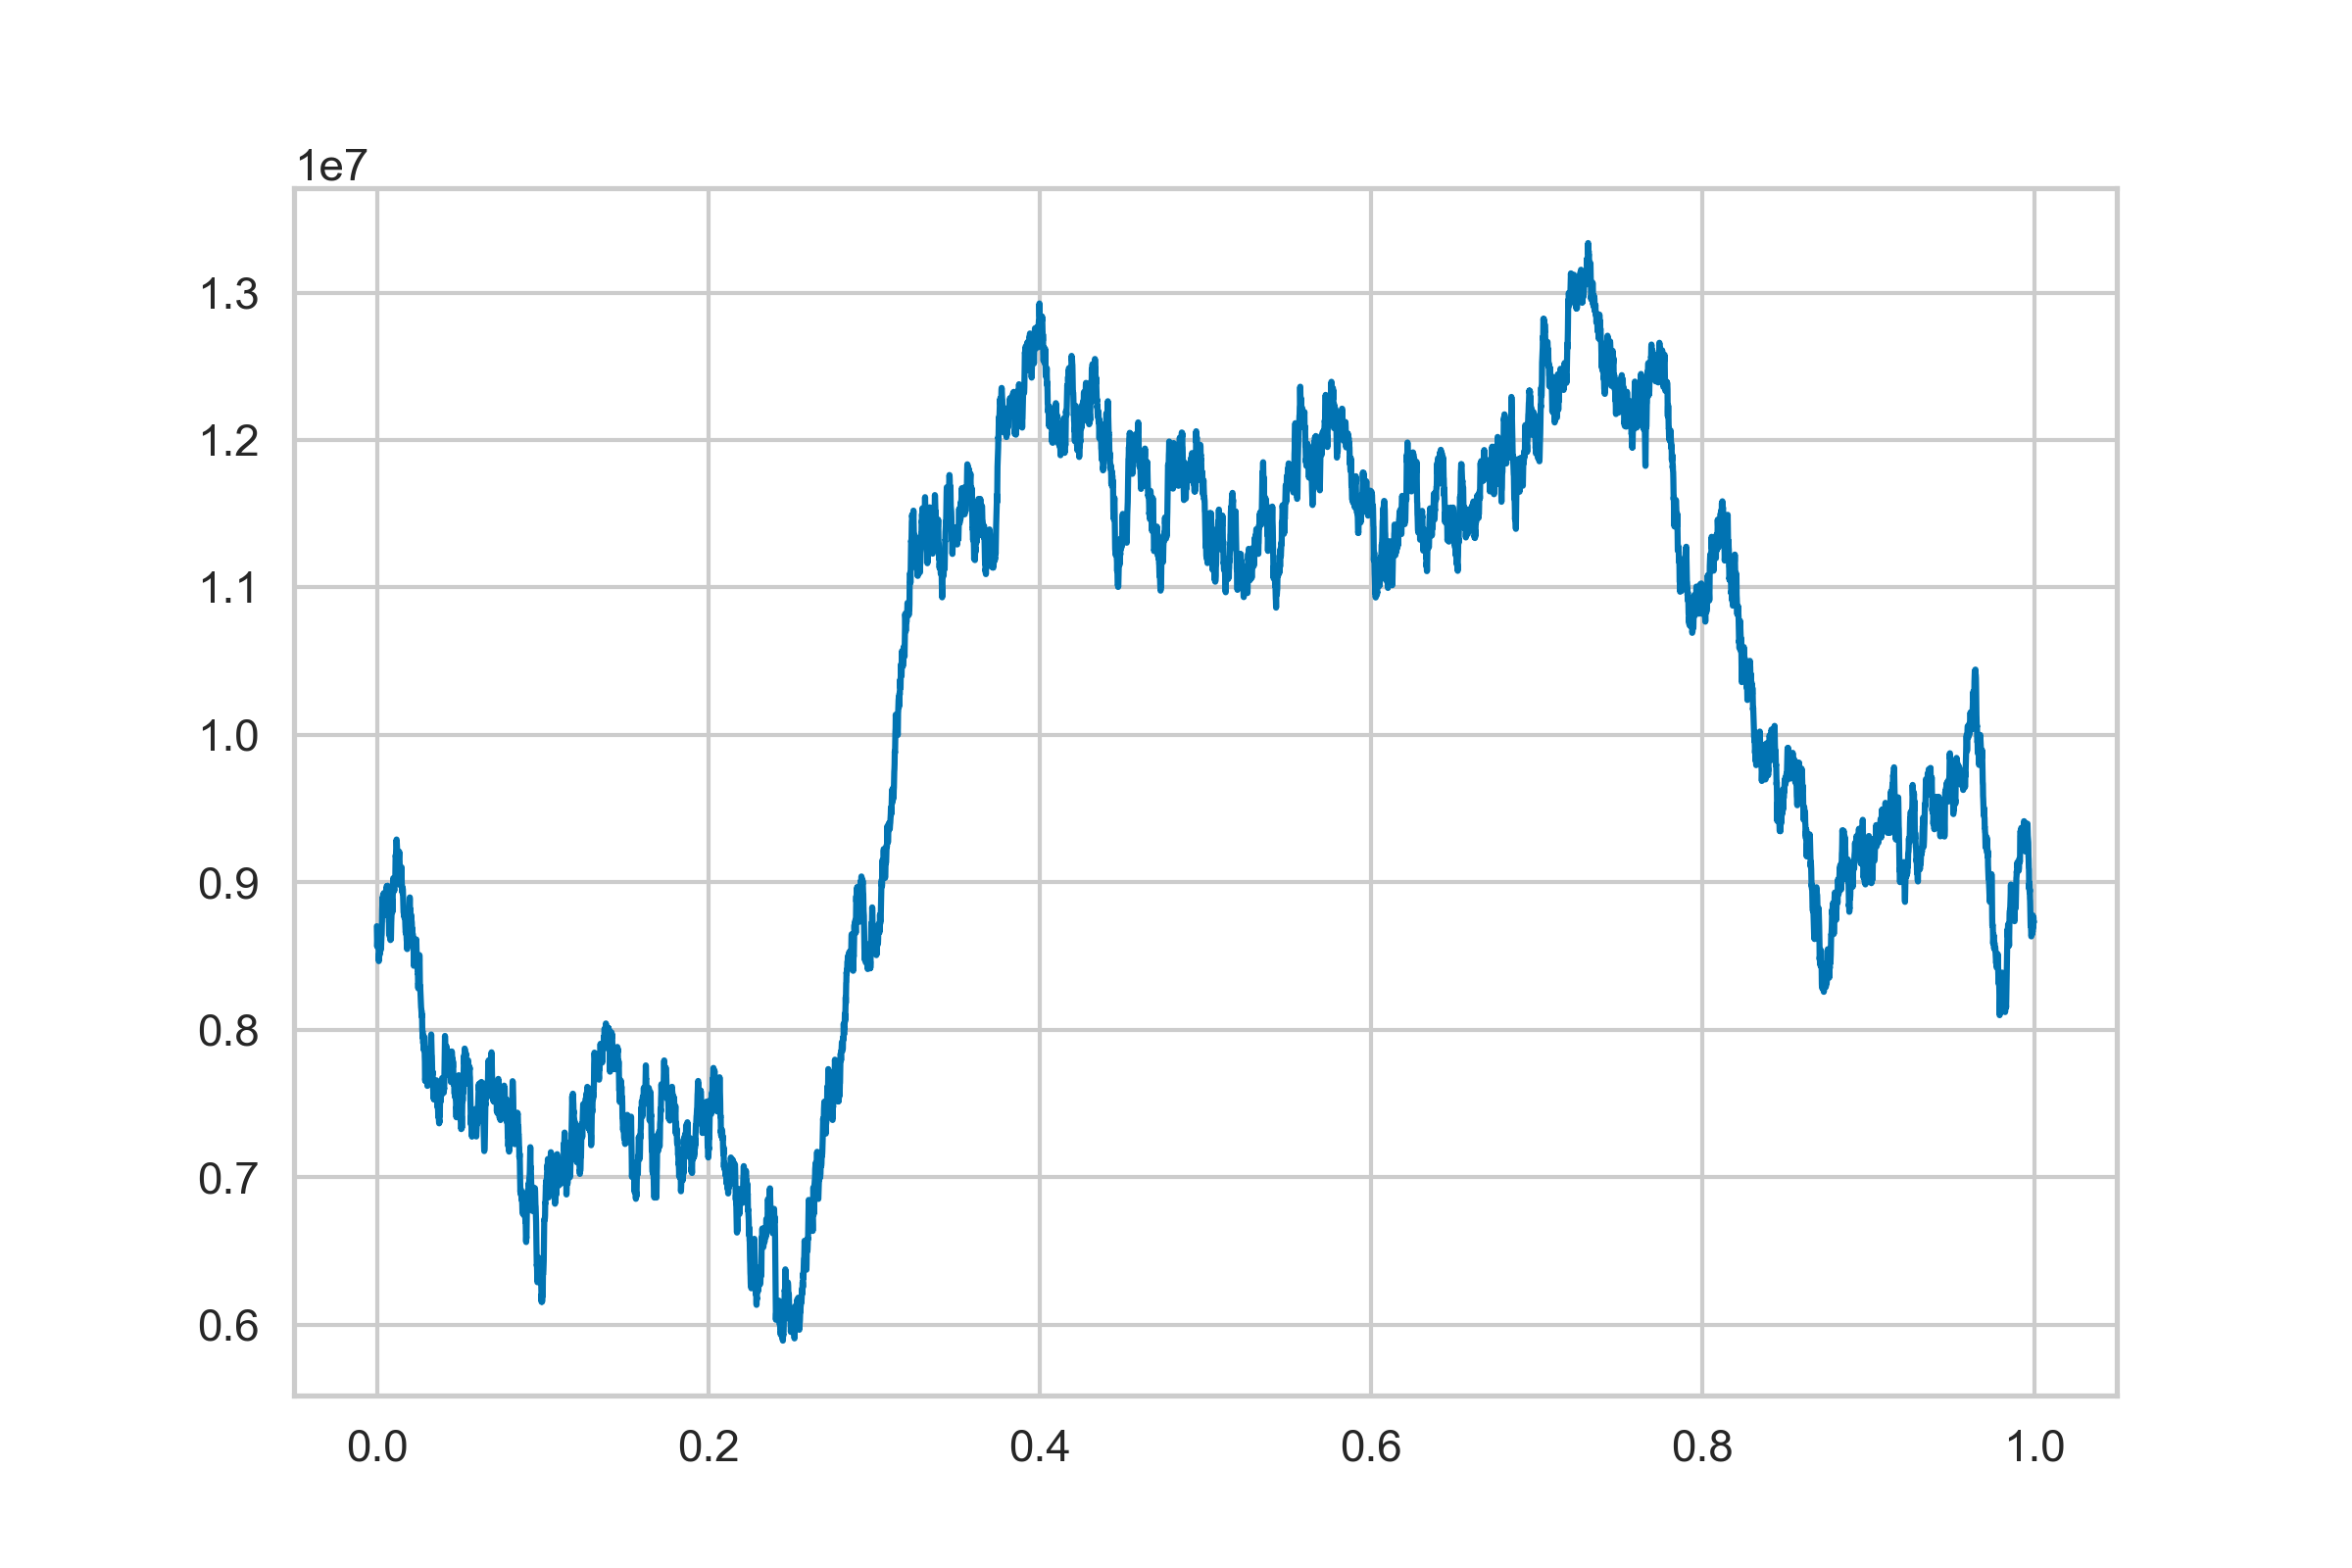

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(lc.time, lc.countrate)

Let's simulate from Poisson noise to make our two light curves for the cross spectrum:

In [7]:
counts1 = rng.poisson(lc.counts)
counts2 = rng.poisson(lc.counts)

lc1 = Lightcurve(lc.time, counts1, dt=dt, skip_checks=True)
lc2 = Lightcurve(lc.time, counts2, dt=dt, skip_checks=True)

<IPython.core.display.Javascript object>


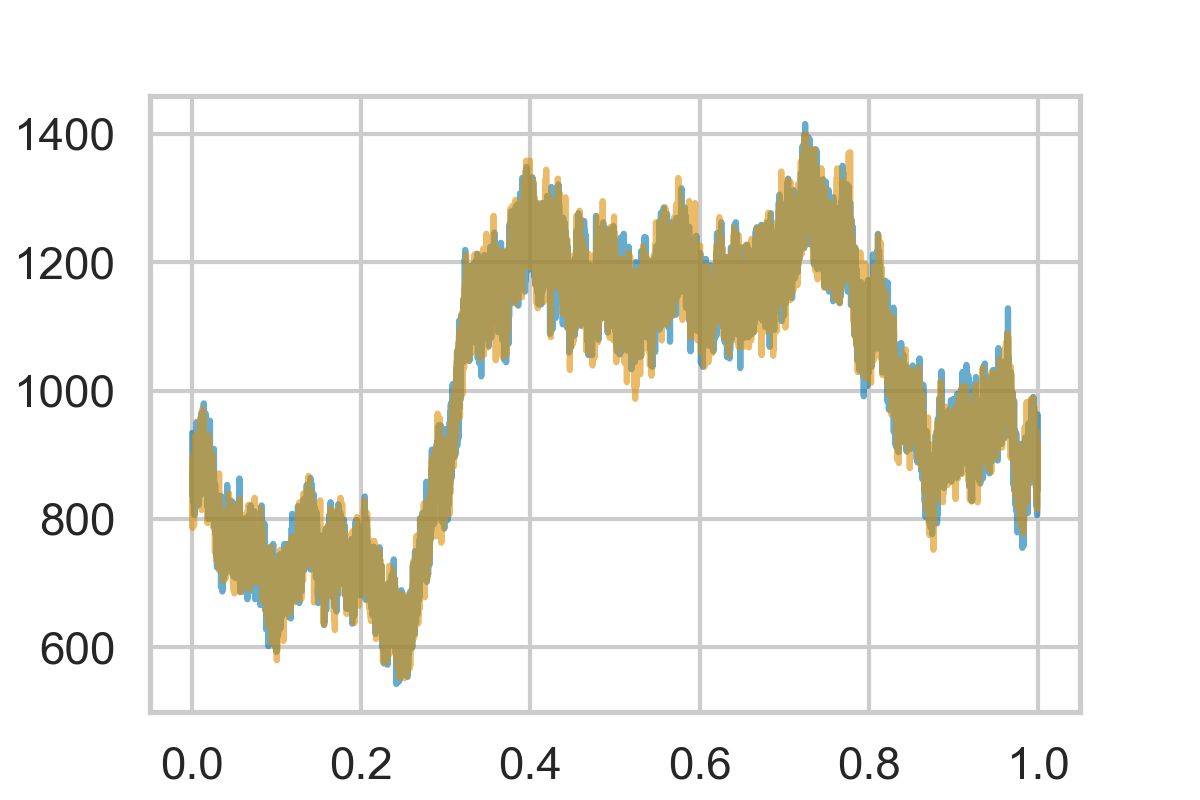

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(lc1.time, lc1.counts, alpha=0.6)
ax.plot(lc2.time, lc2.counts, alpha=0.6)


Okay, cool. Let's make the cross spectrum by hand so that we can look at each of the steps.

In [9]:
fourier1 = scipy.fftpack.fft(lc1.counts)
fourier2 = scipy.fftpack.fft(lc2.counts)

freqs = scipy.fftpack.fftfreq(npoints, lc1.dt)

fourier1 = fourier1[freqs>0]
fourier2 = fourier2[freqs>0]

freqs = freqs[freqs > 0]

In [10]:
csd_real = fourier1.real * fourier2.real
csd_imag = fourier1.imag * fourier2.imag

csd = csd_real + csd_imag

Let's plot the two Fourier components:

<IPython.core.display.Javascript object>


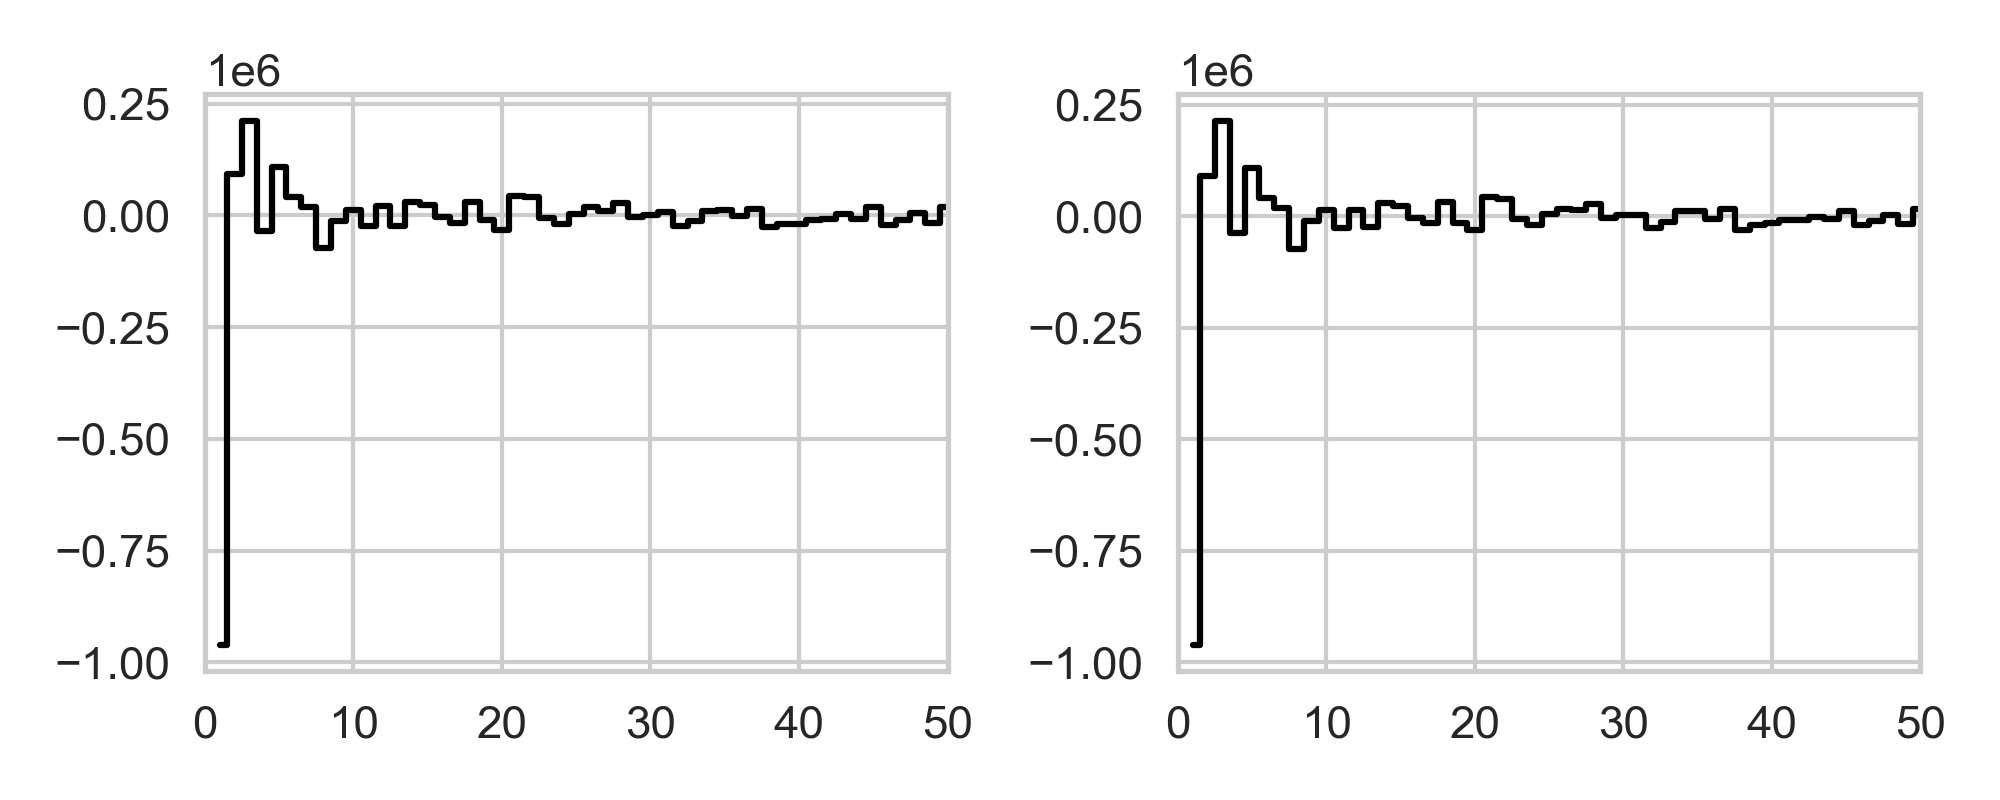

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(freqs, fourier1.real, ds="steps-mid", color="black")
ax2.plot(freqs, fourier2.real, ds="steps-mid", color="black")
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)
plt.tight_layout()

<IPython.core.display.Javascript object>


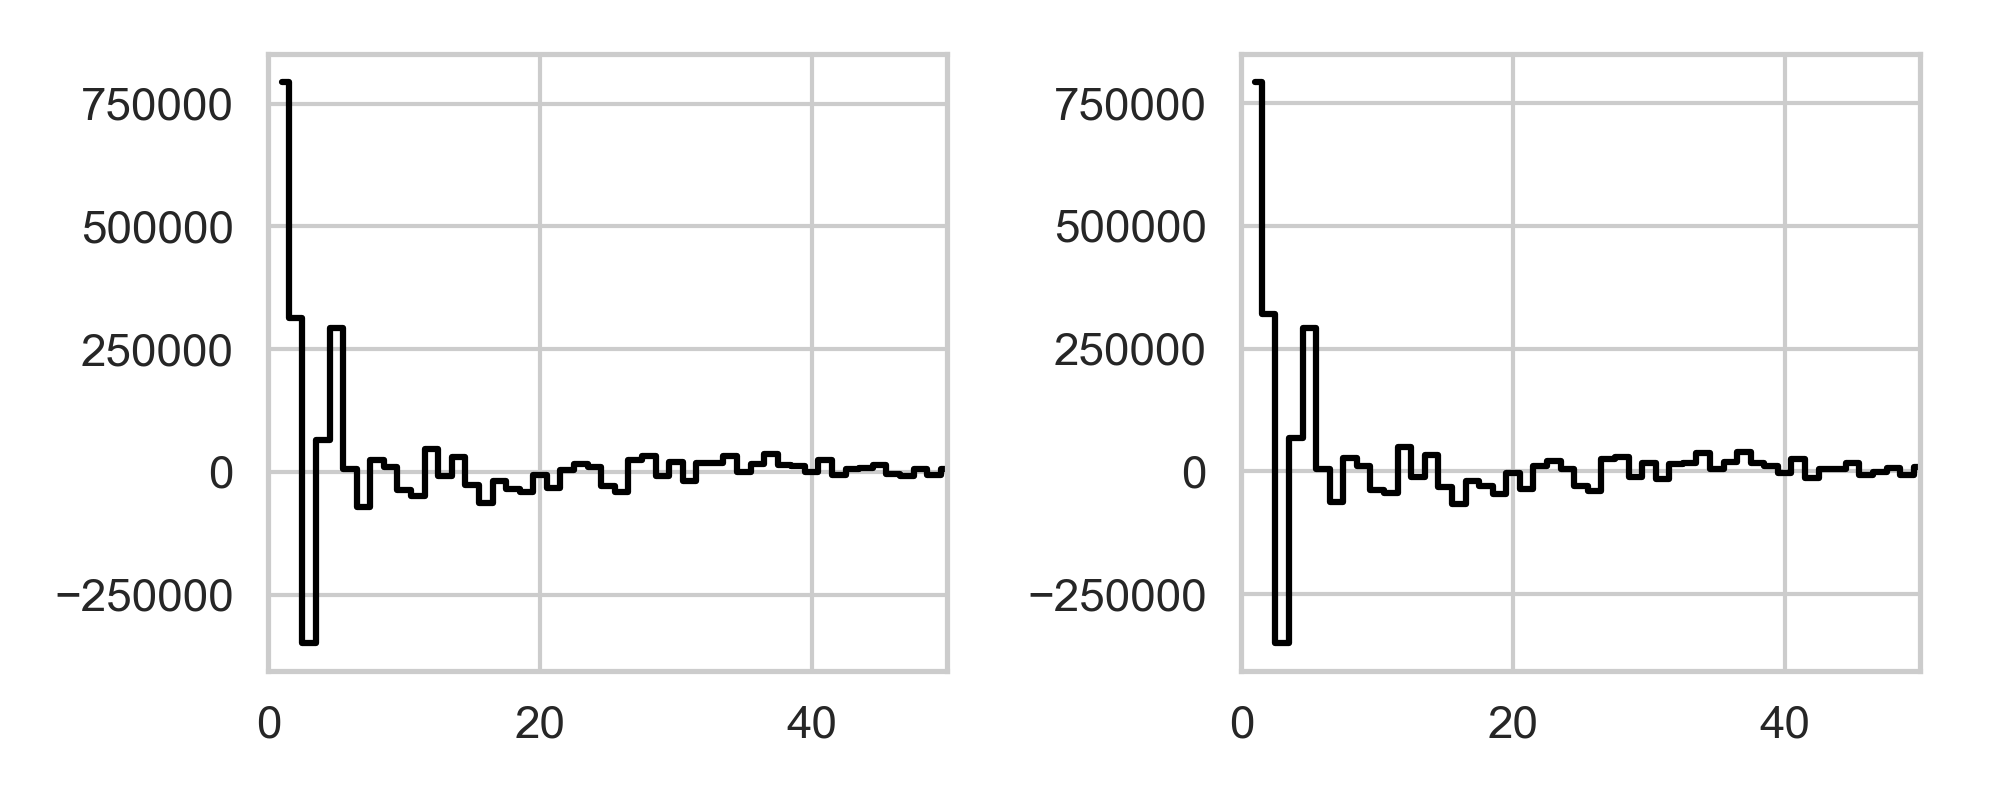

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(freqs, fourier1.imag, ds="steps-mid", color="black")
ax2.plot(freqs, fourier2.imag, ds="steps-mid", color="black")
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)
plt.tight_layout()

Okay, cool. We kind of want to know what the statistical distribution in the red noise part is, so let's simulate a whole lot of red noise light curves and build the distributions for each bin.

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
from tqdm import tqdm

In [15]:
npoints = 10000
dt = 0.0001
rng = np.random.RandomState(100)
sim = Simulator(dt=dt, N=npoints, mean=100, rms=0.2, random_state=rng)

nsim = 5000

fourier1_all, fourier2_all, csd_all, csd_normed_all = [], [], [], []
lc1_counts_all, lc2_counts_all = [], []
lc1_all, lc2_all = [], []
ps1_all, ps2_all = [], []

for i in tqdm(range(nsim)):
    #print(i)
    lc = sim.simulate(2)
    
    try:
        counts1 = rng.poisson(lc.counts)
        counts2 = rng.poisson(lc.counts)
    except ValueError:
        continue
        
    lc1 = Lightcurve(lc.time, counts1, dt=dt, skip_checks=True)
    lc2 = Lightcurve(lc.time, counts2, dt=dt, skip_checks=True)
    
    lc1_counts_all.append(np.sum(lc1.counts))
    lc2_counts_all.append(np.sum(lc2.counts))
    
    lc1_all.append(lc1)
    lc2_all.append(lc2)
    
    fourier1 = scipy.fftpack.fft(lc1.counts)
    fourier2 = scipy.fftpack.fft(lc2.counts)

    freqs = scipy.fftpack.fftfreq(npoints, lc1.dt)

    fourier1 = fourier1[freqs>0]
    fourier2 = fourier2[freqs>0]

    freqs = freqs[freqs > 0]
    
    csd_real = fourier1.real * fourier2.real
    csd_imag = fourier1.imag * fourier2.imag

    csd = csd_real + csd_imag
    
    mean_nphot = np.sqrt(np.sum(lc1.counts)*np.sum(lc2.counts))

    ps1 = Powerspectrum(lc1, norm="leahy")
    ps2 = Powerspectrum(lc2, norm="leahy")
    
    ps1_all.append(ps1)
    ps2_all.append(ps2)
    fourier1_all.append(fourier1[:1500])
    fourier2_all.append(fourier2[:1500])
    csd_all.append(csd[:1500])
    csd_normed_all.append(2.*csd[:1500]/mean_nphot)


100%|██████████| 5000/5000 [00:48<00:00, 102.19it/s]


In [16]:
fourier1_all = np.array(fourier1_all)
fourier2_all = np.array(fourier2_all)
csd_all = np.array(csd_all)
lc1_counts_all = np.array(lc1_counts_all)
lc2_counts_all = np.array(lc2_counts_all)

Let's make an averaged periodogram so we can estimate what the power spectrum looks like:

In [17]:
from stingray import AveragedPowerspectrum

In [18]:
avg_ps1 = AveragedPowerspectrum(lc1_all, segment_size=lc1_all[0].tseg, norm="leahy")

5000it [00:07, 669.20it/s]


In [19]:
from astropy.modeling import models

In [20]:
m = models.PowerLaw1D() + models.Const1D()
m.x_0_0.fixed=True

In [21]:
from stingray.modeling import PSDLogLikelihood, PSDParEst

In [22]:
loglike = PSDLogLikelihood(avg_ps1.freq, avg_ps1.power, model=m, m=avg_ps1.m)

In [23]:
parest = PSDParEst(avg_ps1, max_post=False)

In [24]:
res = parest.fit(loglike, [3.24e4, 2, 2])

In [25]:
res.p_opt

array([3.24078099e+04, 1.98548412e+00, 1.99834467e+00])

In [26]:
m.amplitude_0 = res.p_opt[0]
m.alpha_0 = res.p_opt[1]
m.amplitude_1 = res.p_opt[2]

In [27]:
mps = m(avg_ps1.freq)

<IPython.core.display.Javascript object>


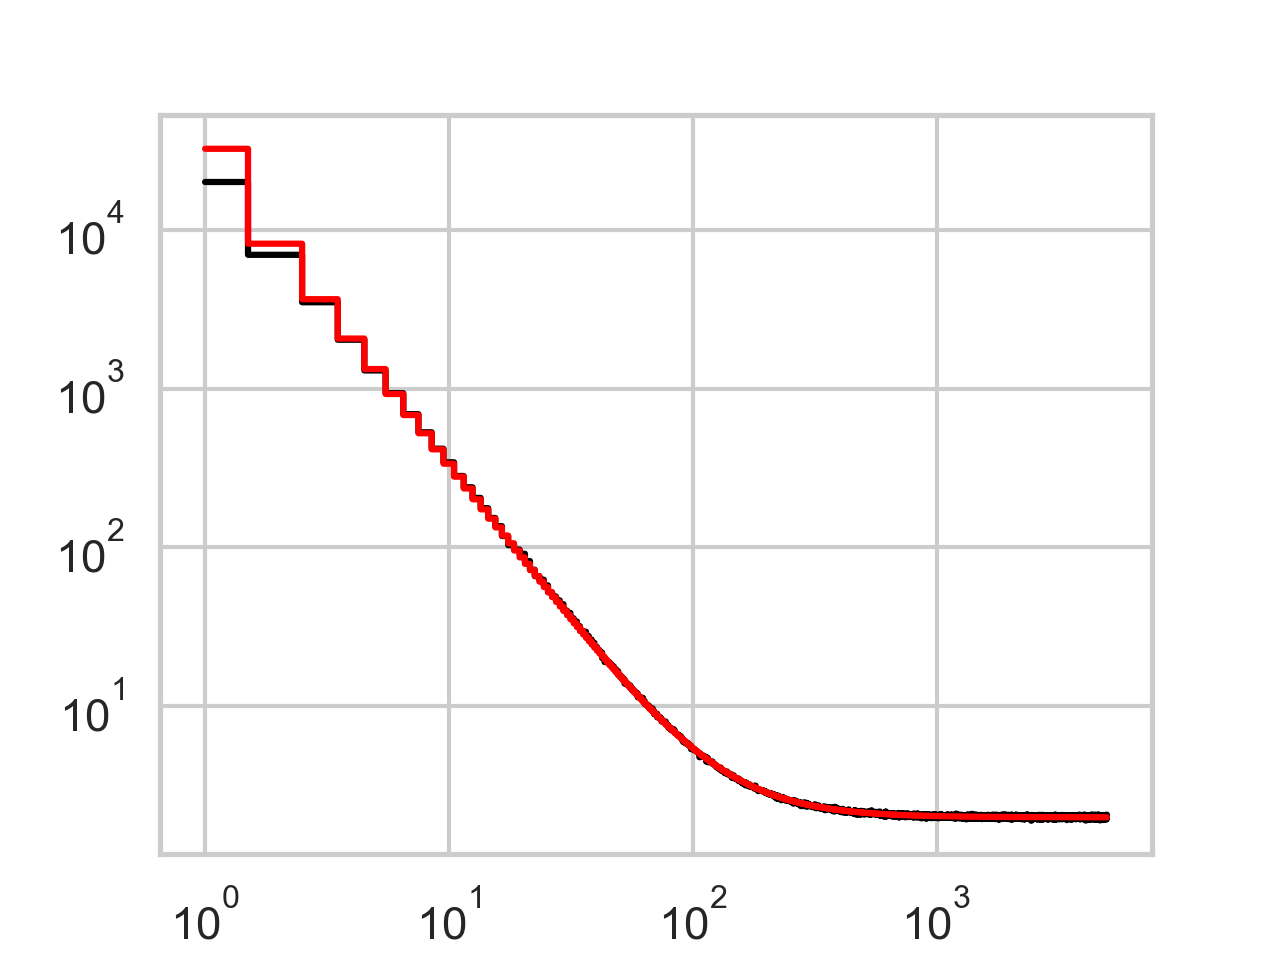

In [28]:
plt.figure()
plt.loglog(avg_ps1.freq, avg_ps1.power, ds="steps-mid", color="black")
plt.loglog(avg_ps1.freq, mps, ds="steps-mid", color="red")

In [29]:
fourier1_all.shape

(5000, 1500)

In [30]:
len(fourier1_all[:,0])

5000

<IPython.core.display.Javascript object>


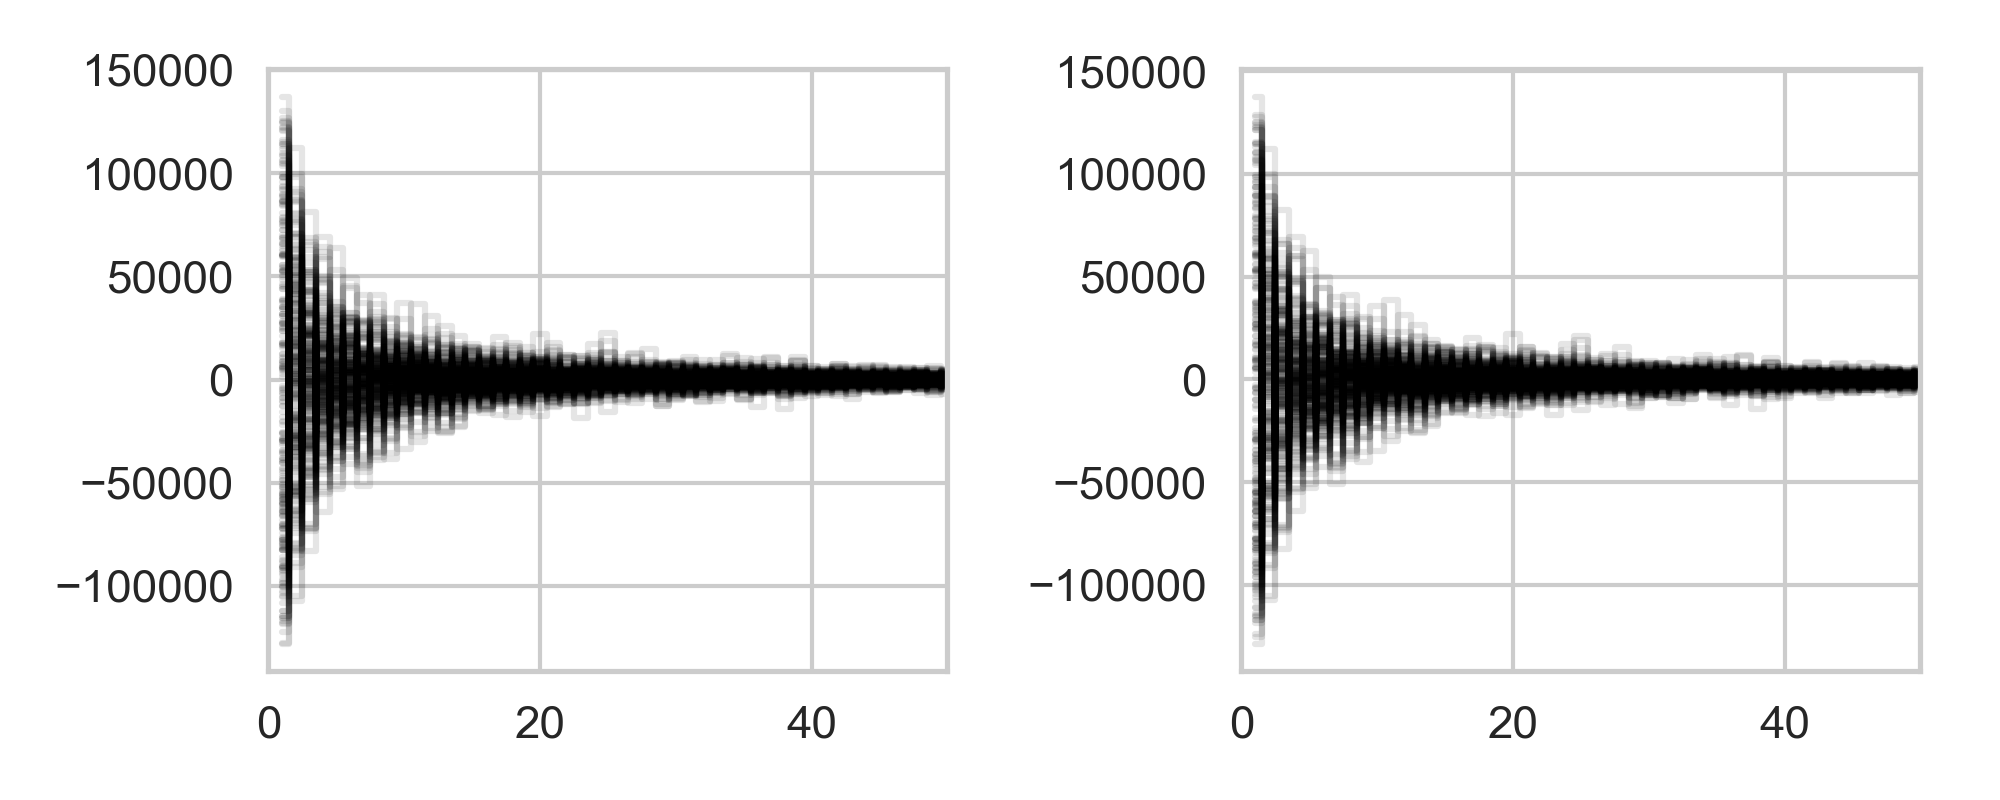

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

for f1, f2 in zip(fourier1_all[:300], fourier2_all[:300]):
    ax1.plot(freqs[:1500], f1.real, ds="steps-mid", color="black", alpha=0.1)
    ax2.plot(freqs[:1500], f2.real, ds="steps-mid", color="black", alpha=0.1)
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)
plt.tight_layout()

In [32]:
fourier1_all[:,10].shape

(5000,)

In [33]:
for i in range(50):
    f = fourier1_all[:,i]
    print("shape: " + str(f.shape))
    print("mean: " + str(np.mean(f.real)))
    var_data = np.var(f.real)
    var_model = mps[i]/4.0*np.mean(lc1_counts_all)
    print("std: " + str(var_data))
    print("model value: " + str(mps[i]))
    print("var(model): " + str(var_model))
    print("ratio: " + str(var_data/var_model))
    print("\n")

shape: (5000,)
mean: 1411.2119207269686
std: 4998328089.689586
model value: 32409.808259352838
var(model): 8102601057.588248
ratio: 0.616879450705345


shape: (5000,)
mean: 406.05826584651976
std: 1775884717.7261746
model value: 8185.881238370718
var(model): 2046507941.3166144
ratio: 0.8677634138979519


shape: (5000,)
mean: -379.34283946764236
std: 863434177.1181087
model value: 3660.7506358535356
var(model): 915204487.9831694
ratio: 0.9434330670961343


shape: (5000,)
mean: 137.20814156276845
std: 500999806.6514265
model value: 2068.6588007183286
var(model): 517174210.11438787
ratio: 0.9687254253080718


shape: (5000,)
mean: -482.08593135430726
std: 322280621.32260627
model value: 1328.9522519336092
var(model): 332244172.3762473
ratio: 0.9700113594698122


shape: (5000,)
mean: -319.01339482754065
std: 236401974.6045253
model value: 925.9361351881341
var(model): 231488290.4643374
ratio: 1.0212264911124949


shape: (5000,)
mean: 219.995238413329
std: 173931680.0490328
model value: 682.

Okay, it looks like mean of my distributions is still zero, but the width changes as a function of frequency.

Let's plot some of those distributions:


In [34]:
#norm1 = scipy.stats.norm(0, 85*np.sqrt(np.sum(lc1.counts))/2)
#norm2 = scipy.stats.norm(0, 30*np.sqrt(np.sum(lc1.counts))/2)
#norm3 = scipy.stats.norm(0, 1.5*np.sqrt(np.sum(lc1.counts))/2)

norm1 = scipy.stats.norm(0, np.sqrt(mps[1]/4.0*np.mean(lc1_counts_all)))
norm2 = scipy.stats.norm(0, np.sqrt(mps[10]/4.0*np.mean(lc1_counts_all)))
norm3 = scipy.stats.norm(0, np.sqrt(mps[1000]/4.0*np.mean(lc1_counts_all)))

u = np.linspace(-150000, 150000, 100000)
prob_norm1 = norm1.pdf(u)
prob_norm2 = norm2.pdf(u)
prob_norm3 = norm3.pdf(u)

In [35]:
print(np.sqrt(mps[1]))
print(np.sqrt(mps[5]))
print(np.sqrt(mps[499]))

90.4758599758561
30.42919872734302
1.4629469225242198


<IPython.core.display.Javascript object>


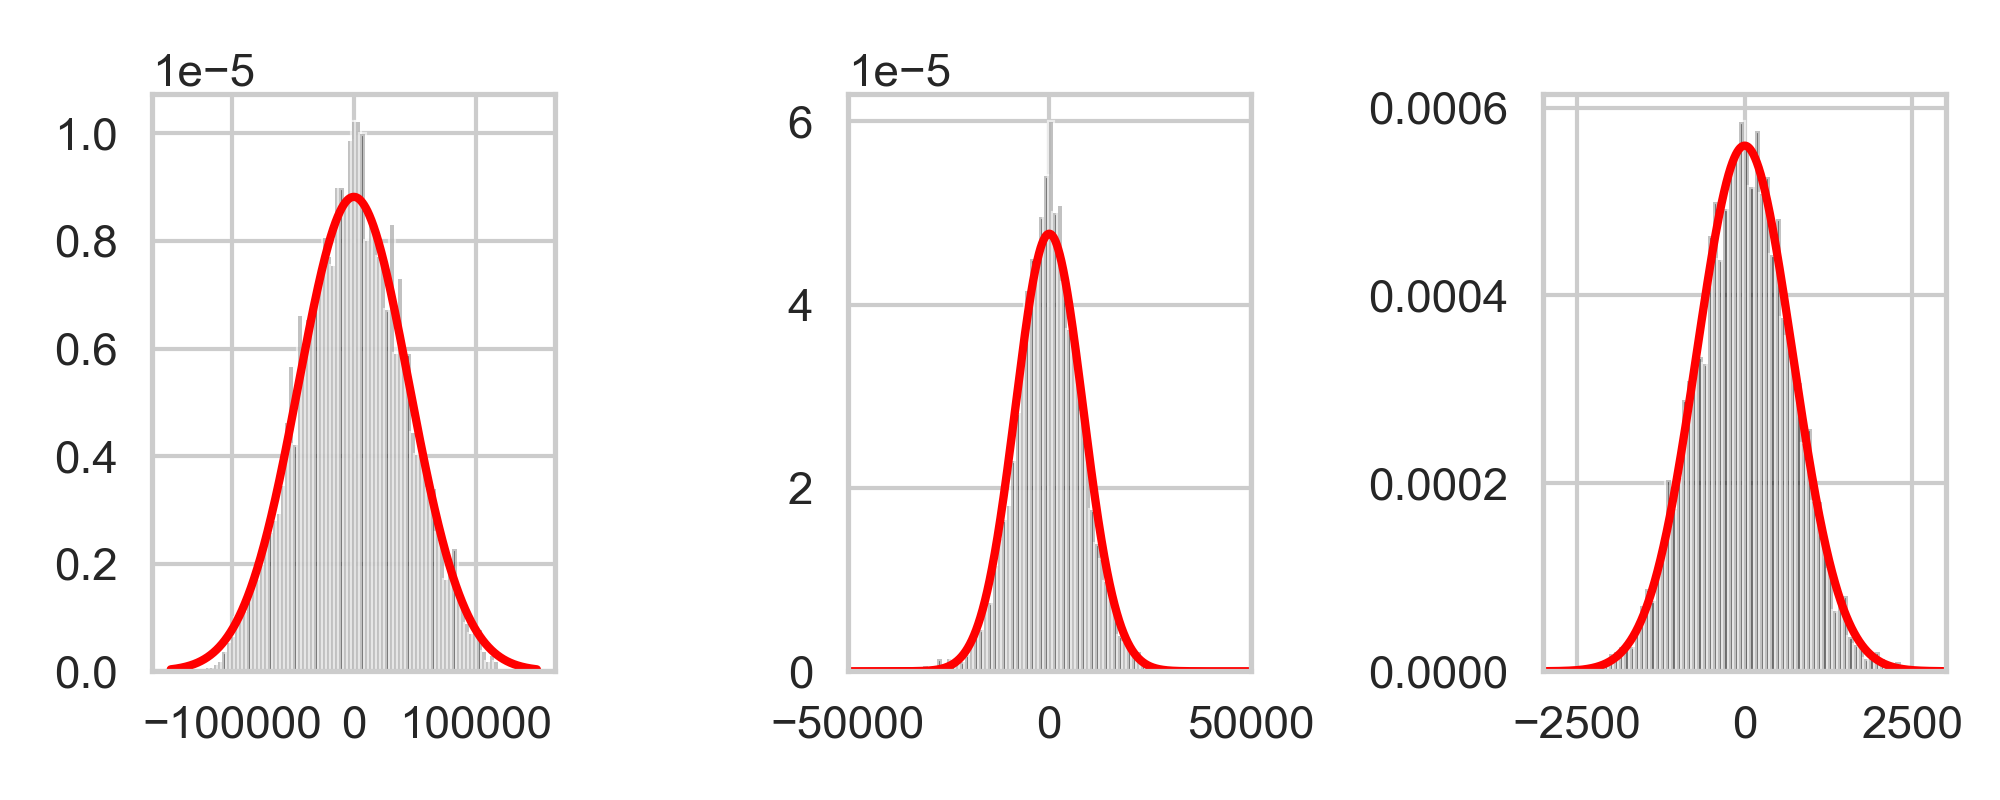

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(fourier1_all[:,1].real, bins=70, color="black", alpha=0.6, density=True)
ax2.hist(fourier1_all[:,10].real, bins=70, color="black", alpha=0.6, density=True)
ax3.hist(fourier1_all[:,1000].real, bins=70, color="black", alpha=0.6, density=True)

ax1.plot(u, prob_norm1, lw=3, color="red")
ax2.plot(u, prob_norm2, lw=3, color="red")
ax3.plot(u, prob_norm3, lw=3, color="red")

ax2.set_xlim(-50000, 50000)
ax3.set_xlim(-3000, 3000)

plt.tight_layout()


How does this variance compare if I don't have any white noise in my data?

In [37]:
nsim = 5000

fourier1_all_rn = []
lc1_counts_all_rn = []
lc1_all_rn = []
ps1_all_rn = []

for i in range(nsim):
    #print(i)
    lc = sim.simulate(2.0)
            
    lc1_counts_all_rn.append(np.sum(lc.counts))
    
    lc1_all_rn.append(lc)
    
    fourier1 = scipy.fftpack.fft(lc.counts)
    freqs = scipy.fftpack.fftfreq(npoints, lc.dt)
    fourier1 = fourier1[freqs>0]
    freqs = freqs[freqs > 0]

    ps1 = Powerspectrum(lc, norm="leahy")
    
    ps1_all_rn.append(ps1)
    
    fourier1_all_rn.append(fourier1[:1500])


In [38]:
fourier1_all_rn = np.array(fourier1_all_rn)
lc1_counts_all_rn = np.array(lc1_counts_all_rn)

avg_ps1_rn = AveragedPowerspectrum(lc1_all_rn, segment_size=lc1_all_rn[0].tseg, norm="leahy")

mrn = models.PowerLaw1D() + models.Const1D()
mrn.x_0_0.fixed=True

loglike_rn = PSDLogLikelihood(avg_ps1_rn.freq, avg_ps1_rn.power, model=mrn, m=avg_ps1_rn.m)

parest_rn = PSDParEst(avg_ps1_rn, max_post=False)
res_rn = parest.fit(loglike_rn, [3.24e4, 2, 2])

mrn.amplitude_0 = res_rn.p_opt[0]
mrn.alpha_0 = res_rn.p_opt[1]
mrn.amplitude_1 = res_rn.p_opt[2]

mps_rn = mrn(avg_ps1_rn.freq)

5000it [00:07, 707.78it/s]


In [39]:
res_rn.p_opt

array([ 3.25140625e+04,  1.99231974e+00, -2.30271393e-05])

<IPython.core.display.Javascript object>


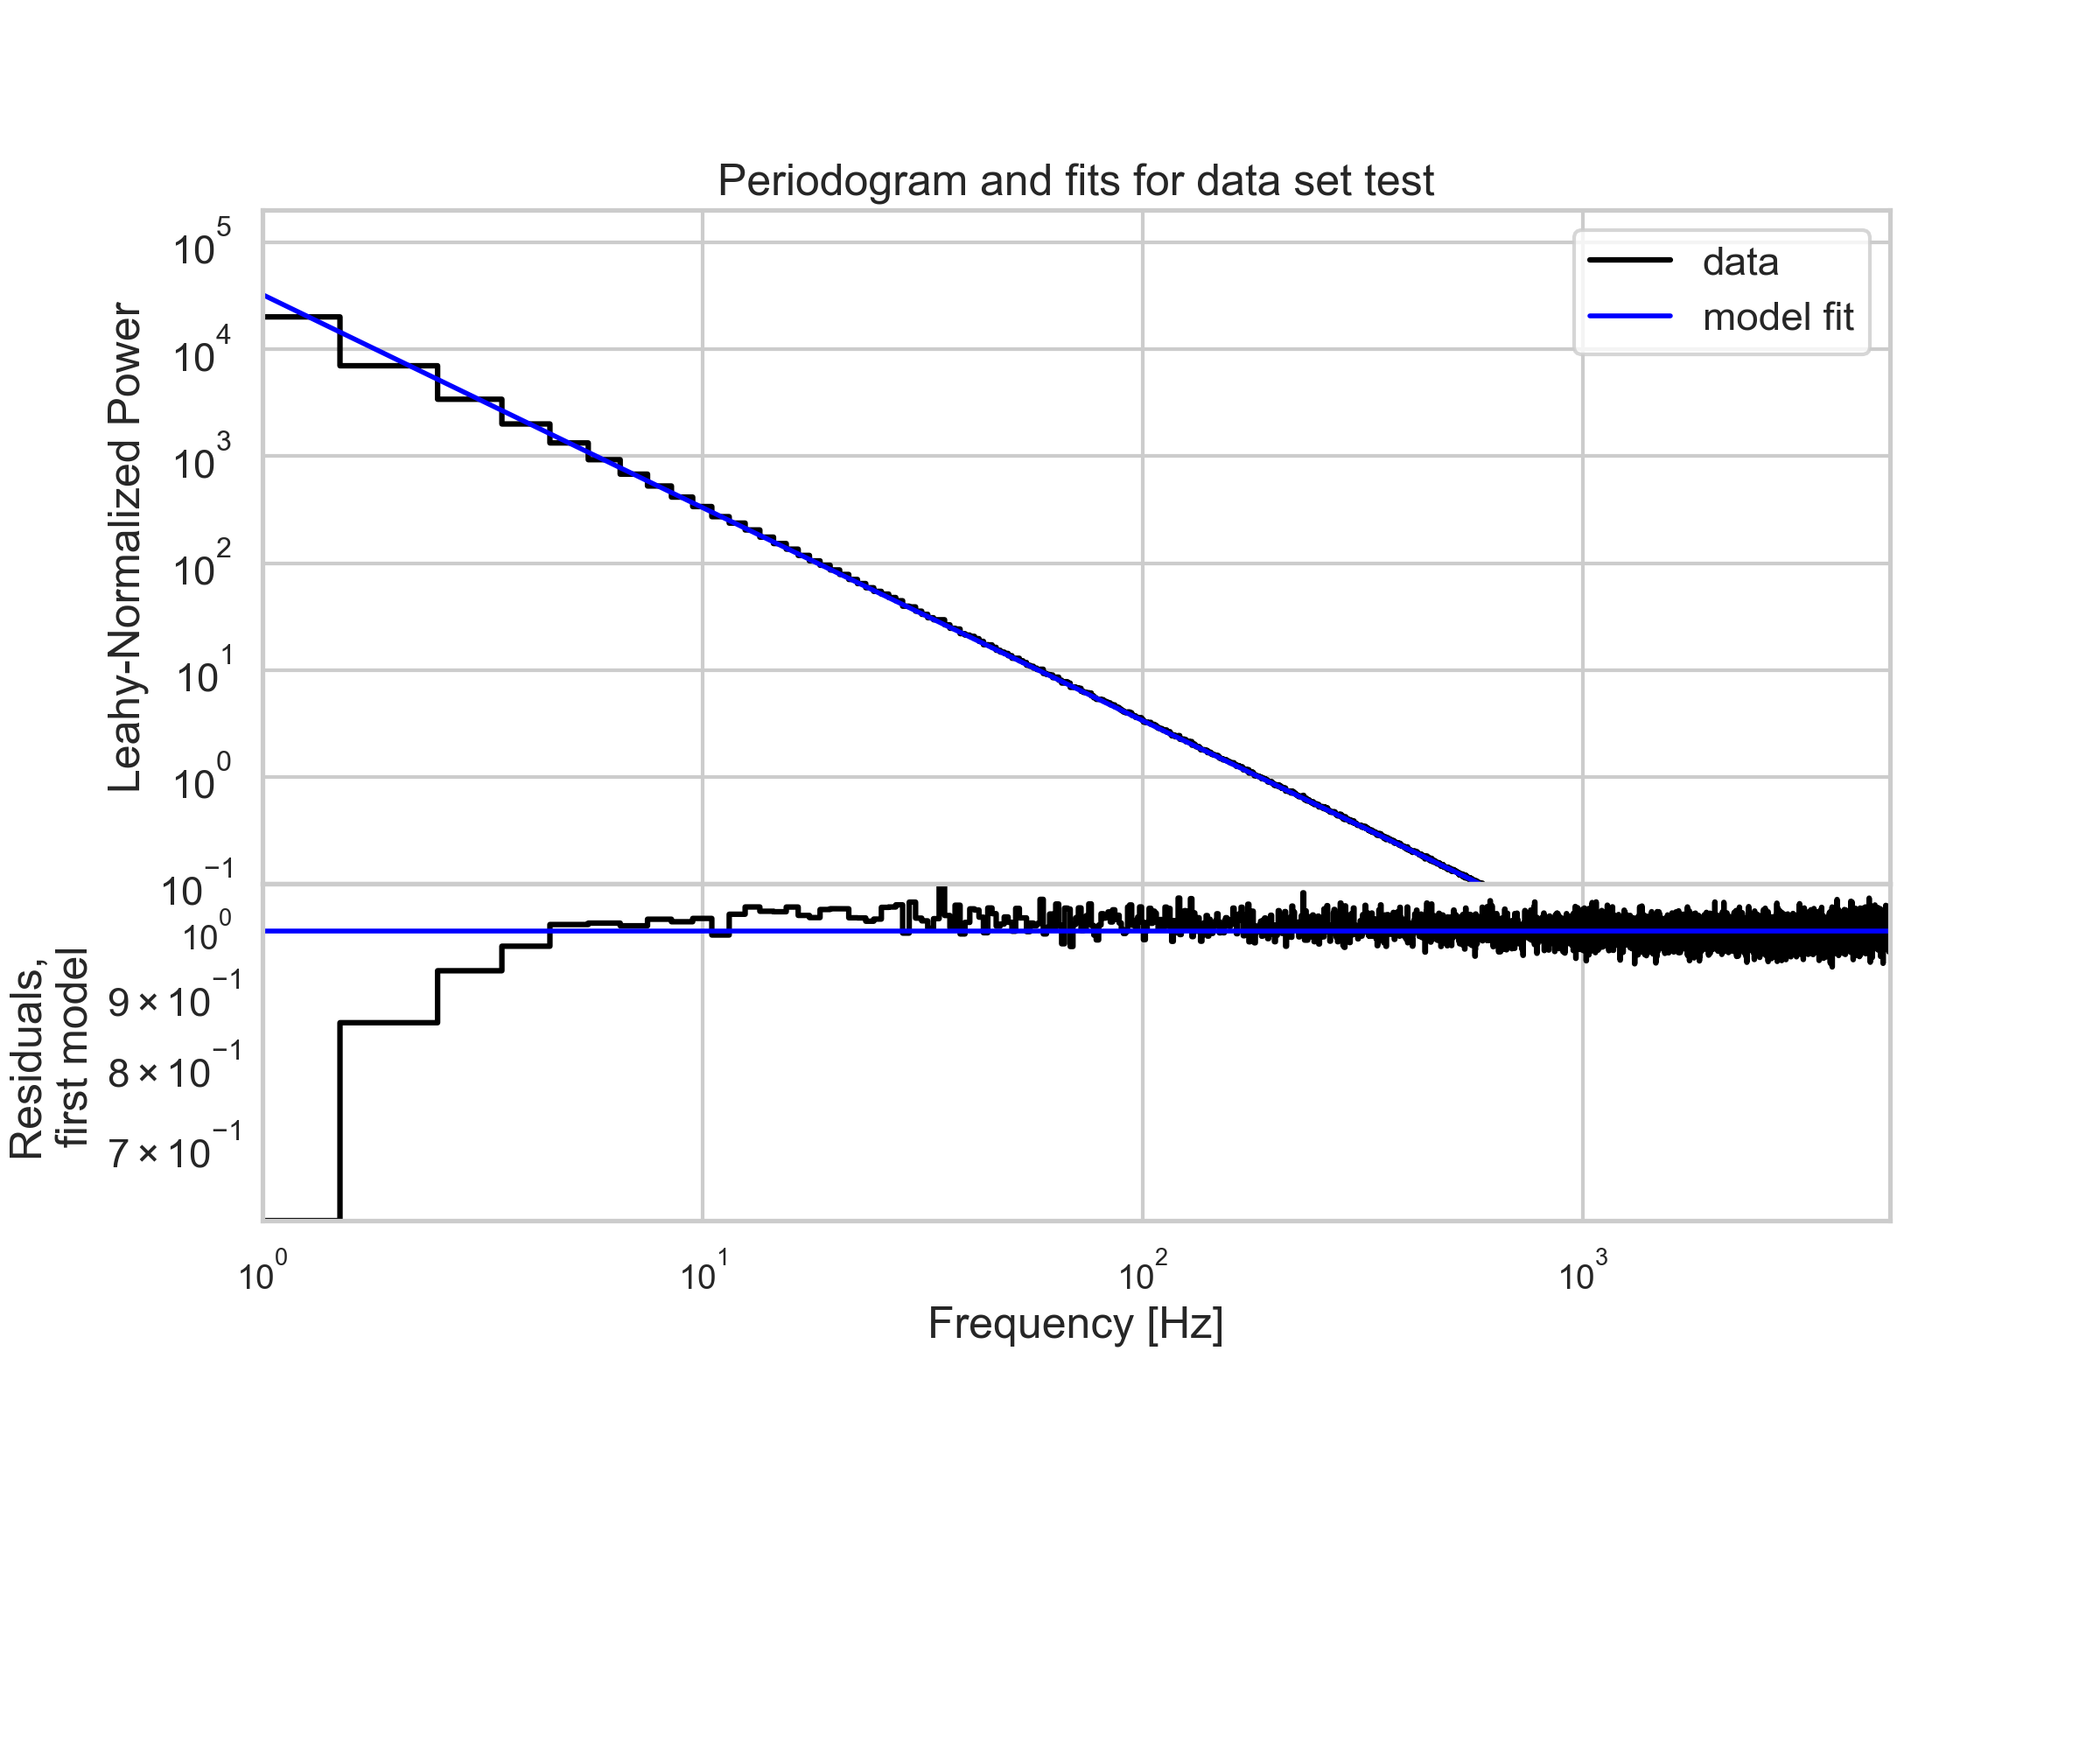

In [40]:
parest_rn.plotfits(res_rn)

In [41]:
mps_rn_wn = mps_rn + 2.0

<IPython.core.display.Javascript object>


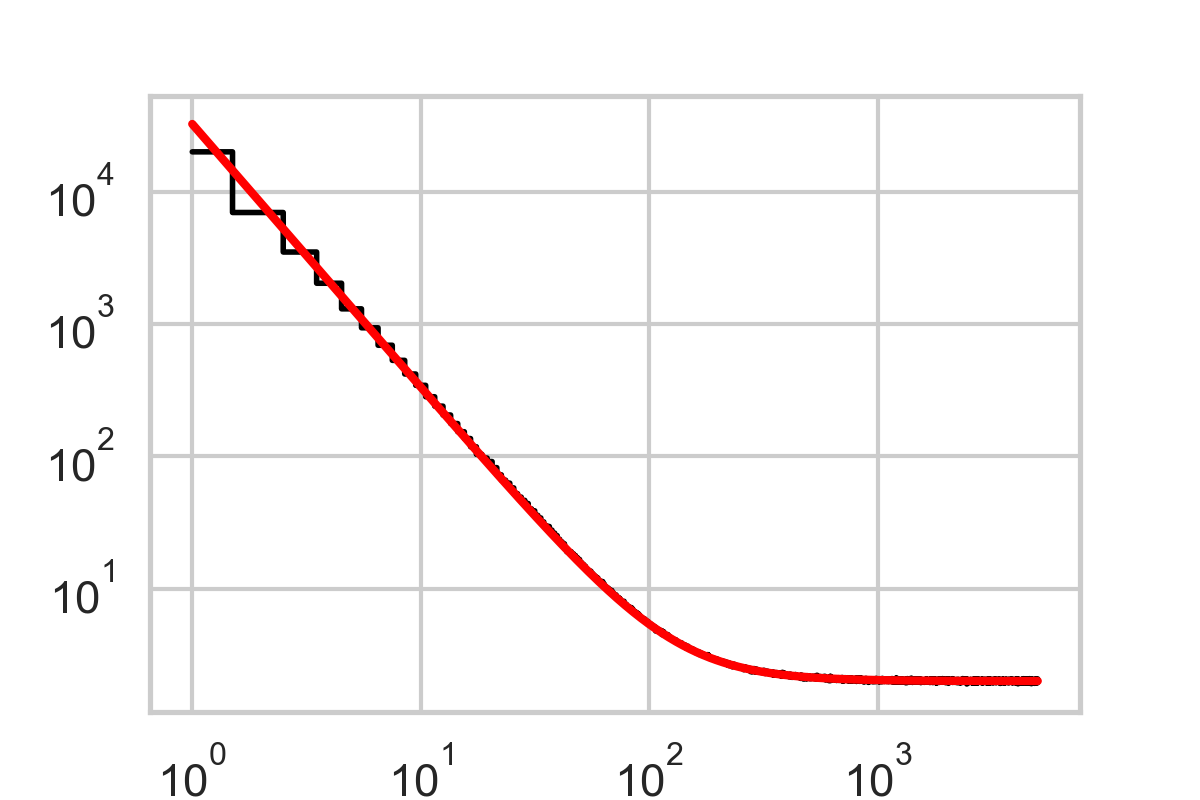

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.loglog(avg_ps1.freq, avg_ps1.power, lw=2, color="black", ds="steps-mid")
ax.plot(avg_ps1.freq, mps_rn_wn, lw=3, color="red")

In [43]:
mps_rn/mps_rn_wn

array([9.99938492e-01, 9.99755319e-01, 9.99451346e-01, ...,
       6.83091189e-04, 6.82814523e-04, 6.82538023e-04])

In [44]:
for i in range(50):
    f = fourier1_all[:,i]
    print("shape: " + str(f.shape))
    print("mean: " + str(np.mean(f.real)))
    var_data = np.var(f.real)
    var_model = mps_rn[i]/4.0*np.mean(lc1_counts_all) + np.mean(lc1_counts_all)/2.0
    print("std: " + str(np.sqrt(var_data)))
    print("var(model): " + str(np.sqrt(var_model)))
    print("ratio: " + str(var_data/var_model))
    print("\n")

shape: (5000,)
mean: 1411.2119207269686
std: 70698.85493902702
var(model): 90161.8827208746
ratio: 0.614863645995918


shape: (5000,)
mean: 406.05826584651976
std: 42141.24722556482
var(model): 45205.23716881424
ratio: 0.8690349958439685


shape: (5000,)
mean: -379.34283946764236
std: 29384.250494407865
var(model): 30188.375191378655
ratio: 0.9474357266447367


shape: (5000,)
mean: 137.20814156276845
std: 22383.02496651037
var(model): 22671.119118482762
ratio: 0.9747464016660882


shape: (5000,)
mean: -482.08593135430726
std: 17952.175949522283
var(model): 18157.385723645162
ratio: 0.9775242796462608


shape: (5000,)
mean: -319.01339482754065
std: 15375.36908839997
var(model): 15146.780437306212
ratio: 1.0304108892993329


shape: (5000,)
mean: 219.995238413329
std: 13188.31604296139
var(model): 12995.730316175051
ratio: 1.0298579149955032


shape: (5000,)
mean: 171.78110046236873
std: 11493.59165330632
var(model): 11382.22822195301
ratio: 1.0196636752770565


shape: (5000,)
mean: 0.216

Let's do pure white noise for comparison:

In [45]:
nsim = 5000

fourier1_all_wn = []
lc1_counts_all_wn = []
lc1_all_wn = []
ps1_all_wn = []

time = lc.time

for i in tqdm(range(nsim)):
    counts = np.random.poisson(100, size=time.shape[0])
    lc = Lightcurve(time, counts, dt=dt, skip_checks=True)
            
    lc1_counts_all_wn.append(np.sum(lc.counts))
    
    lc1_all_wn.append(lc)
    
    fourier1 = scipy.fftpack.fft(lc.counts)
    freqs = scipy.fftpack.fftfreq(npoints, lc.dt)
    fourier1 = fourier1[freqs>0]
    freqs = freqs[freqs > 0]

    ps1 = Powerspectrum(lc, norm="leahy")
    
    ps1_all_wn.append(ps1)
    
    fourier1_all_wn.append(fourier1[:1500])



100%|██████████| 5000/5000 [00:18<00:00, 274.37it/s]


In [46]:
fourier1_all_wn = np.array(fourier1_all_wn)

In [47]:
for i in range(50):
    f = fourier1_all_wn[:,i]
    print("shape: " + str(f.shape))
    print("mean: " + str(np.mean(f.real)))
    var_data = np.var(f.real)
    var_model = 2.0/4.0*np.mean(lc1_counts_all)
    print("std: " + str(np.sqrt(var_data)))
    print("var(model): " + str(np.sqrt(var_model)))
    print("ratio: " + str(var_data/var_model))
    print("\n")

shape: (5000,)
mean: -15.285067191703524
std: 710.6299288309623
var(model): 707.1132825085383
ratio: 1.0099712195438293


shape: (5000,)
mean: 16.263982565430624
std: 703.8747039935881
var(model): 707.1132825085383
ratio: 0.9908609772979555


shape: (5000,)
mean: -0.2972781609464233
std: 715.39263879399
var(model): 707.1132825085383
ratio: 1.0235544335481999


shape: (5000,)
mean: -1.9990286209762693
std: 696.0205533960306
var(model): 707.1132825085383
ratio: 0.9688714053107095


shape: (5000,)
mean: -5.439380682163261
std: 704.4465932710265
var(model): 707.1132825085383
ratio: 0.9924717553761891


shape: (5000,)
mean: 0.8887355484142341
std: 691.2121357164011
var(model): 707.1132825085383
ratio: 0.9555308622484435


shape: (5000,)
mean: 17.480824114967543
std: 705.8668427812711
var(model): 707.1132825085383
ratio: 0.9964776756466132


shape: (5000,)
mean: -4.323818177034614
std: 701.1181697957041
var(model): 707.1132825085383
ratio: 0.9831152979213884


shape: (5000,)
mean: 6.91488888

<IPython.core.display.Javascript object>


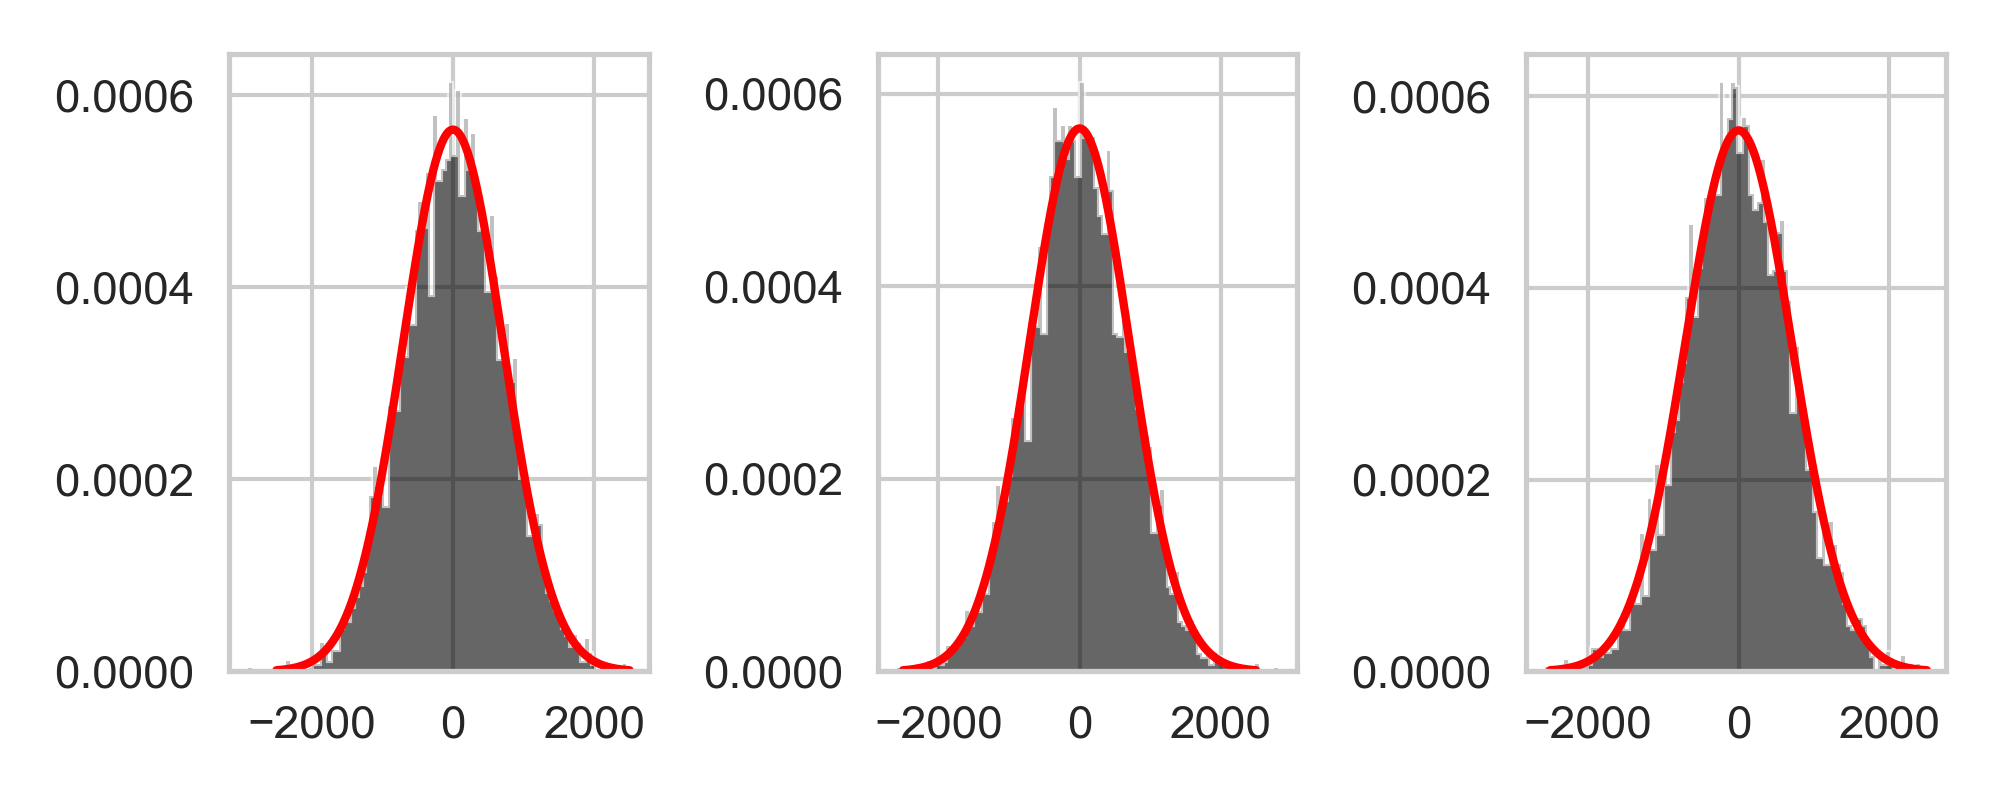

In [48]:
norm_test = scipy.stats.norm(0, np.sqrt(np.mean(lc1_counts_all_wn)/2.0))
utest = np.linspace(-2500, 2500, 10000)
prob_test = norm_test.pdf(utest)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(fourier1_all_wn[:,1].real, bins=100, color="black", alpha=0.6, density=True, histtype="stepfilled")
ax2.hist(fourier1_all_wn[:,10].real, bins=100, color="black", alpha=0.6, density=True, histtype="stepfilled")
ax3.hist(fourier1_all_wn[:,499].real, bins=100, color="black", alpha=0.6, density=True, histtype="stepfilled")

ax1.plot(utest, prob_test, lw=3, color="red")
ax2.plot(utest, prob_test, lw=3, color="red")
ax3.plot(utest, prob_test, lw=3, color="red")


plt.tight_layout()




Let's plot some of the distributions:

<IPython.core.display.Javascript object>


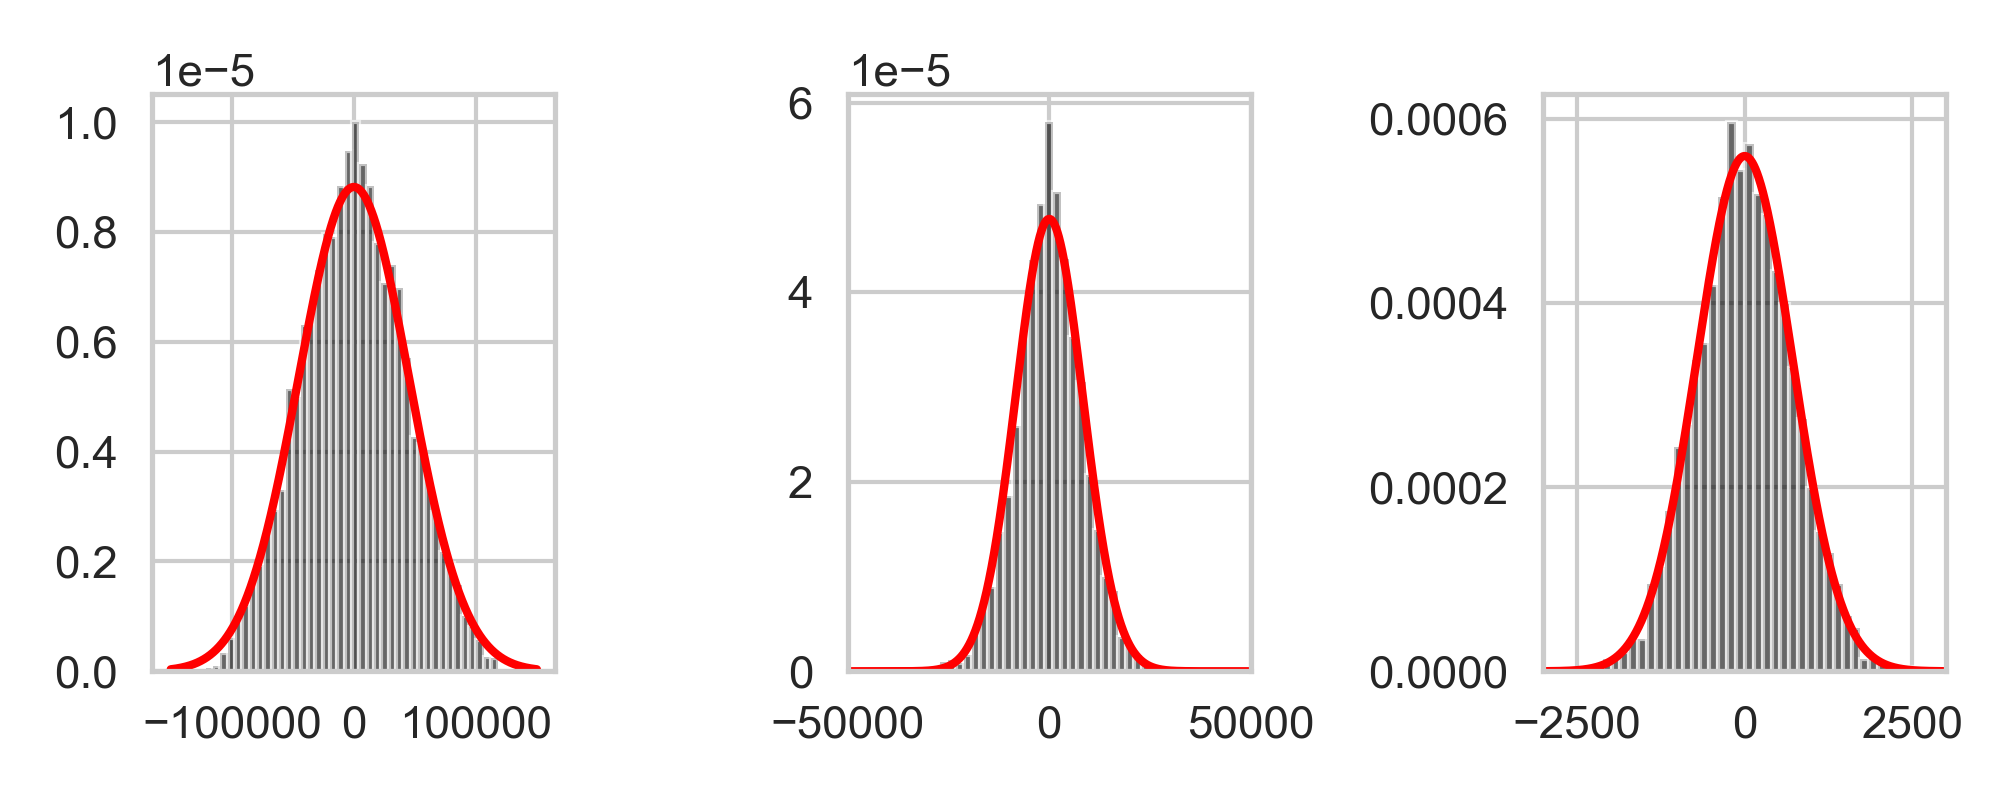

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(fourier1_all[:,1].real, bins=40, color="black", alpha=0.6, density=True)
ax2.hist(fourier1_all[:,10].real, bins=40, color="black", alpha=0.6, density=True)
ax3.hist(fourier1_all[:,499].real, bins=40, color="black", alpha=0.6, density=True)

ax1.plot(u, prob_norm1, lw=3, color="red")
ax2.plot(u, prob_norm2, lw=3, color="red")
ax3.plot(u, prob_norm3, lw=3, color="red")

ax2.set_xlim(-50000, 50000)
ax3.set_xlim(-3000, 3000)

plt.tight_layout()



That looks approximately the way it should.

Now let's do the same for the *squared* Fourier amplitudes:

In [50]:
fourier_squared_test = []

fourier_squared_test_lc1 = []

for f1, f2 in zip(fourier1_all, fourier2_all):
    #fourier_squared_test.append(f1.conj() * f2)
    fourier_squared_test.append(f1.real * f2.real)
    fourier_squared_test_lc1.append(f1.conj()*f1)

In [51]:
fourier_squared_test = np.array(fourier_squared_test)
fourier_squared_test_lc1 = np.array(fourier_squared_test_lc1)

In [52]:
for i in range(500):
    print("mean cospectra: " + str(np.mean(fourier_squared_test[:,i].real)))
    print("std cospectra: " + str(np.std(fourier_squared_test[:,i].real)))
    print("mean psd: " + str(np.mean(fourier_squared_test_lc1[:,i].real)))
    print("std psd: " + str(np.std(fourier_squared_test_lc1[:,i].real)))

    print()

mean cospectra: 4999779705.041657
std cospectra: 4651440900.402408
mean psd: 10014366958.795162
std psd: 4923094726.859017

mean cospectra: 1775087441.0770125
std cospectra: 2295234409.1323867
mean psd: 3483413491.1620946
std psd: 3069431774.5679045

mean cospectra: 863243029.3165908
std cospectra: 1257826693.206081
mean psd: 1750710696.997556
std psd: 1847261951.199021

mean cospectra: 500254478.486951
std cospectra: 780719781.6681066
mean psd: 1016902497.2015837
std psd: 1136646143.347231

mean cospectra: 321869421.56500214
std cospectra: 542118927.0450754
mean psd: 651275067.5658889
std psd: 789701109.754188

mean cospectra: 235962058.99665934
std cospectra: 382349307.1731935
mean psd: 468273973.41578245
std psd: 565981093.245141

mean cospectra: 173484884.62333393
std cospectra: 289011881.5747649
mean psd: 345517173.3082309
std psd: 427245691.06067663

mean cospectra: 131741025.47130737
std cospectra: 222156551.78890985
mean psd: 265647996.5842295
std psd: 335395038.048131

mean co

std psd: 1211166.1327775815

mean cospectra: 104879.86043261064
std cospectra: 635479.2159070747
mean psd: 1227563.6759834967
std psd: 1241664.3150169358

mean cospectra: 101802.67448479035
std cospectra: 646762.1939061624
mean psd: 1247899.313771939
std psd: 1285361.9662529712

mean cospectra: 92561.86211065775
std cospectra: 602185.9596068829
mean psd: 1232768.003142063
std psd: 1237067.6275538427

mean cospectra: 118922.81448484882
std cospectra: 630747.0113224649
mean psd: 1233523.8699578636
std psd: 1287527.0492229548

mean cospectra: 113879.07570686862
std cospectra: 611073.7722961555
mean psd: 1176173.876860438
std psd: 1218225.8337145005

mean cospectra: 118184.02674630556
std cospectra: 619214.9054993042
mean psd: 1205682.600923152
std psd: 1222703.612773482

mean cospectra: 100067.86640155583
std cospectra: 600083.1792904394
mean psd: 1203392.1727185438
std psd: 1216696.7648961202

mean cospectra: 109614.69396135808
std cospectra: 610254.2708571702
mean psd: 1214254.065162010

In [53]:
std1 = np.sqrt(np.mean(lc1_counts_all))
std2 = np.sqrt(np.mean(lc2_counts_all))

In [54]:
scipy.special.kn(0, 1000)

0.0

In [55]:
def bessel_probability(x, std1, std2):
    x_abs = np.abs(x)
    both_std = std1 * std2
    y = x_abs/(both_std)
    order = 0
    k = scipy.special.kn(order, y)/(np.pi*both_std)
    return k

In [56]:
u = np.linspace(-3e6, 3e6, 100000)
prob_u = bessel_probability(u, std1, std2)

In [57]:
prob_u

array([1.10578794e-08, 1.10586464e-08, 1.10594134e-08, ...,
       1.10594134e-08, 1.10586464e-08, 1.10578794e-08])

In [58]:
fourier_squared_test.shape

(5000, 1500)

<IPython.core.display.Javascript object>


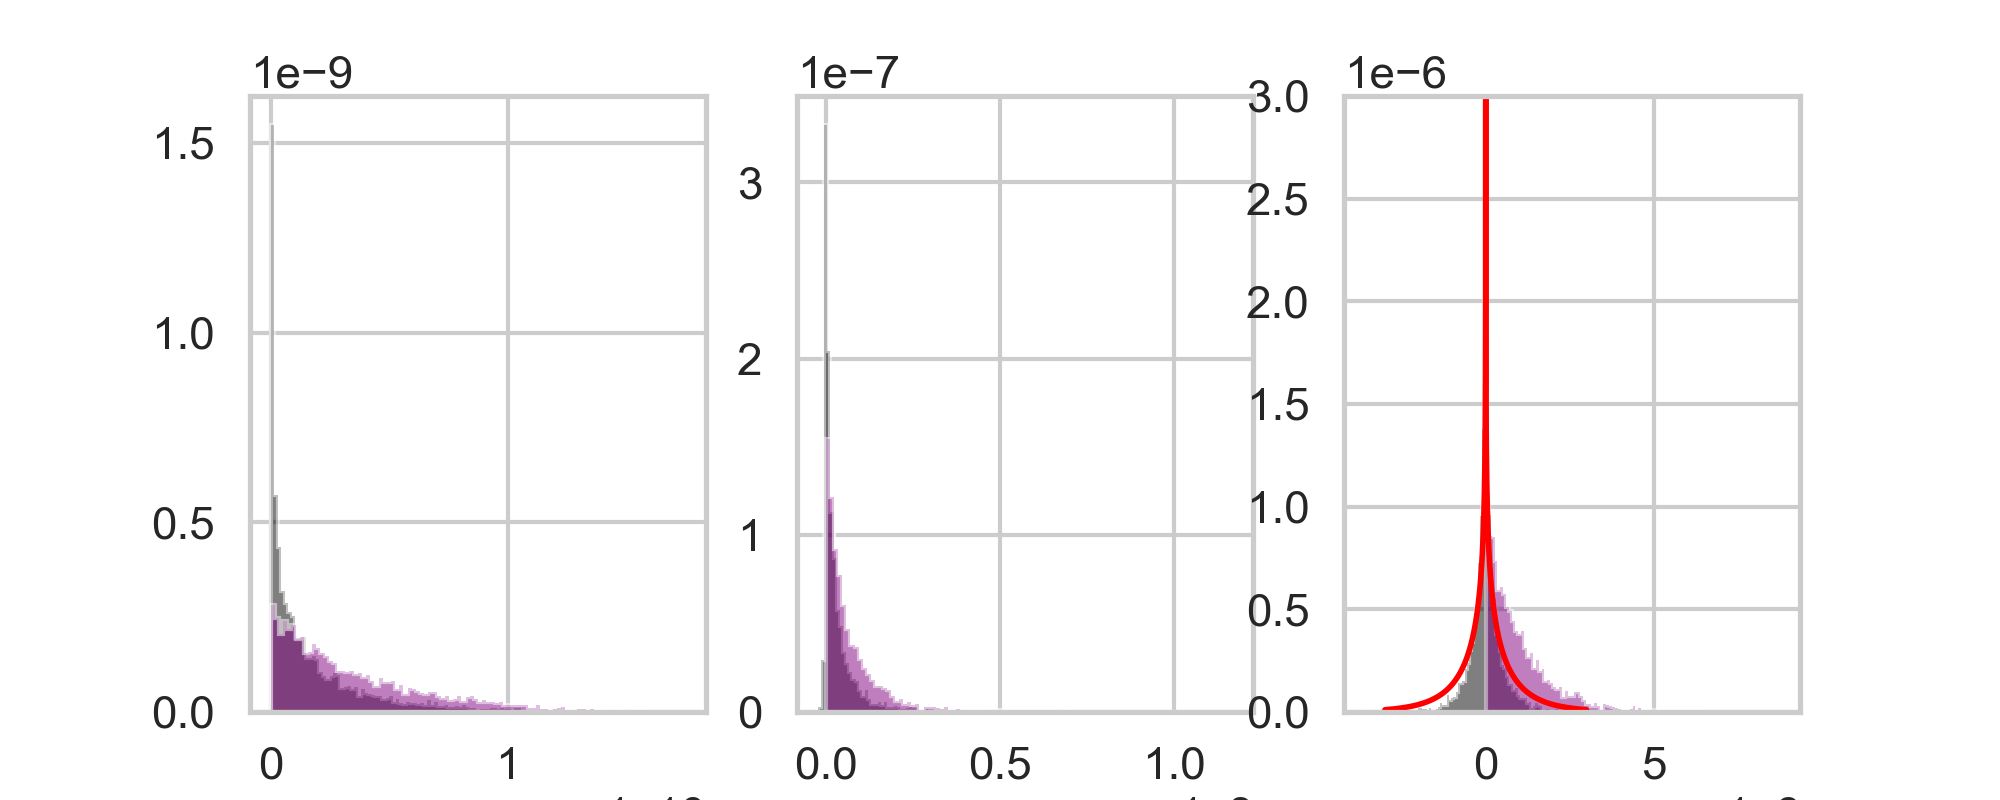

(0.0, 3e-06)

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(fourier_squared_test[:, 1].real, bins=100, alpha=0.5, color="black", density=True, histtype="stepfilled")
ax1.hist(fourier_squared_test_lc1[:, 1].real, bins=100, alpha=0.5, color="purple", density=True, histtype="stepfilled")

ax2.hist(fourier_squared_test[:, 50].real, bins=100, alpha=0.5, color="black", density=True, histtype="stepfilled")
ax2.hist(fourier_squared_test_lc1[:, 50].real, bins=100, alpha=0.5, color="purple", density=True, histtype="stepfilled")

ax3.hist(fourier_squared_test[:, 1499].real, bins=100, alpha=0.5, color="black", density=True, histtype="stepfilled")
ax3.hist(fourier_squared_test_lc1[:, 1499].real, bins=100, alpha=0.5, color="purple", density=True, histtype="stepfilled");
ax3.plot(u, prob_u, lw=2, color="red")
#ax3.set_xlim(-3e5, 3e5)
ax3.set_ylim(0, 3e-6)

Okay, so it's definitely not a normal Bessel distribution. It's also not a $\chi^2$ distribution we would expect for a power spectrum. So what *is* it?

I have the suspicion that the two Fourier amplitudes are *correlated* in the red noise case: I don't see how you would otherwise get such a heavily skewed distribution when multipling them. Let's look at the *difference* of Fourier amplitudes:

In [60]:
f1 = fourier1_all[0]
f2 = fourier2_all[0]

In [61]:
f1[:20]

array([-96600.86374765+79249.86168882j,   9107.71326734+30856.41336851j,
        21254.58553642-35063.98185958j,  -3652.62934073 +5926.00489173j,
        10304.24779706+29787.94088041j,   3315.06492058  -468.08274123j,
         3404.98504711 -7559.86713596j,  -6932.41518181 +2613.23465581j,
        -1422.62210847  +428.27711767j,    824.25712557 -4283.10191208j,
        -1929.88542116 -4260.62814126j,   2413.79341729 +5198.20307532j,
        -3506.69950344  -757.93587893j,   3247.81595934 +2502.64826293j,
         1186.38090756 -2775.33656524j,   -615.63337169 -6642.75386111j,
        -1156.99982238 -1946.30247551j,   3706.33723524 -3089.24900499j,
        -1155.45262732 -3466.76670098j,  -2254.12693778 -1210.61606254j])

In [62]:
f2[:20]

array([-96032.65907402+79514.60668244j,   7736.9449293 +32313.22539256j,
        22281.84710567-33702.36559818j,  -3798.74473963 +6385.81907085j,
        10621.36680761+29608.28958912j,   5241.54014363  -470.54923183j,
          395.30537045 -6671.73979284j,  -7741.67813071 +3311.51914223j,
        -1248.26710615  +605.72518851j,   1253.10164646 -4080.89285489j,
        -1524.33952179 -5882.12373693j,   2148.37563648 +5553.19457779j,
        -3693.19599077 -1639.59494321j,   3138.74926157 +3086.51655453j,
         1632.16807466 -3452.66630633j,    853.21103036 -7834.95314715j,
        -1756.61310804 -2646.50702744j,   3320.43891103 -2777.18236933j,
        -2175.6876586  -5148.90155453j,  -2984.87004318  +821.65334167j])

In [63]:
f_diff = ([fourier1_all[i].real-fourier2_all[i].real for i in range(5000)])

In [64]:
f_diff = np.array(f_diff)

<IPython.core.display.Javascript object>


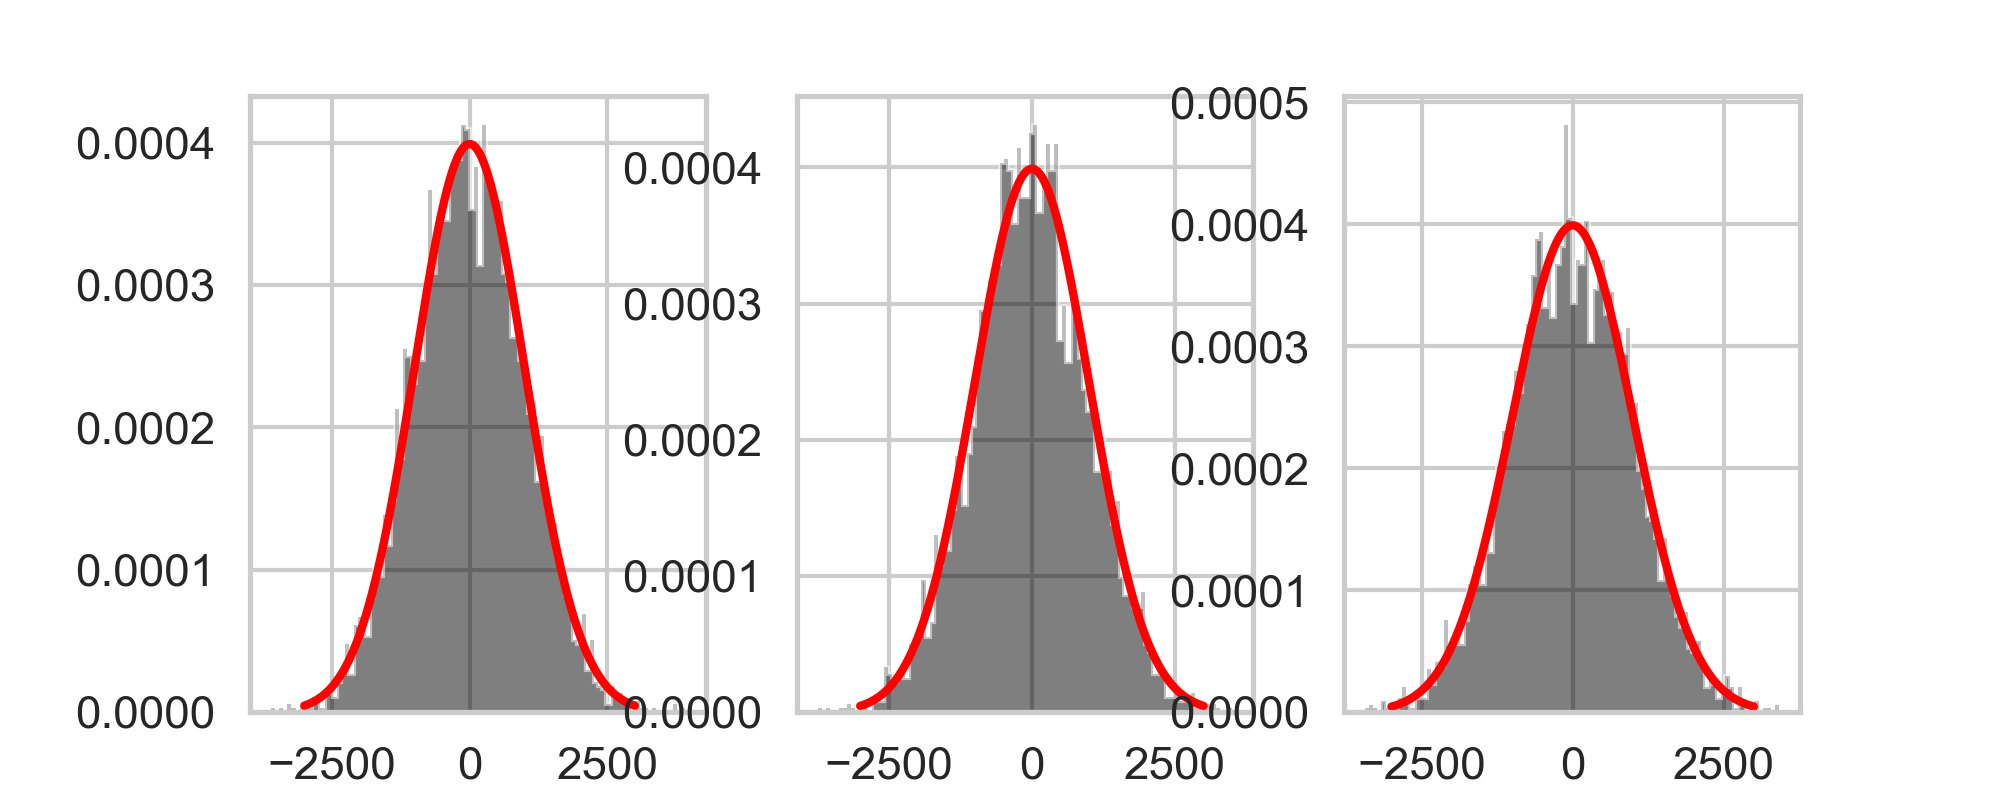

In [65]:
norm1 = scipy.stats.norm(0, np.sqrt(np.mean(lc1_counts_all)))
u = np.linspace(-3000, 3000, 10000)
prob_u = norm1.pdf(u)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(f_diff[:, 1], bins=100, alpha=0.5, color="black", density=True, histtype="stepfilled")
ax1.plot(u, prob_u, lw=3, color="red")

ax2.hist(f_diff[:, 10], bins=100, alpha=0.5, color="black", density=True, histtype="stepfilled")
ax2.plot(u, prob_u, lw=3, color="red")
#ax2.hist(fourier_squared_test_lc1[:, 10].real, bins=100, alpha=0.5, color="purple")

ax3.hist(f_diff[:, 499], bins=100, alpha=0.5, color="black", density=True, histtype="stepfilled");
ax3.plot(u, prob_u, lw=3, color="red")

#ax3.hist(fourier_squared_test_lc1[:, 499].real, bins=100, alpha=0.5, color="purple");

In [66]:
csd_normed_all = np.array(csd_normed_all)

In [67]:
np.min(csd_normed_all[:,100])

-7.1225226217400746

<IPython.core.display.Javascript object>


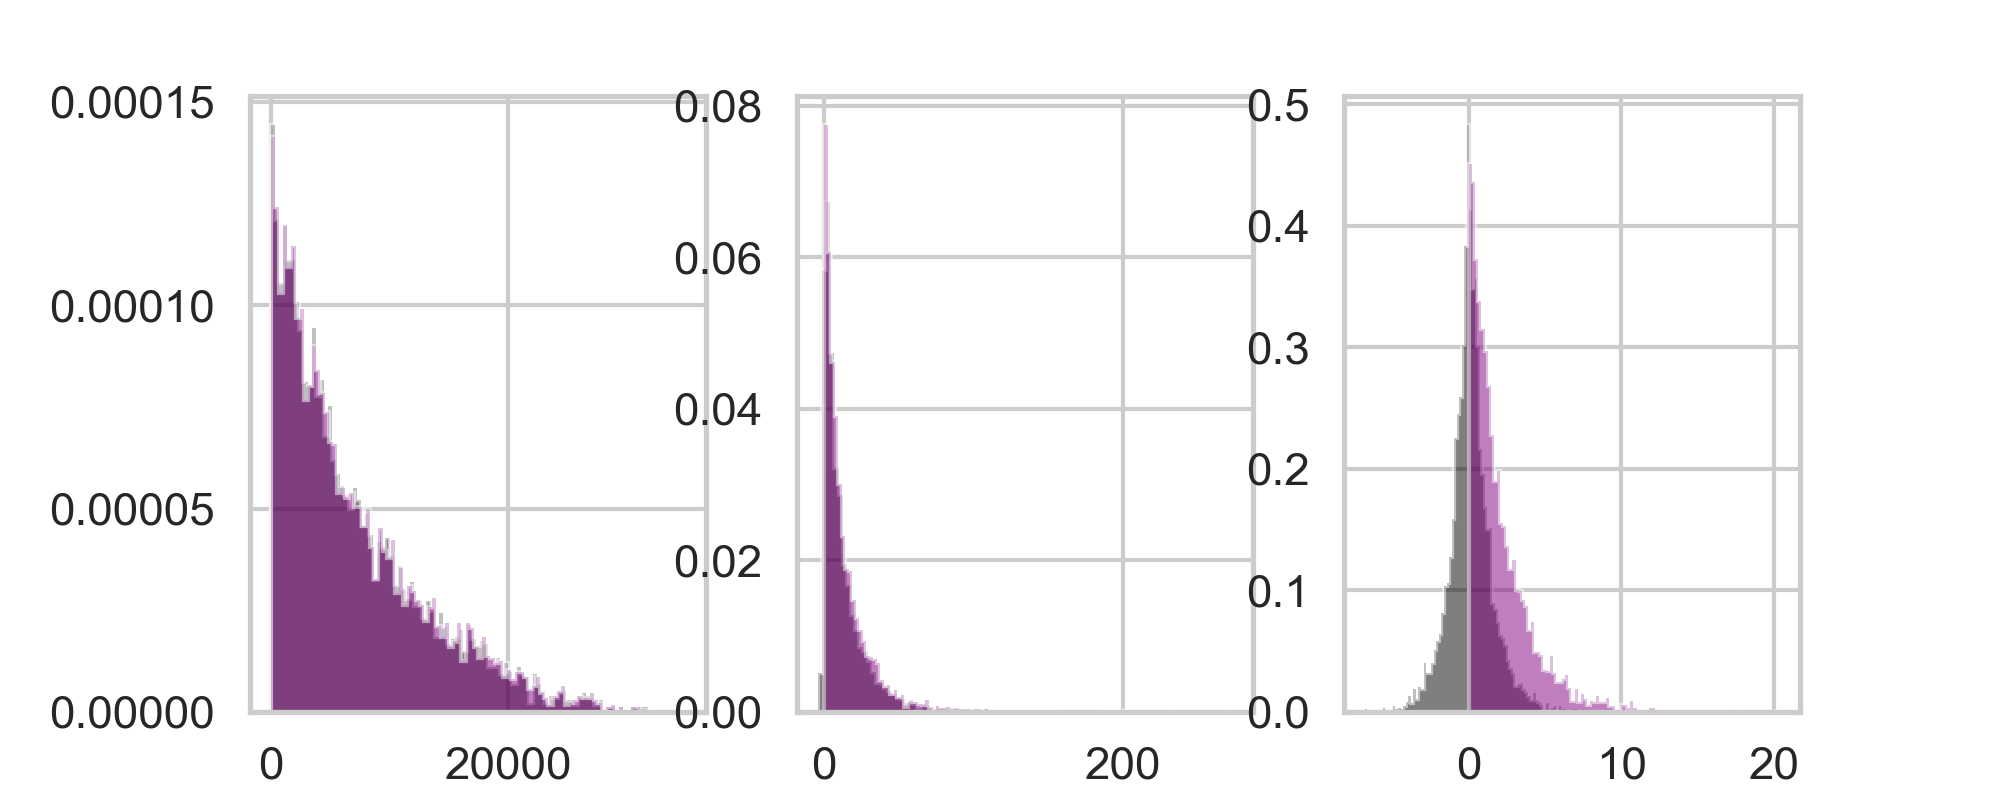

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
ax1.hist(csd_normed_all[:, 1], bins=100, alpha=0.5, color="black", density=True, histtype="stepfilled")
p = np.array([ps.power[1] for ps in ps1_all])

ax1.hist(p, bins=100, alpha=0.5, color="purple", density=True, histtype="stepfilled")

ax2.hist(csd_normed_all[:, 50].real, bins=100, alpha=0.5, color="black", density=True, histtype="stepfilled")
ax2.hist([ps.power[50] for ps in ps1_all], bins=100, alpha=0.5, color="purple", density=True, histtype="stepfilled")
#ax2.set_xlim(0, 500)

ax3.hist(csd_normed_all[:, 499].real, bins=100, alpha=0.5, color="black", density=True, histtype="stepfilled")
ax3.hist([ps.power[499] for ps in ps1_all], bins=100, alpha=0.5, color="purple", density=True, histtype="stepfilled");



<IPython.core.display.Javascript object>


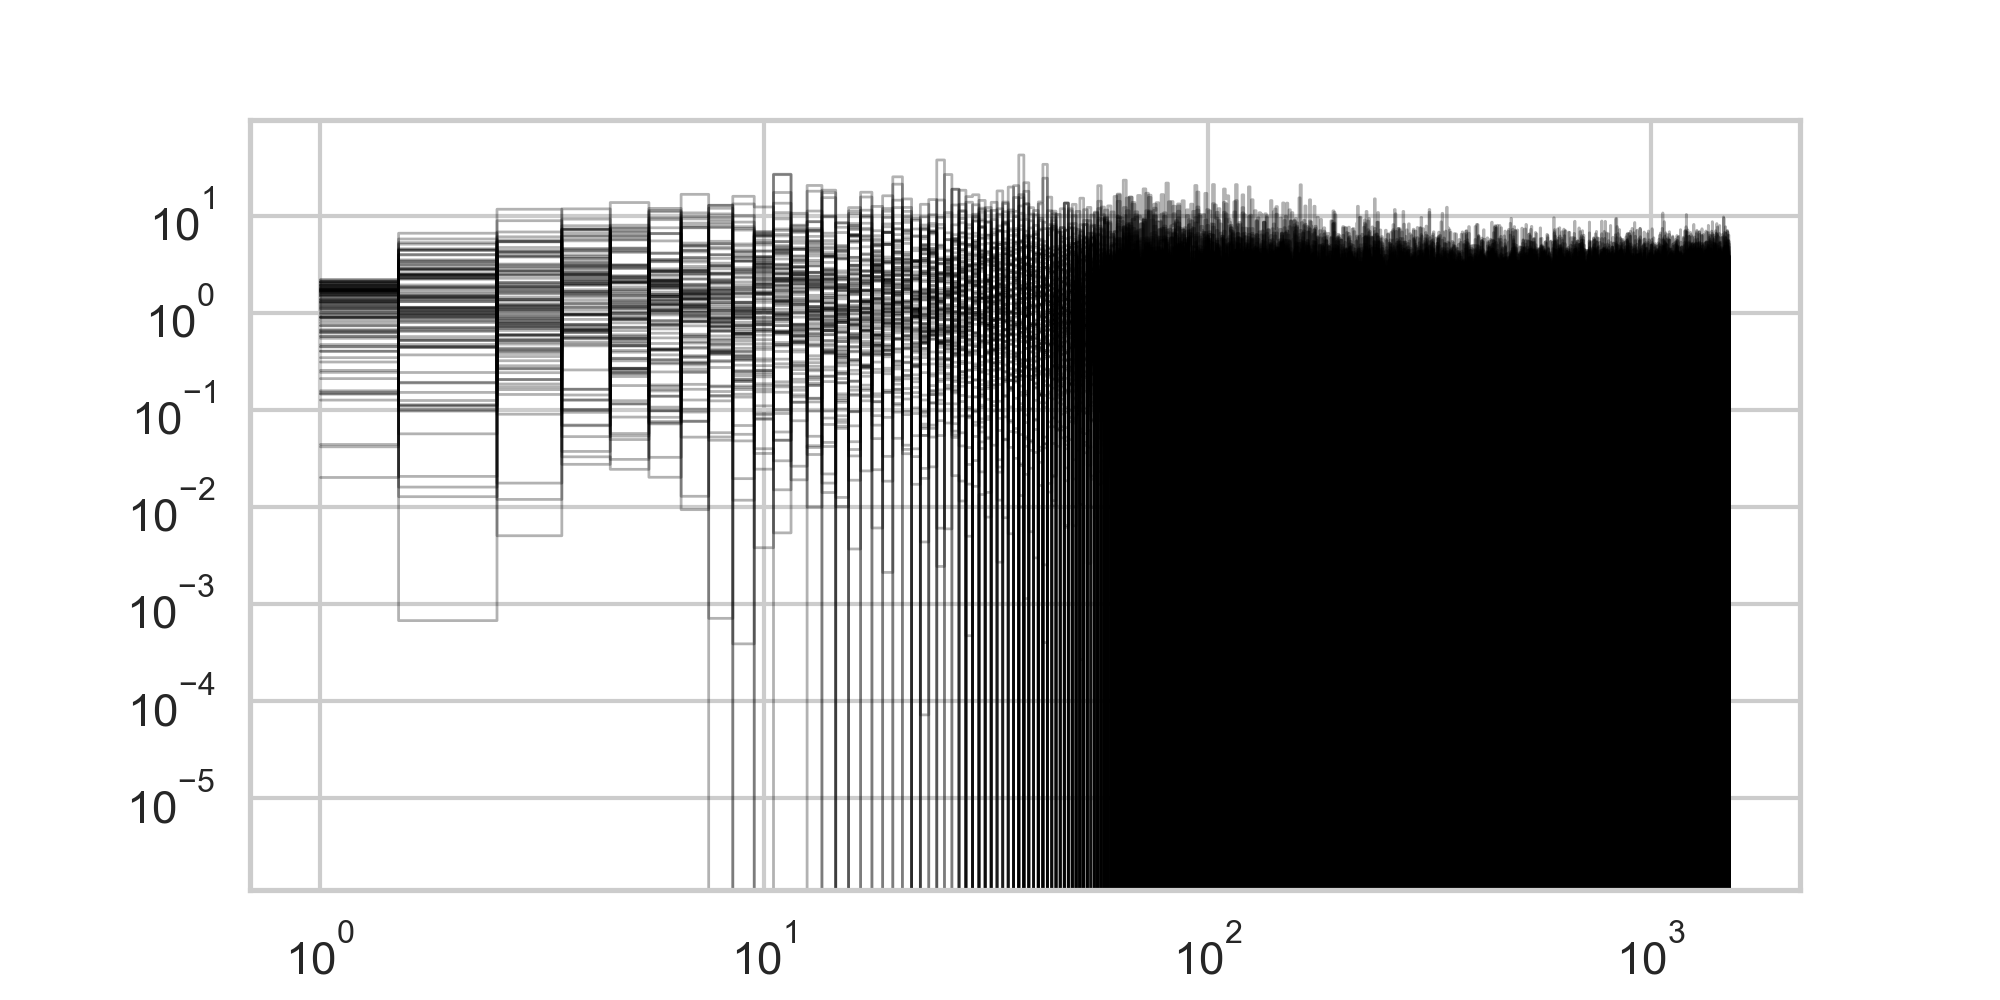

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for cs in csd_normed_all[:100]:
    ax.loglog(freqs[:1500], 2*cs/mps[:1500], lw=1, color="black", ds="steps-mid", alpha=0.3)

What's the correlation coefficient between the Fourier amplitudes?

In [70]:
np.cov(fourier1_all[-1].real, fourier2_all[-1].real)

array([[8236433.86352728, 7877899.1514122 ],
       [7877899.1514122 , 8447087.95449325]])

In [71]:
cov_all = []
for i in range(1500):
    cov_all.append(np.cov(fourier1_all[:,i].real, fourier2_all[:,i].real))

In [72]:
cov_all = np.array(cov_all)

<IPython.core.display.Javascript object>


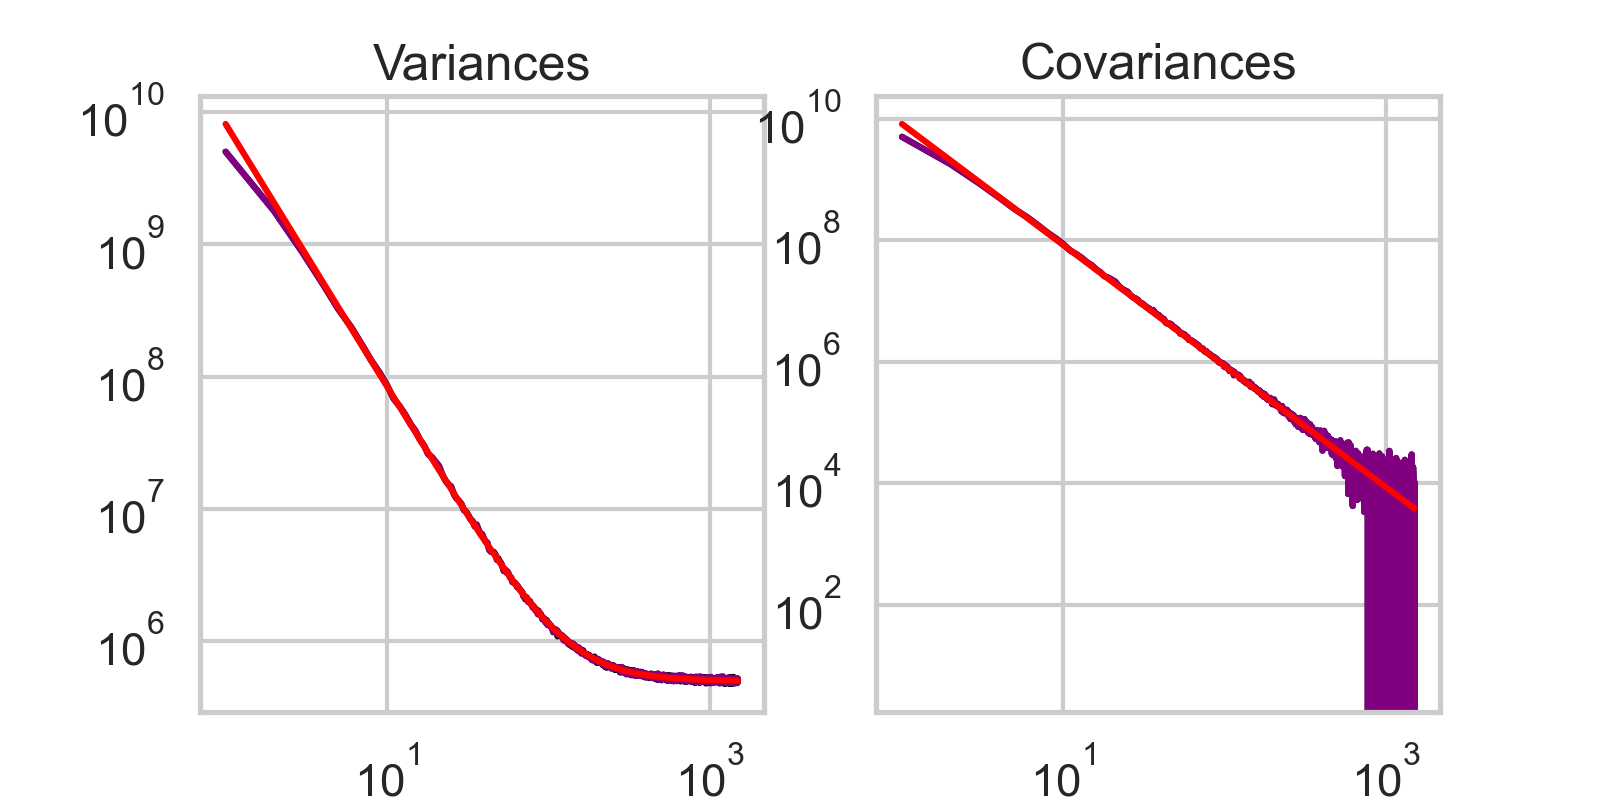

Text(0.5, 1.0, 'Covariances')

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.loglog(avg_ps1.freq[:1500], cov_all[:,0,0], color="black")
ax1.loglog(avg_ps1.freq[:1500], cov_all[:,1,1], color="purple")
ax1.loglog(avg_ps1.freq[:1500], mps[:1500]*np.mean(lc1_counts_all)/4.0, color="red")
ax1.set_title("Variances")

ax2.loglog(avg_ps1.freq[:1500], cov_all[:,0,1], color="black")
ax2.loglog(avg_ps1.freq[:1500], cov_all[:,1,0], color="purple")
ax2.loglog(avg_ps1.freq[:1500], mps_rn[:1500]*np.mean(lc1_counts_all)/4.0, color="red")
ax2.set_title("Covariances")



In [74]:
corr_coeff_real, corr_coeff_imag = [], []
for i in range(1500):
    corr_coeff_real.append(np.corrcoef(fourier1_all[:,i].real, fourier2_all[:,i].real)[0,1])
    corr_coeff_imag.append(np.corrcoef(fourier1_all[:,i].imag, fourier2_all[:,i].imag)[0,1])

I think I should be able to calculate this by hand. 

In [75]:
np.mean(lc1_counts_all)

1000018.3886

In [76]:
def calculate_r(mpower):
    return (mpower / (mpower + 2))

In [77]:
m2 = models.PowerLaw1D()

In [78]:
m2.alpha = m.alpha_0
m2.amplitude = m.amplitude_0

pl_model = m2(freqs)

In [79]:
rtest = calculate_r(pl_model[:1500])

<IPython.core.display.Javascript object>


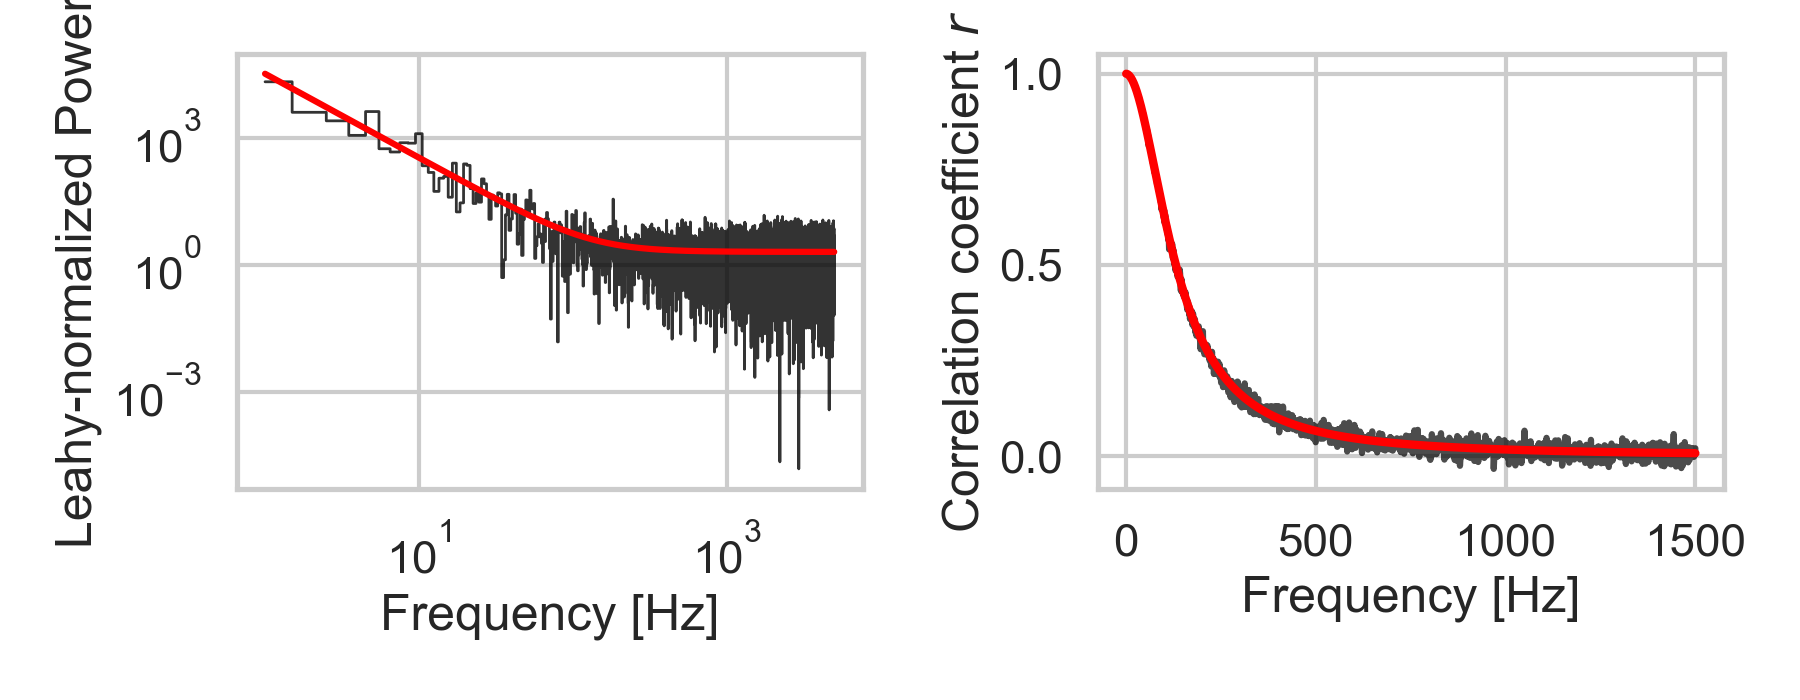

In [80]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,3.5))

ax1.loglog(ps1_all[1].freq, ps1_all[1].power, ds="steps-mid", 
           color="black", lw=1, alpha=0.8, label="Simulated data")
ax1.loglog(avg_ps1.freq, mps, color="red", label="True power spectrum")

ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Leahy-normalized Power")

ax2.plot(freqs[:1500], corr_coeff_real, color="black", alpha=0.7, label="Simulated coefficient");
#ax2.plot(freqs[:500], corr_coeff_imag, color="purple", alpha=0.7);
ax2.plot(freqs[:1500], rtest, color="red", lw=3, label="theoretical prediction")

ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel(r"Correlation coefficient $r$")

plt.tight_layout()

plt.savefig("rednoise_psd.pdf", format="pdf")

For red noise, the higher the power, the more correlated the variables are. That makes sense. This means I kind of understand how to calculate the distribution of the squared variables in *principle*. 

I don't know how to determine the correlation coefficient in practice.

In [81]:
def bessel_probability_corr(z, std1, std2, corr):
    """
    Probability distribution of the product of two zero-mean 
    Gaussian random variables, $Z = X1 * X2$, with standard 
    deviations `std1` and `std2`, and correlation coefficient 
    `corr`. Based on the variance-gamma distribution, as 
    suggested in Gaunt (2019).
    
    Parameters
    ----------
    z : float or numpy.ndarray
        The product of two zero-mean, correlated Gaussian 
        random variables. Can be a single number or an array
        of these random variables.
        
    std1, std2 : float, float
        The standard deviations of the two Gaussian random 
        variables that generated `x`
        
    corr : float, [0,1]
        The Pearson correlation coefficient of X1 and X2.
    
    Returns
    -------
    prob : float in [0,1]
        The probability density for random variable $Z$
        
    Examples
    --------
    >>> cov = np.array([[2.0, 0.5],[0.5, 1.0]])
    >>> corr = 0.5 / np.sqrt(2.0)
    >>> np.random.seed(300)
    >>> [x1, x2] = scipy.stats.multivariate_normal([0,0], np.array(cov)).rvs()
    >>> z = x1*x2
    >>> bessel_probability_corr(z, cov[0,0], cov[1,1], corr)
    0.13284294893564183

    >>> [x1, x2] = scipy.stats.multivariate_normal([0,0], np.array(cov)).rvs(size=50000).T
    >>> z = x1 * x2
    >>> bessel_probability_corr(z, cov[0,0], cov[1,1], corr)
    array([0.42963344, 0.19773116, 0.45172443, ..., 0.24833808, 0.31325817,
       0.00752114])
    """
    z_abs = np.abs(z)
    both_std = std1 * std2
    corr_fac = (1.0 - corr**2.0)
    
    log_pre_fac = -np.log(np.pi) - np.log(std1) - np.log(std2) - 0.5*np.log(corr_fac)
    
    log_exp_fac = corr * z / (both_std * corr_fac)
    
    logy = np.log(z_abs) - np.log(std1) - np.log(std2) - np.log(corr_fac)
    
    order = 0
    log_bessel = np.log(scipy.special.kn(order, np.exp(logy)))

    return np.exp(log_pre_fac + log_exp_fac + log_bessel)


Let's get the standard deviations for each bin:

In [82]:
std1, std2 = [], []
for i in range(500):
    std1.append(np.std(fourier1_all[:,i].real))
    std2.append(np.std(fourier2_all[:,i].real))

Do I know what the standard deviations are?

In [83]:
std1 = np.array(std1)
std2 = np.array(std2)

In [84]:
std1[0]

70698.85493902702

In [88]:
model_var = (mps_rn[:1500]+2)*np.mean(lc1_counts_all)/4
model_std = np.sqrt(model_var)

In [89]:
np.sqrt(model_var)[0]

90161.8827208746

<IPython.core.display.Javascript object>


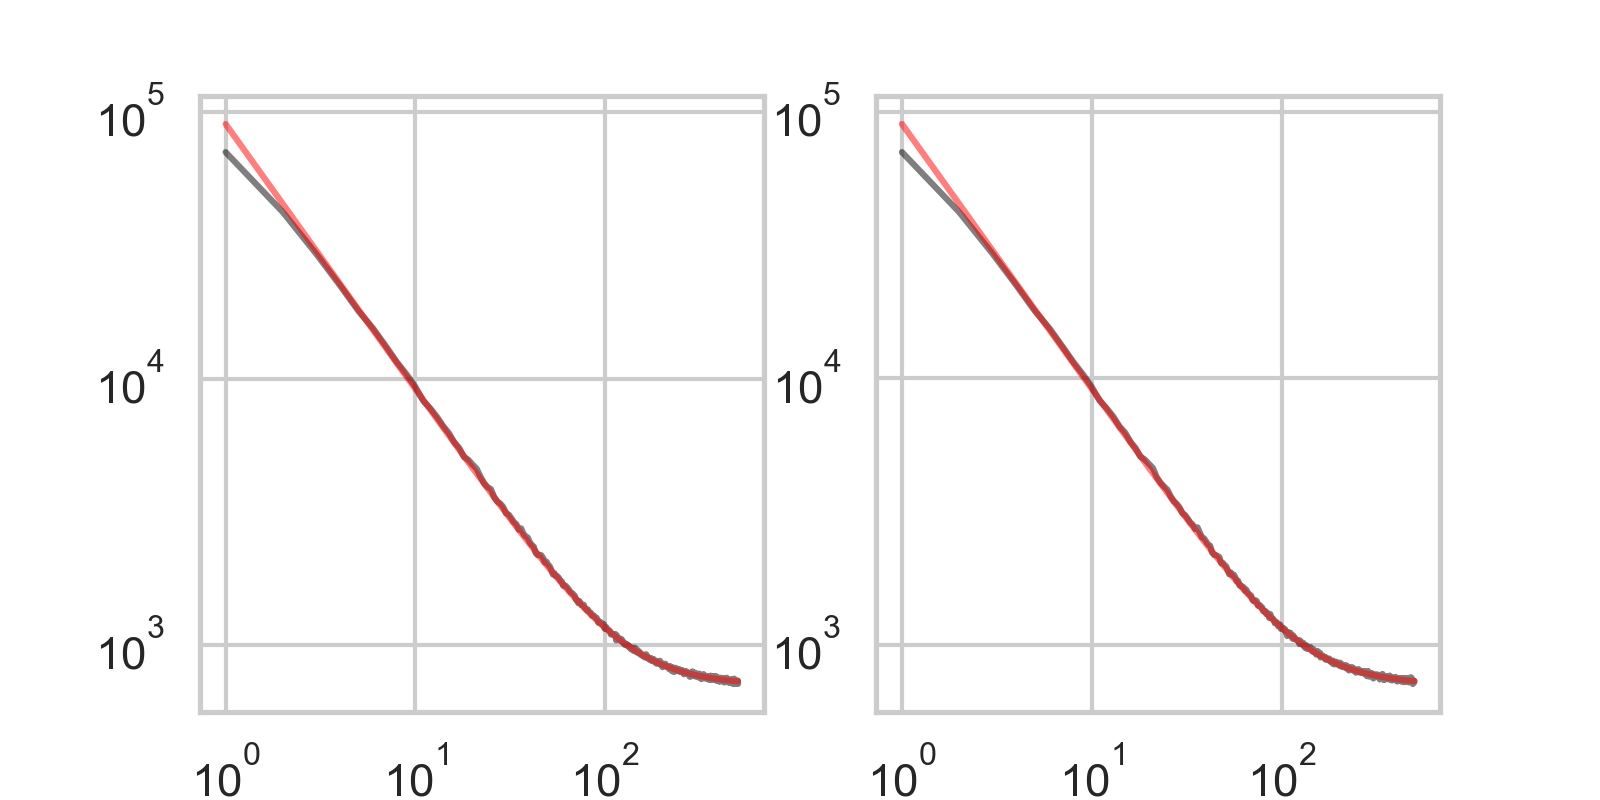

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.plot(avg_ps1.freq[:500], std1, color="black", alpha=0.5)
ax1.plot(avg_ps1.freq[:500], np.sqrt(model_var[:500]), color="red", alpha=0.5)

ax2.plot(avg_ps1.freq[:500], std2, color="black", alpha=0.5)
ax2.plot(avg_ps1.freq[:500], np.sqrt(model_var[:500]), color="red", alpha=0.5)

ax1.set_xscale("log")
ax1.set_yscale("log")

ax2.set_xscale("log")
ax2.set_yscale("log")

In [91]:
x1 = np.linspace(-1e9, 2e9, 10000)
bprob1 = bessel_probability_corr(x1, model_std[10], model_std[10], corr_coeff_real[10])


x2 = np.linspace(-1e6, 2e7, 10000)
bprob2 = bessel_probability_corr(x2, model_std[50],model_std[50], corr_coeff_real[50])

x3 = np.linspace(-2500000, 2500000, 10000)
bprob3 = bessel_probability_corr(x3, model_std[499], model_std[499], corr_coeff_real[499])


In [92]:
freqs[499]

500.0

In [94]:
fourier_squared_test.shape

(5000, 1500)

<IPython.core.display.Javascript object>


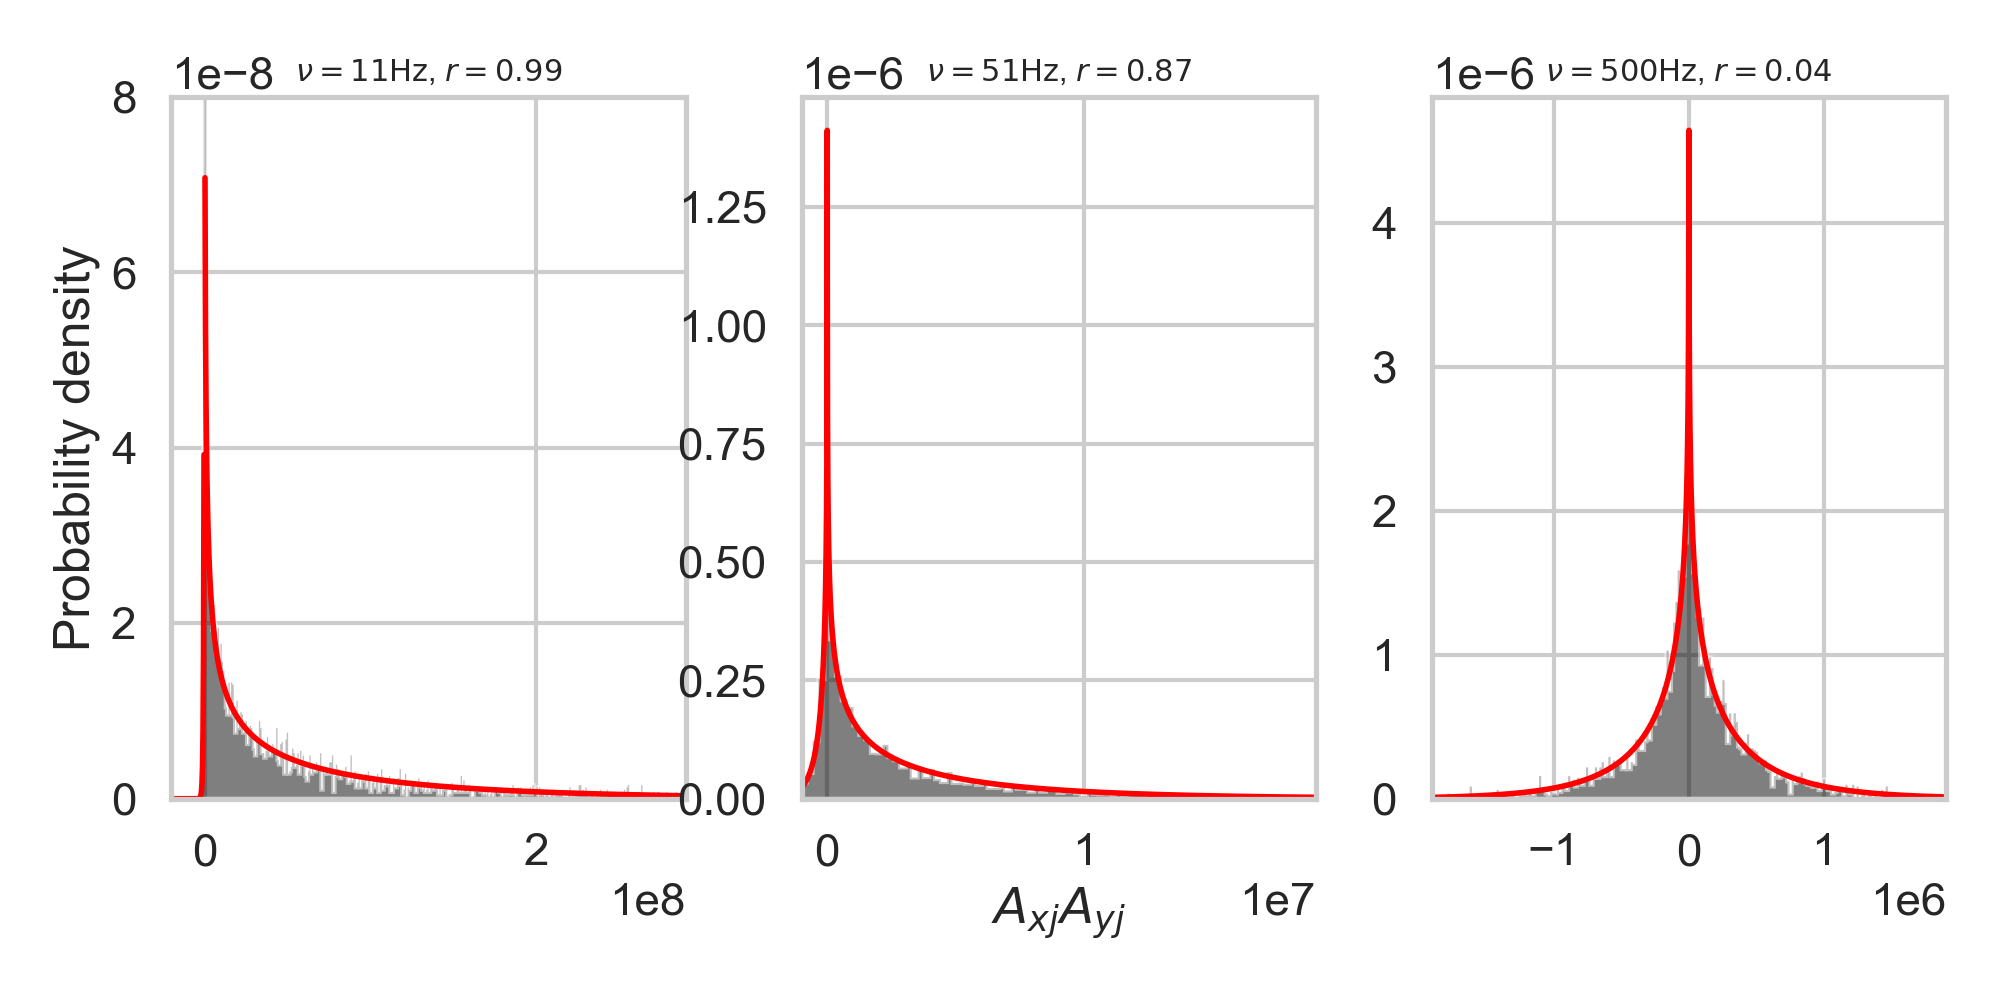

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.hist(fourier_squared_test[:, 10].real, bins=400, range=[-2e7, 3e8], alpha=0.5, 
         color="black", density=True, histtype="stepfilled")
#ax1.hist(fourier_squared_test_lc1[:, 1].real, bins=100, alpha=0.5, color="purple")
ax1.plot(x1, bprob1, lw=2, color="red")
ax1.set_xlim(-2e7,2.9e8)
ax1.set_ylim(0, 8e-8)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax1.set_title(r"$\nu = 11 \mathrm{Hz}$, $r = %.2f$"%corr_coeff_real[10], fontsize=11)

ax2.hist(fourier_squared_test[:, 50].real, bins=400, alpha=0.5, 
         color="black", density=True, histtype="stepfilled")
#ax2.hist(fourier_squared_test_lc1[:, 10].real, bins=100, alpha=0.5, color="purple")
ax2.plot(x2, bprob2, lw=2, color="red")
ax2.set_xlim(-1e6, 1.9e7)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax2.set_title(r"$\nu = 51 \mathrm{Hz}$, $r = %.2f$"%corr_coeff_real[50], fontsize=11)


ax2.set_xlabel(r"$A_{xj}A_{yj}$")
ax1.set_ylabel("Probability density")

ax3.hist(fourier_squared_test[:, 499].real, bins=400, 
         alpha=0.5, color="black", density=True, histtype="stepfilled")
ax3.plot(x3, bprob3, lw=2, color="red")
ax3.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
ax3.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
ax3.set_xlim(-1.9e6, 1.9e6)

ax3.set_title(r"$\nu = 500 \mathrm{Hz}$, $r = %.2f$"%corr_coeff_real[499], fontsize=11)

plt.tight_layout(w_pad=0.35)
plt.savefig("rednoise_bessel.pdf", format="pdf")

Okay, this seems to work in principle. It just gets really dicey for very high values of the correlation.

## Two Solutions for Cospectral distributions

There are two possible solutions to this problem for cospectra. [This paper](https://www.sciencedirect.com/science/article/pii/S1631073X15002873) and [this paper](https://onlinelibrary.wiley.com/doi/full/10.1111/stan.12152) derive the exact distribution for the product of two correlated Gaussian variables, based on [Cui et al (2016)](https://ieeexplore.ieee.org/abstract/document/7579552). This in itself doesn't help, but they *also* derive the *mean* of $n$ IID variables, and the cospectrum can be considered as the sum of two IID variables with the distribution given in those papers.

Using these results, we have for the distribution of the product of two variables

$$
f_Z(x) = \frac{1}{\pi \sigma_X \sigma_Y \sqrt{1 - \rho^2}} \exp{\left(\frac{\rho x}{\sigma_X \sigma_Y (1 - \rho^2)} \right)} K_0\left(\frac{|x|}{\sigma_X \sigma_Y (1-\rho^2)}  \right)
$$

where $\rho$ is the correlation coefficient:

$$
\rho = \frac{P_j}{P_j + 2}
$$

with $P_j = P(\nu_j)$ is the power spectrum at frequency $\nu_j$.

Let's try to code this into a function:

In [107]:
from scipy.special import kv

In [385]:
def fourier_product_probability(x, std1, std2, corr):
    corr_fac = (1 - corr**2.)
    pre_term = 1 / (np.pi * std1 * std2 * np.sqrt(corr_fac))
    exp_term = np.exp((corr * x) / (std1 * std2 * corr_fac))
    bessel_fac = np.abs(x) / (std1 * std2 * corr_fac)
    bessel_term = scipy.special.kv(0, bessel_fac)
    
    return pre_term * exp_term * bessel_term

<IPython.core.display.Javascript object>


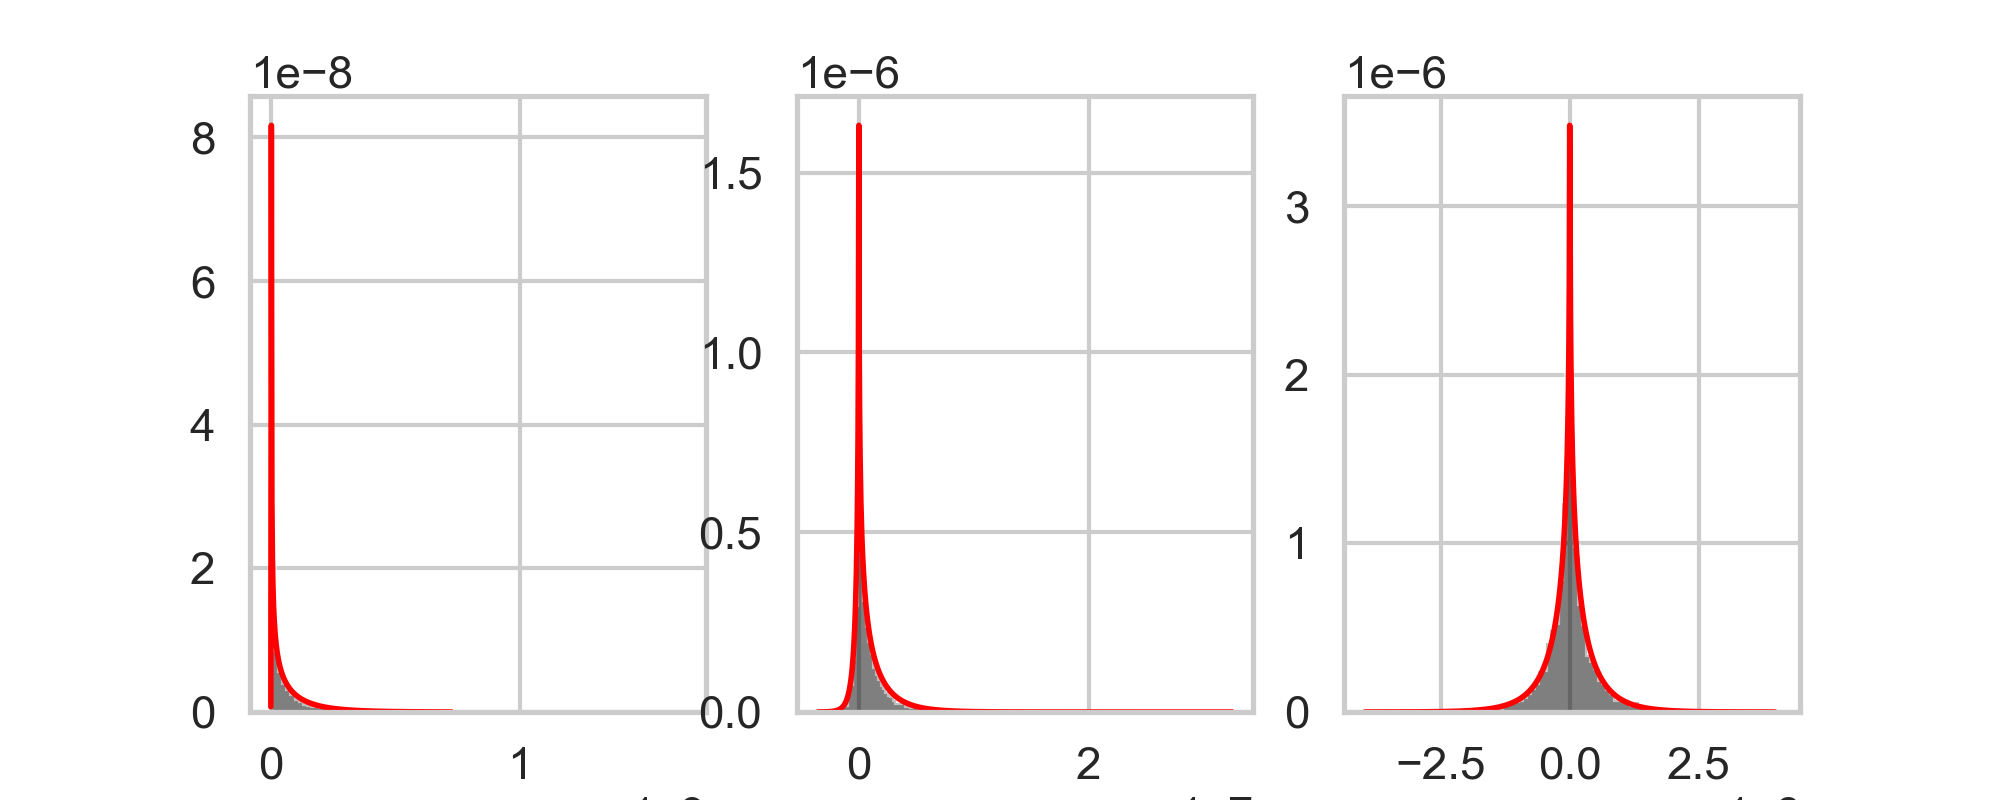

In [386]:
nfig = 3
idx_all = [10, 100, 1498]

fig, axes = plt.subplots(1, nfig, figsize=(10,4))

for i in range(nfig):
    # get the correct index
    idx = idx_all[i]

    # calculate minimum and maximum of the CSD powers
    min_val = np.min(csd_all[:,idx])
    max_val = np.max(csd_all[:,idx])

    # generate an array of x-values
    x = np.linspace(min_val, max_val, 1000)

    # calculate the cospectra probability
    probs = fourier_product_probability(x, model_std[idx], model_std[idx], corr_coeff_real[idx])

    axes[i].hist(fourier_squared_test[:,idx], bins=100, histtype="stepfilled", alpha=0.5, color="black", 
            density=True);
    axes[i].plot(x, probs, lw=2, color="red")

Ok, that looks about right. We can also write down the probability for an *average* of independent products like the one above. This isn't quite the right distribution, because the variables are *not* independent, but let's see how well this one does.

The equation for $n$ averaged products of correlated normal variables $Z$, for $n \geq 2$, is:

$$
f_{\bar{Z}}(x) = \frac{n^{(n+1)/2}2^{(1-n)/2}|x|^{(n-1)/2}}{(\sigma_X \sigma_Y)^{(n+1)/2}\sqrt{\pi(1-\rho^2)}\Gamma(n/2)}\exp{\left( \frac{\rho n x}{\sigma_X \sigma_Y (1 - \rho^2)} \right)} K_{\frac{n-1}{2}}\left( \frac{n |x|}{\sigma_X \sigma_Y (1 - \rho^2)} \right)
$$

Where $n$ is the number of averaged variables. Let's implement that one and deal with factors of two afterwards:

In [407]:
def avg_product_probability_corr(x, n, std1, std2, corr):
    """
    Probability distribution for the average of independent variables, 
    each of which is the product of correlated, zero-mean Gaussian 
    variables, Z = X*Y.
    
    Parameters
    -----------
    x : numpy.ndarray
        dependent variable
    
    n : int
        The number of averaged variables
        
    std1, std2 : float
        The standard deviation of X and Y
        
    corr : float
        The Pearson correlation coefficient between X and Y

    Returns
    -------
    prob : numpy.ndarray
        The probability distribution for the average
    """
    both_std = std1 * std2 
    corr_fac = (1. - corr ** 2.)
    
    nterm = n**((n+1)/2.)
    twoterm = 2.**((n-1)/2.)
    xterm = np.abs(x)**((n-1)/2)
    
    first_term_nom = nterm * twoterm * xterm
    
    sig_fac = (both_std) ** ((n+1)/2.)
    sqrt_fac = np.sqrt(np.pi * corr_fac)
    gamma_fac = scipy.special.gamma(n/2.)
    
    first_term_denom = sig_fac * sqrt_fac * gamma_fac
    first_term = first_term_nom / first_term_denom
    
    exp_term = np.exp((corr * n * x) / (both_std * corr_fac))
    
    bessel_fac = (n * np.abs(x)) / (both_std * corr_fac)
    bessel_term = scipy.special.kv((n-1)/2. , bessel_fac)
    
    return first_term * exp_term * bessel_term
    

<IPython.core.display.Javascript object>


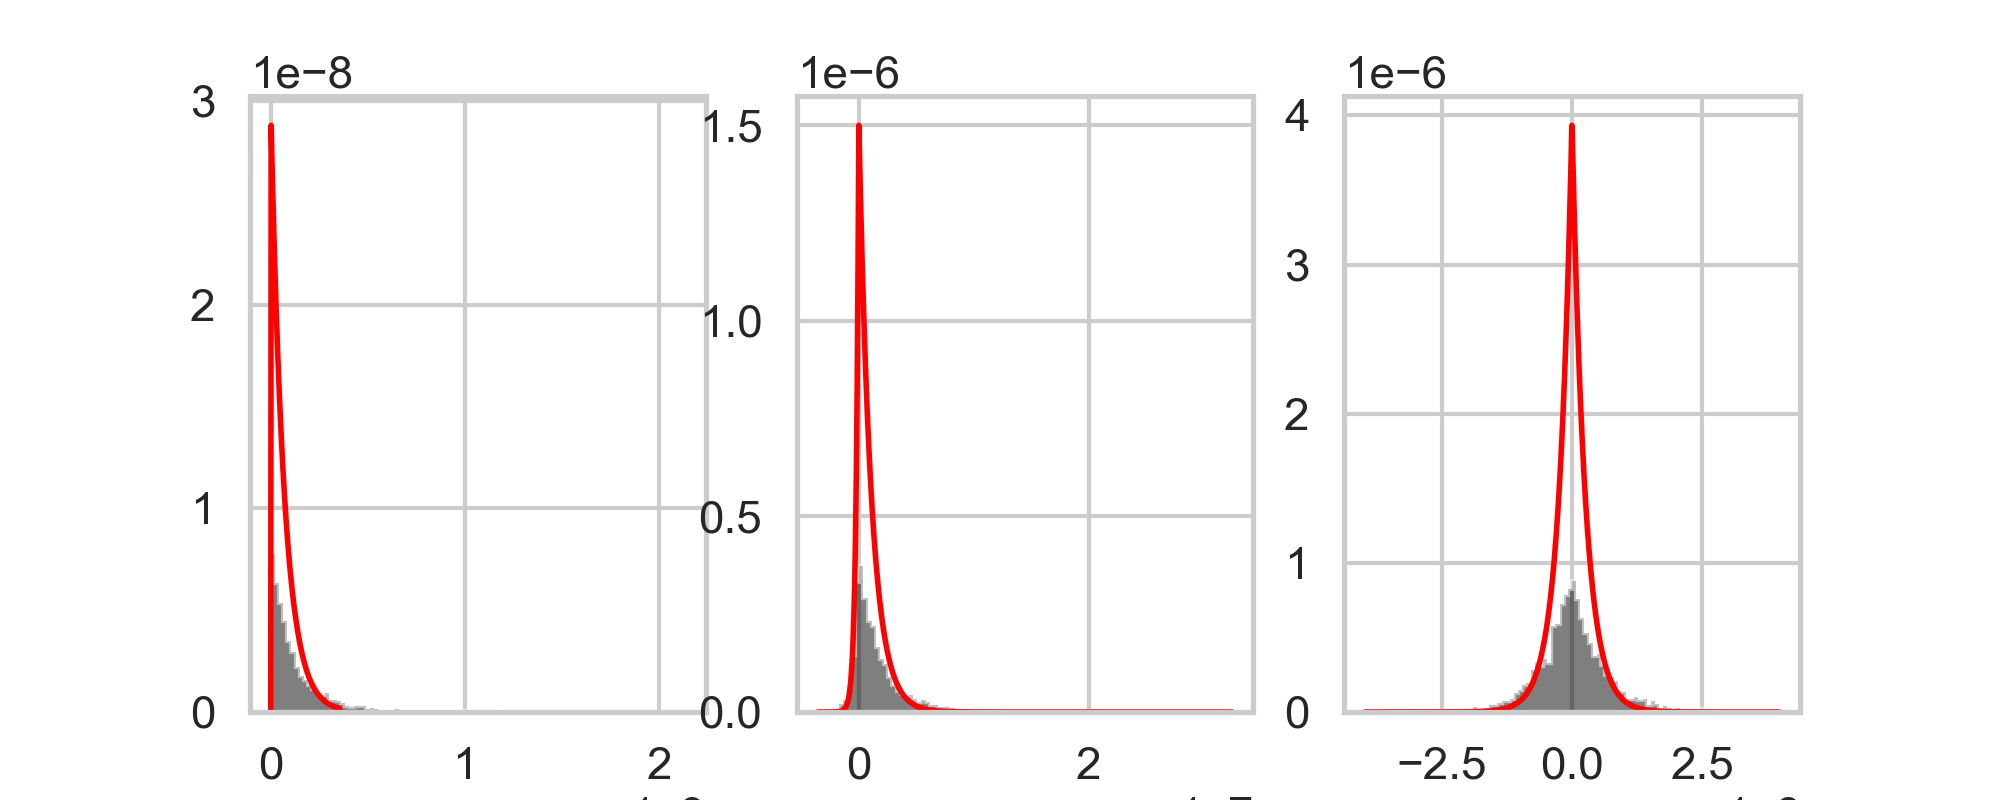

In [408]:
nfig = 3
idx_all = [10, 100, 1498]

fig, axes = plt.subplots(1, nfig, figsize=(10,4))

for i in range(nfig):
    # get the correct index
    idx = idx_all[i]

    # calculate minimum and maximum of the CSD powers
    min_val = np.min(csd_all[:,idx])
    max_val = np.max(csd_all[:,idx])

    # generate an array of x-values
    x = np.linspace(min_val, max_val, 1000)

    # calculate the cospectra probability
    probs = avg_product_probability_corr(x, 2, model_std[idx], model_std[idx], corr_coeff_real[idx])

    axes[i].hist(csd_all[:,idx], bins=100, histtype="stepfilled", alpha=0.5, color="black", 
            density=True);
    axes[i].plot(x, probs, lw=2, color="red")

This doesn't look right, but it also shouldn't, because it's the probability for the *average* of variables, not the sum. We can use the properties of the variance-gamma distribution to compute what the sum of the distribution should be.

Specifically, for the VG distribution

$$
aW_1 \sim \mathrm{VG}(r, a\theta, a\sigma, 0)
$$

for a scalar $a$. Because the sum $Z_s = n \bar{Z}$, we can derive the distribution for that sum using the VG distribution for the average and the property above:

$$
f_{n\bar{Z}}(x) = \frac{|x|^{(n-1)/2} 2^{(1-n)/2}}{\Gamma(n/2) (\sigma_X \sigma_Y)^{(1+n)/2} \sqrt{\pi (1-\rho^2)}} \exp{\left( \frac{\rho x}{\sigma_X \sigma_Y (1-\rho^2)} \right)} K_{\frac{n-1}{2}}\left(\frac{|x|}{\sigma_X \sigma_Y (1-\rho^2)} \right)
$$

In [409]:
def cospectra_probability_corr(x, n, std1, std2, corr):
    """
    Probability distribution for the sum of independent variables, each of which 
    is the product of a correlated, zero-mean Gaussian variable.
    
    Parameters
    ----------
    x : numpy.ndarray
        dependent variable
    
    n : int
        The number of summed variables
        
    std1, std2 : float
        The standard deviation of X and Y
        
    corr : float
        The Pearson correlation coefficient between X and Y

    Returns
    -------
    prob : numpy.ndarray
        The probability distribution for the sum
    
    """
    both_std = std1 * std2 
    corr_fac = (1. - corr ** 2.)
    
    x_fac = np.abs(x)**((n-1)/2.)
    two_fac = 2. ** ((1-n)/2.)
    
    gamma_fac = scipy.special.gamma(n/2)
    std_fac = both_std ** ((1+n)/2.)
    sqrt_fac = np.sqrt(np.pi * corr_fac)
    
    first_term = x_fac * two_fac / (gamma_fac * std_fac * sqrt_fac)
    
    exp_term = np.exp((corr * x) / (both_std * corr_fac))
    
    bessel_fac = np.abs(x) / (both_std * corr_fac)
    bessel_order = (n-1)/2
    bessel_term = scipy.special.kv(bessel_order, bessel_fac)
    
    prob = first_term * exp_term * bessel_term
    
    return prob

Let's try this one:

<IPython.core.display.Javascript object>


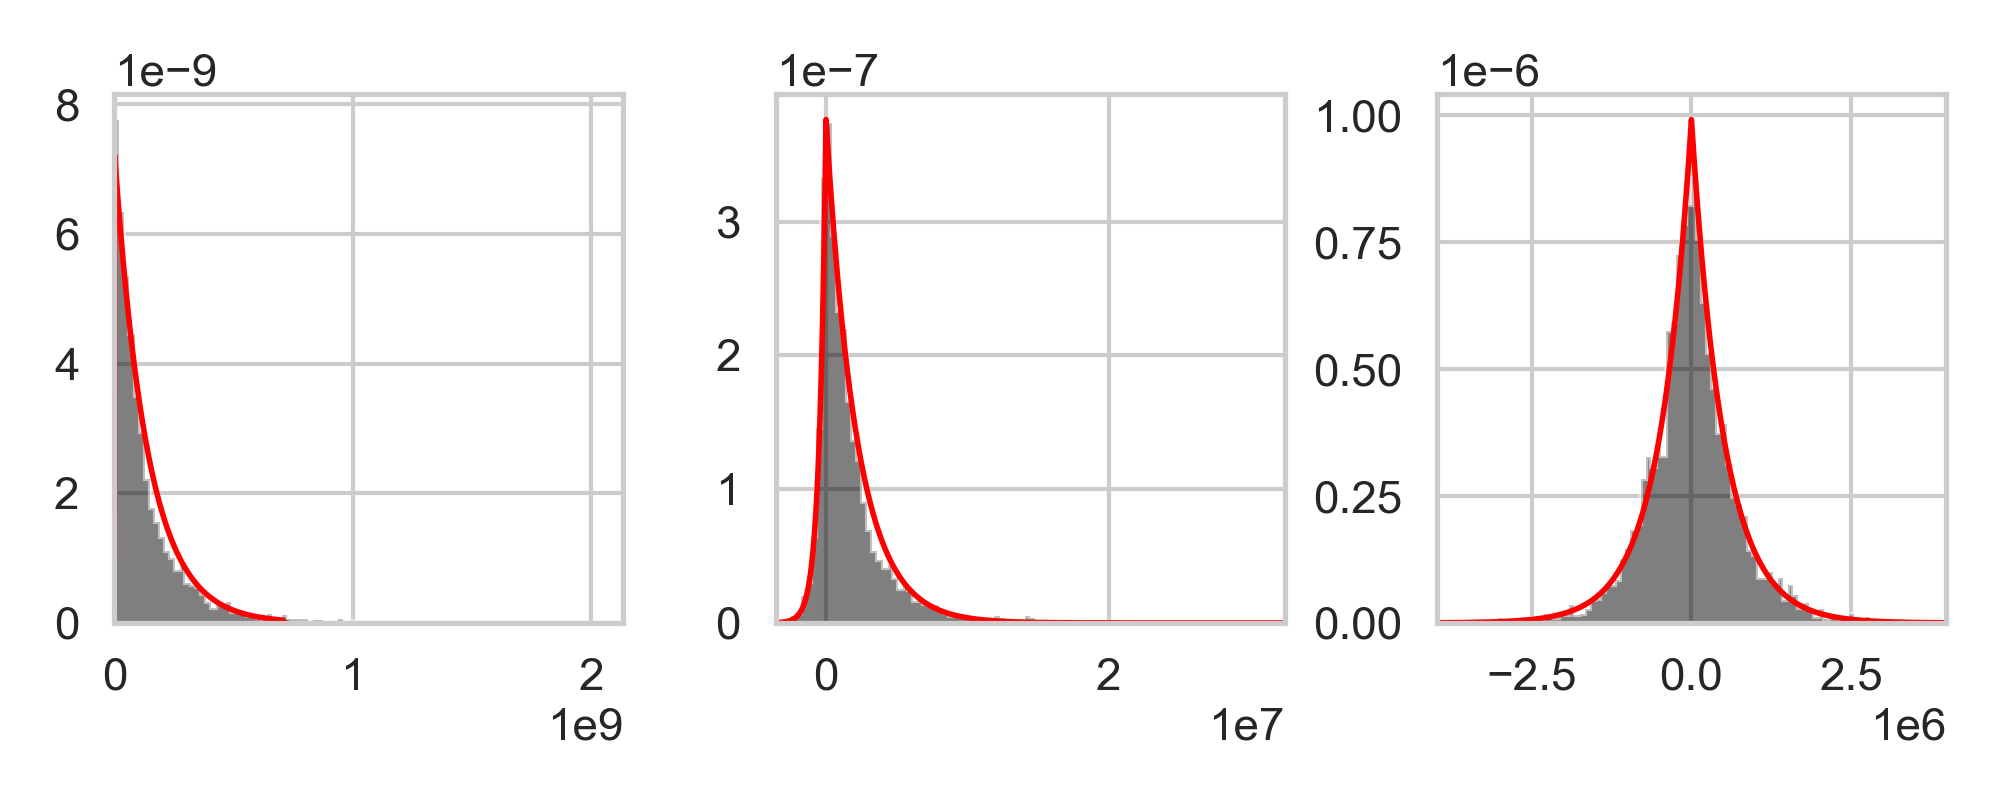

[1.59936256e-10 2.43367329e-10 3.70320389e-10 ...            nan
            nan            nan]
[2.01123319e-10 2.02660672e-10 2.04209776e-10 ... 1.30770896e-13
 1.30555142e-13 1.30339745e-13]
[3.56075798e-10 3.56641475e-10 3.57208052e-10 ... 3.77831315e-10
 3.77236773e-10 3.76643167e-10]


In [418]:
nfig = 3
idx_all = [10, 100, 1498]

fig, axes = plt.subplots(1, nfig, figsize=(10,4))

for i in range(nfig):
    # get the correct index
    idx = idx_all[i]

    # calculate minimum and maximum of the CSD powers
    min_val = np.min(csd_all[:,idx])
    max_val = np.max(csd_all[:,idx])

    # generate an array of x-values
    x = np.linspace(min_val, max_val, 10000)

    # calculate the cospectra probability
    probs = cospectra_probability_corr(x, 2, model_std[idx], model_std[idx], corr_coeff_real[idx])
    print(probs)

    axes[i].hist(csd_all[:,idx], bins=100, histtype="stepfilled", alpha=0.5, color="black", 
            density=True);
    axes[i].plot(x, probs, lw=2, color="red")
    axes[i].set_xlim(min_val, max_val)
    
plt.tight_layout()

That actually does not look bad! Hooray! That's probably a moderately decent approximation in practical circumstances. 

Let's write a log version to help with numerical issues:

In [521]:
def cospectra_probability_corr(x, n, std1, std2, corr, norm=1.0):
    """
    Probability distribution for the sum of independent variables, each of which 
    is the product of a correlated, zero-mean Gaussian variable.
    
    Parameters
    ----------
    x : numpy.ndarray
        dependent variable
    
    n : int
        The number of summed variables
        
    std1, std2 : float
        The standard deviation of X and Y
        
    corr : float
        The Pearson correlation coefficient between X and Y
        
    norm : float
        The normalization of the powers (should probably be a string in practice)

    Returns
    -------
    prob : numpy.ndarray
        The probability distribution for the sum
    
    """
    
    both_std = std1 * std2 
    corr_fac = (1. - corr ** 2.)
    
    first_term = ((n-1) / 2.) * np.log(np.abs(x))
    second_term = ((1-n) / 2.) * np.log(2.)
    gamma_term = -scipy.special.loggamma(n/2.)
    fourth_term = -((1+n) / 2.) * np.log(norm * both_std)
    fifth_term = - 0.5 * np.log(np.pi * corr_fac)
    
    exp_term = corr * x / (norm * both_std * corr_fac)
    
    bessel_fac = np.abs(x) / (norm * both_std * corr_fac)
    bessel_order = (n-1)/2
    bessel_term = np.log(scipy.special.kv(bessel_order, bessel_fac))
    #print("bessel_fac : " + str(bessel_fac))
    #print("bessel_term :  " + str(bessel_term))
    
    log_prob = first_term + second_term + gamma_term + fourth_term + fifth_term + exp_term + bessel_term
    #print(log_prob)
    
    return np.exp(log_prob)

<IPython.core.display.Javascript object>


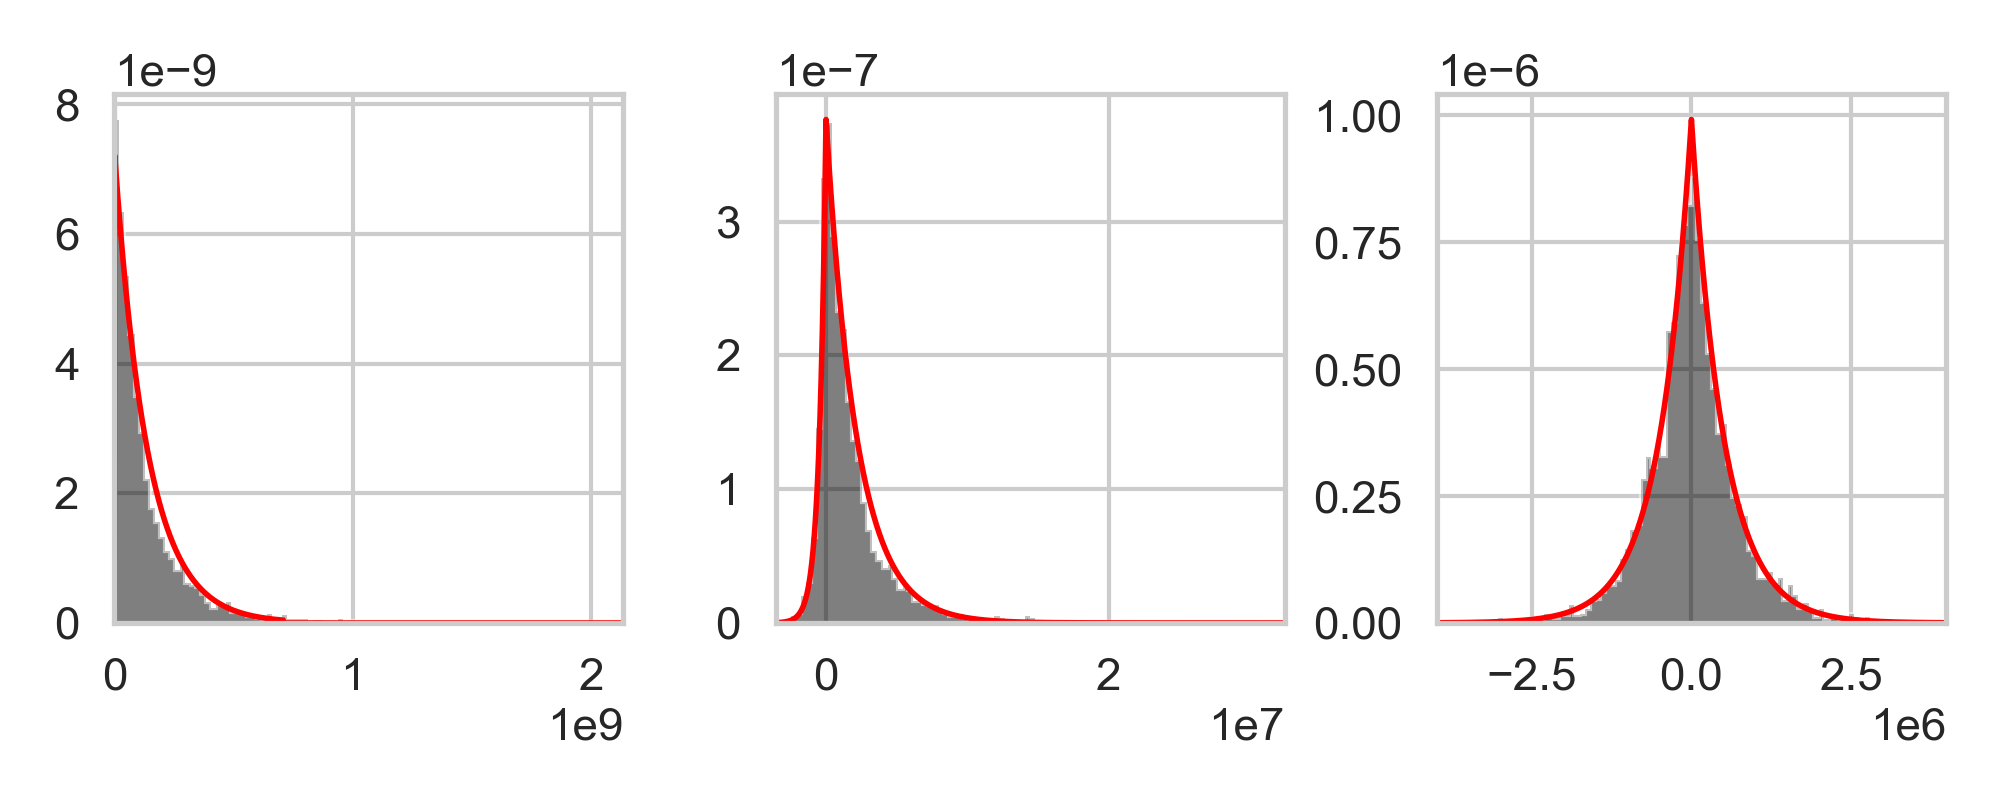

[1.59936256e-10 2.43367329e-10 3.70320389e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[2.01123319e-10 2.02660672e-10 2.04209776e-10 ... 1.30770896e-13
 1.30555142e-13 1.30339745e-13]
[3.56075798e-10 3.56641475e-10 3.57208052e-10 ... 3.77831315e-10
 3.77236773e-10 3.76643167e-10]


In [522]:
nfig = 3
idx_all = [10, 100, 1498]

fig, axes = plt.subplots(1, nfig, figsize=(10,4))

for i in range(nfig):
    # get the correct index
    idx = idx_all[i]

    # calculate minimum and maximum of the CSD powers
    min_val = np.min(csd_all[:,idx])
    max_val = np.max(csd_all[:,idx])

    # generate an array of x-values
    x = np.linspace(min_val, max_val, 10000)

    # calculate the cospectra probability
    probs = cospectra_probability_corr(x, 2, model_std[idx], model_std[idx], corr_coeff_real[idx])
    print(probs)

    axes[i].hist(csd_all[:,idx], bins=100, histtype="stepfilled", alpha=0.5, color="black", 
            density=True);
    axes[i].plot(x, probs, lw=2, color="red")
    axes[i].set_xlim(min_val, max_val)
    
plt.tight_layout()

Ok, so at very large ends, I run into numerical issues, but I don't know that I can avoid that without some reformulation. Let's punt that to later.

**TODO**: Fix numerical instabilities for large values.

#### Comparing Theoretical and measured quantiles

Let's take these three examples, and compare experimental and theoretical quantiles. At very low frequencies, we can compare to the chi-square distribution. It won't be a perfect fit, but at high correlation, the distribution should approximate a periodogram (the two variables are essentially the same, because the intrinsic variability dominates over the white noise). At high frequencies, I should be able to compare to the Laplace distribution, because the spectrum should be dominated by (independent) white noise, and the correlation should be near zero.

I'll start with the high frequencies, because that should be somewhat more straightforward, I think.

In [523]:
idx = 1400

# calculate minimum and maximum of the CSD powers
min_val = np.min(csd_all[:,idx])
max_val = np.max(csd_all[:,idx])

# generate an array of x-values
x = np.linspace(min_val, max_val, 10000)

# calculate the cospectra probability
probs = cospectra_probability_corr(x, 2, model_std[idx], model_std[idx], corr_coeff_real[idx], norm=2./mean_nphot)
print(probs)

[0. 0. 0. ... 0. 0. 0.]


Let's try with the normalization:

<IPython.core.display.Javascript object>


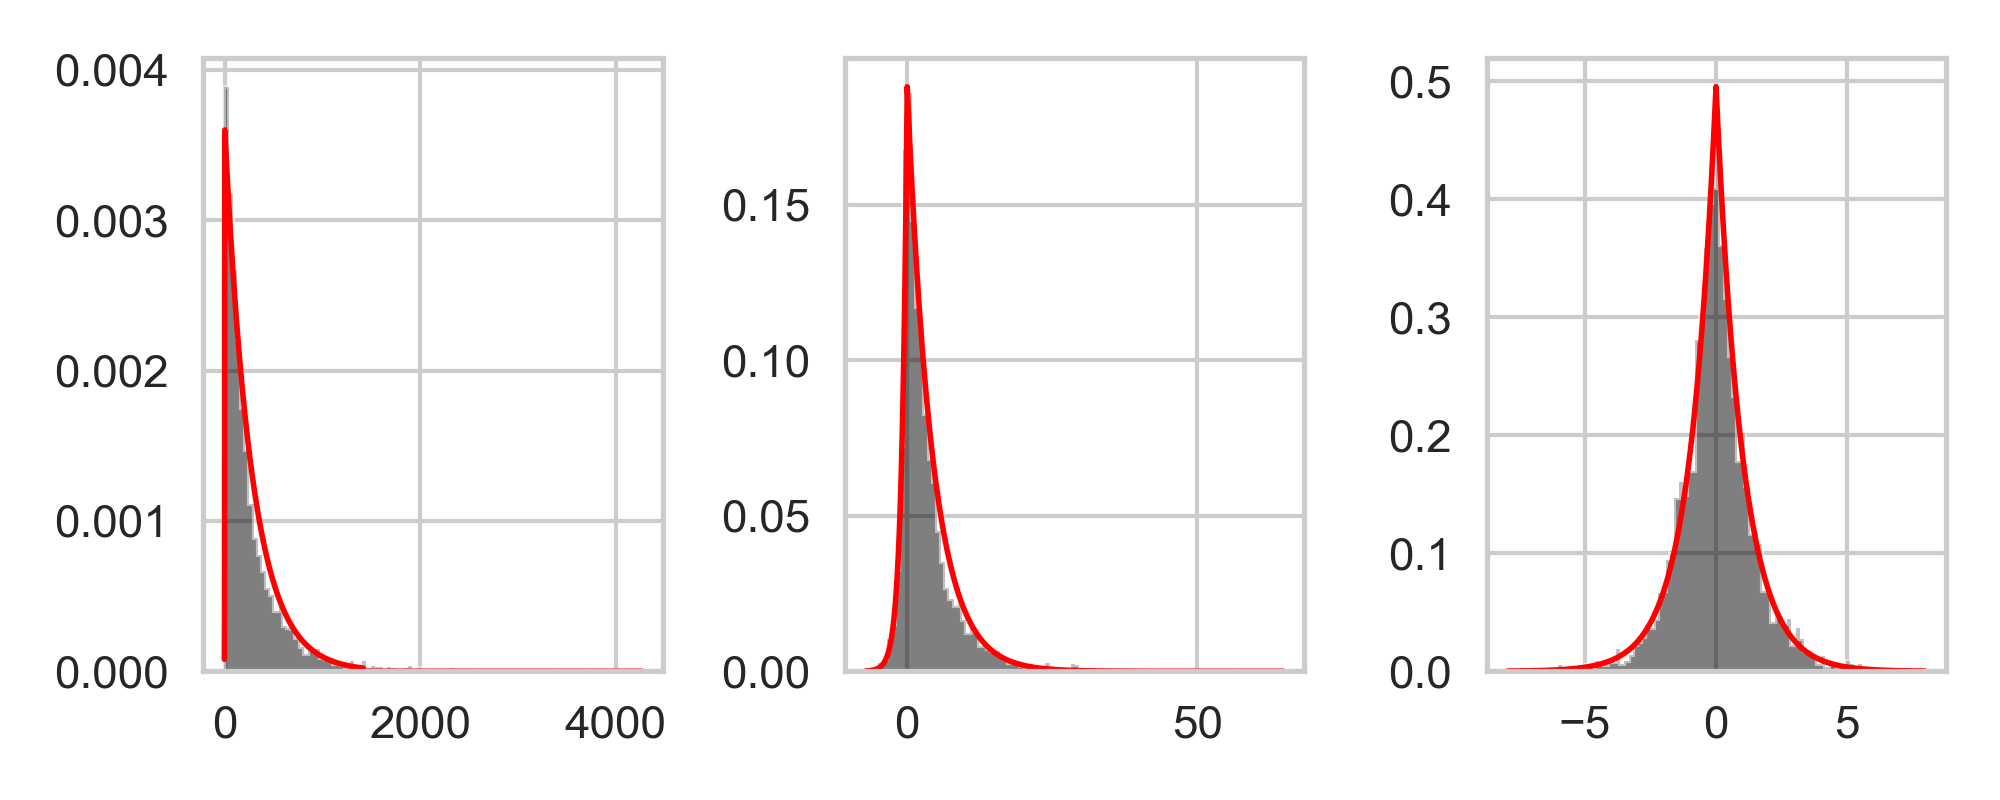

[8.04063530e-05 1.22343611e-04 1.86153938e-04 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[1.02081310e-04 1.02860191e-04 1.03645015e-04 ... 6.70593685e-08
 6.69489293e-08 6.68386719e-08]
[0.0001801  0.00018039 0.00018067 ... 0.00018924 0.00018895 0.00018865]


In [524]:
nfig = 3
idx_all = [10, 100, 1498]

fig, axes = plt.subplots(1, nfig, figsize=(10,4))

for i in range(nfig):
    # get the correct index
    idx = idx_all[i]
    # calculate minimum and maximum of the CSD powers
    min_val = np.min(csd_normed_all[:,idx])
    max_val = np.max(csd_normed_all[:,idx])

    # generate an array of x-values
    x = np.linspace(min_val, max_val, 10000)

    # calculate the cospectra probability
    probs = cospectra_probability_corr(x, 2, model_std[idx], model_std[idx], corr_coeff_real[idx], norm=2./mean_nphot)
    print(probs)

    axes[i].hist(csd_normed_all[:,idx], bins=100, histtype="stepfilled", alpha=0.5, color="black", 
            density=True);
    axes[i].plot(x, probs, lw=2, color="red")
    #axes[i].set_xlim(min_val, max_val)
    
plt.tight_layout()

Let's first compute the cumulative probability from the theoretical expression:

In [525]:
cum_prob = np.cumsum(probs * (x[1] - x[0]))

Let's also compute the empirical version based on the data:

<IPython.core.display.Javascript object>


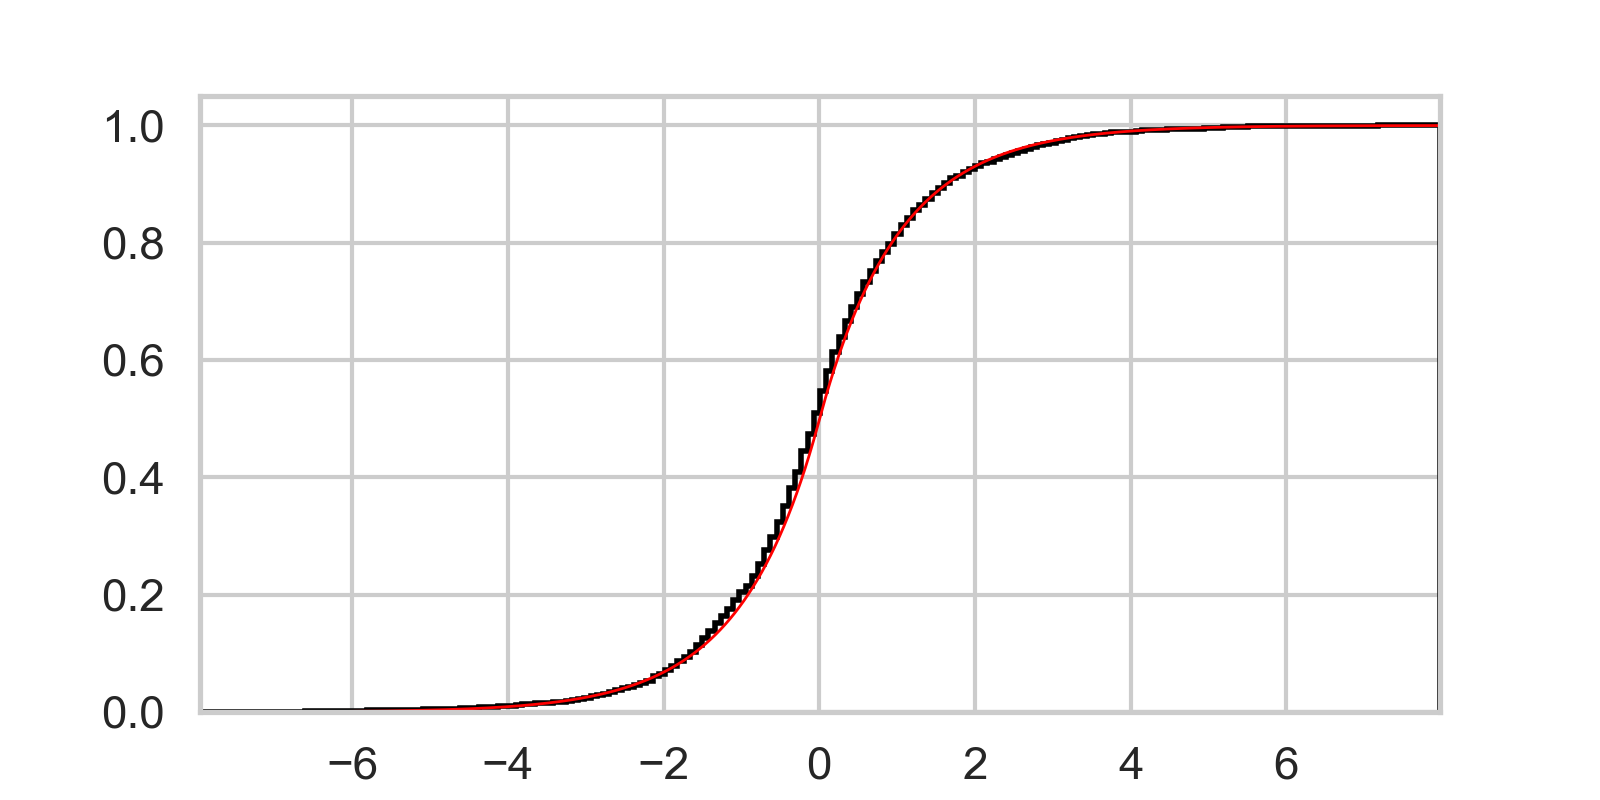

(-7.957099409566644, 7.973700035449711)

In [526]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

# plot the cumulative histogram
n, bins, patches = ax.hist(csd_normed_all[:,idx], 200, lw=2, density=True, histtype='step',
                           cumulative=True, label='Empirical', color="black")
ax.plot(x, cum_prob, lw=1, color="red")
ax.set_xlim(x[0], x[-1])



Okay, let's compute some quantiles:

In [527]:
q_all = [0.5, 2.5, 5.0, 16.0, 50.0, 84.0, 95.0, 97.5, 99.5]

In [528]:
xval = x[cum_prob.searchsorted(q_all[0])]

In [530]:
for q in q_all:
    print(q)
    xval = x[cum_prob.searchsorted(q/100.0)]

0.5
2.5
5.0
16.0
50.0
84.0
95.0
97.5
99.5


In [531]:
xval_all = [x[cum_prob.searchsorted(q/100.0)] for q in q_all[:-1]]

In [532]:
xval_all

[-4.587398356840412,
 -2.998938806217219,
 -2.305879724450831,
 -1.139628579961185,
 0.004317214770462208,
 1.15941568438111,
 2.3400059822866117,
 3.0458109782004277]

Now we can calculate the probability in the CSD contained below these values:

In [535]:
q_emp_all = []

for xval in xval_all:
    q_emp = np.sum((csd_normed_all[:,idx] <= xval)) / len(csd_all[:,idx]) * 100
    q_emp_all.append(q_emp)

In [536]:
for qt, qe in zip(q_all, q_emp_all):
    print("Theoretical: " + str(qt)+  ", empirical: " + str(qe))

Theoretical: 0.5, empirical: 0.5599999999999999
Theoretical: 2.5, empirical: 2.26
Theoretical: 5.0, empirical: 4.64
Theoretical: 16.0, empirical: 17.16
Theoretical: 50.0, empirical: 50.82
Theoretical: 84.0, empirical: 83.6
Theoretical: 95.0, empirical: 94.22
Theoretical: 97.5, empirical: 97.06


Okay, that looks pretty close, probably within errors.

**TODO**: Run this with more simulations!

Let's make a plot of all three distributions:

<IPython.core.display.Javascript object>


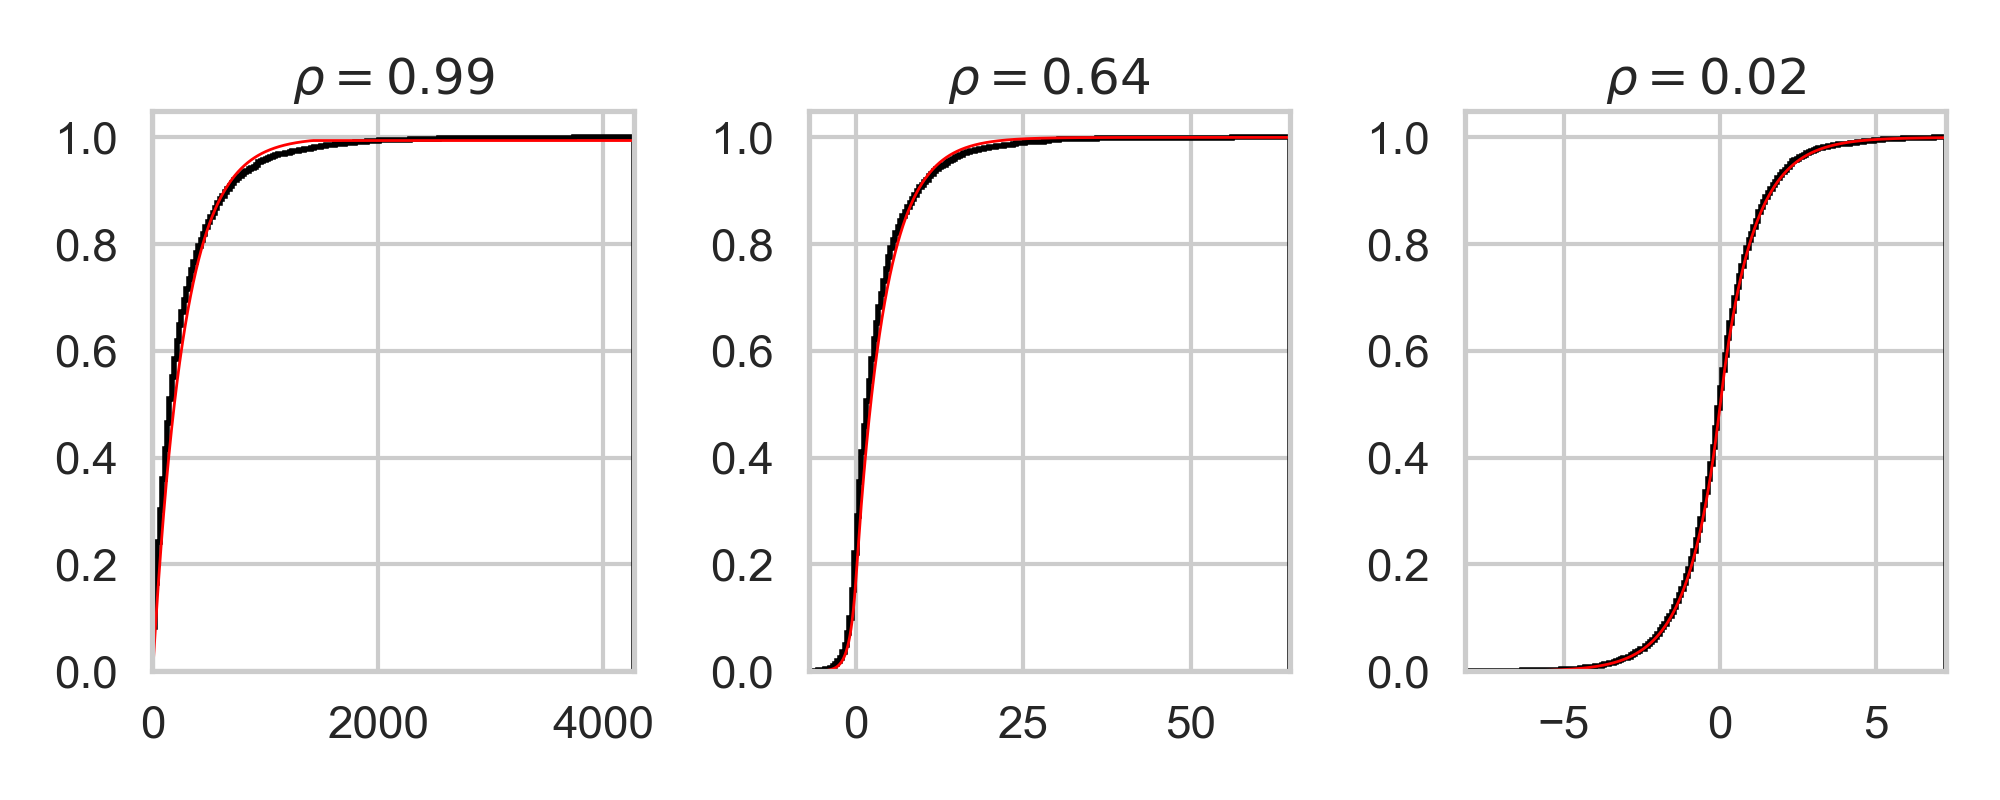

Theoretical: 0.5, empirical: 0.6
Theoretical: 2.5, empirical: 3.38
Theoretical: 5.0, empirical: 6.619999999999999
Theoretical: 16.0, empirical: 19.8
Theoretical: 50.0, empirical: 55.46
Theoretical: 84.0, empirical: 83.89999999999999
Theoretical: 95.0, empirical: 93.5
Theoretical: 97.5, empirical: 95.88


Theoretical: 0.5, empirical: 0.76
Theoretical: 2.5, empirical: 3.16
Theoretical: 5.0, empirical: 5.76
Theoretical: 16.0, empirical: 18.52
Theoretical: 50.0, empirical: 53.82
Theoretical: 84.0, empirical: 84.88
Theoretical: 95.0, empirical: 94.0
Theoretical: 97.5, empirical: 96.32


Theoretical: 0.5, empirical: 0.52
Theoretical: 2.5, empirical: 2.52
Theoretical: 5.0, empirical: 4.9799999999999995
Theoretical: 16.0, empirical: 16.02
Theoretical: 50.0, empirical: 50.03999999999999
Theoretical: 84.0, empirical: 83.5
Theoretical: 95.0, empirical: 95.42
Theoretical: 97.5, empirical: 97.64




In [542]:
fig, axes = plt.subplots(1, 3, figsize=(10,4))

idx_all = [10, 100, 1400]

for i,idx in enumerate(idx_all):
    
    # calculate minimum and maximum of the CSD powers
    min_val = np.min(csd_normed_all[:,idx])
    max_val = np.max(csd_normed_all[:,idx])

    # generate an array of x-values
    x = np.linspace(min_val, max_val, 10000)

    # calculate the cospectra probability
    probs = cospectra_probability_corr(x, 2, model_std[idx], model_std[idx], 
                                       corr_coeff_real[idx], norm=2./mean_nphot)

    cum_prob = np.cumsum(probs * (x[1] - x[0]))


    # plot the cumulative histogram
    n, bins, patches = axes[i].hist(csd_normed_all[:,idx], 200, lw=2, density=True, histtype='step',
                               cumulative=True, label='Empirical', color="black")
    axes[i].plot(x, cum_prob, lw=1, color="red")

    axes[i].set_xlim(x[0], x[-1])
    axes[i].set_title(r"$\rho = %.2f$"%corr_coeff_real[idx])

    # compute and print quantiles
    xval_all = [x[cum_prob.searchsorted(q/100.0)] for q in q_all[:-1]]
    q_emp_all = []

    for xval in xval_all:
        q_emp = np.sum((csd_normed_all[:,idx] <= xval)) / len(csd_all[:,idx]) * 100
        q_emp_all.append(q_emp)
    for qt, qe in zip(q_all, q_emp_all):
        print("Theoretical: " + str(qt)+  ", empirical: " + str(qe))

    print("\n")
plt.tight_layout()

### Turning this equation into a likelihood

Let's turn this into a likelihood so we can start doing some inference on the cospectrum:

In [666]:
def cospectra_loglikelihood(pars, model, freq, cobs, m, nphot, norm):
    """
    Approximate likelihood for the cospectrum.
    
    This calculates an approximate likelihood for the cospectrum according 
    to Theorem 1 in Gaunt, 2019. 
    
    Parameters
    ----------
    pars : iterable
        List of parameters for `model`
        
    model : function
        A model function to compute the model power spectrum
        
    freq : numpy.ndarray
        A list of frequencies for which to compute the likelihood
    
    cobs : numpy.ndarray
        Observed cospectral powers
    
    m : int
        Number of averaged periodograms
    
    nphot : int
        Total number of photons per cospectrum segment
    
    norm : float
        Normalization factor of the likelihood
    
    """
    # compute the model powers
    pmod = model(freq, pars)
    #print("pmod: " + str(pmod))
    
    # number of added variables = 2m
    n = 2. * m
    # both X and Y have the same theoretical standard deviation
    # since I'm mostly working with the product of the two in 
    # the likelihood, I can set the product of the standard deviations
    # to be equal to the variance of either
    std_both = (pmod + 2.) * nphot / 4.0
    
    # correlation coefficient based on the PSD estimate
    corr = pmod / (pmod + 2.)
    corr_term = 1. - (corr ** 2.)
    
    # number of points in the periodogram
    npoints = cobs.shape[0]
    
    
    ## NOTE: None of the prefactor depend on Pobs or Pmod
    ## These could be pulled out of the function entirely 
    ## for computational efficiency
    # first term in the prefactor
     # second term in the prefactor
    p2 = ((1-n)/2.) * np.log(2.)
    #print("p2 : " + str(p2))
    # third term in the prefactor
    p3 = -scipy.special.loggamma(n/2.)
    #print("p3: " + str(p3))
    
    first_term = npoints * (p2 + p3)
    
    #### terms in the sum
    # first term
    p1 = ((n-1)/2.) * np.log(np.abs(cobs))
    t1 = -0.5 * np.log(np.pi * corr_term)
    #print("t1 : " + str(t1))
    t2 = -((1+n)/2.) * np.log(norm * std_both)
    #print("t2: " + str(t2))
    t3 = corr * cobs / (norm * std_both * corr_term)
    #print("t3: " + str(t3))
    bessel_fac = np.abs(cobs) / (norm * std_both * corr_term)
    #print("bessel_fac: " + str(bessel_fac))
    k = m - 1
    order = k + 0.5
    log_b1 = 0.5 * np.log(np.pi / (2.*bessel_fac))
    log_b2 = -bessel_fac
    
    idx = np.arange(0, m, 1) 
    bessel_terms = np.zeros((len(idx), npoints))
    for i in idx:
        b3_nom = scipy.special.factorial(k+i) 
        b3_denom = (scipy.special.factorial(i) * scipy.special.factorial(k-i) * (2*bessel_fac)**i)
        bessel_terms[i,:] = b3_nom / b3_denom

    log_b3 = np.log(np.sum(bessel_terms, axis=0))
    
    t4 = log_b1 + log_b2 + log_b3
    #t4 = np.log(scipy.special.kv(order, bessel_fac))
    #print("t4: " + str(t4))
    
    sum_term = np.sum(p1 + t1 + t2 + t3 + t4)
    
    return first_term + sum_term

Okay, let's try it out. I think I'm going to calculate the likelihood as a function of the spectral index, keeping the amplitude fixed:

In [667]:
from astropy.modeling.fitting import _fitter_to_model_params

In [668]:
mrn_new = models.PowerLaw1D()
mrn_new.x_0.fixed=True

def powerlaw(x, pars):
    _fitter_to_model_params(mrn_new, pars)
    
    return mrn_new(x)

In [669]:
nvals = 200

amp = np.ones(nvals) * res_rn.p_opt[0]
pidx = np.linspace(0.5, 3.5, nvals)

pars_all = np.vstack([amp, pidx]).T
print(pars_all[:5])

[[3.27539299e+04 5.00000000e-01]
 [3.27539299e+04 5.15075377e-01]
 [3.27539299e+04 5.30150754e-01]
 [3.27539299e+04 5.45226131e-01]
 [3.27539299e+04 5.60301508e-01]]


In [670]:
llike_test = cospectra_loglikelihood([res_rn.p_opt[0], 2.0], powerlaw, freqs[:1500], 
                                     csd_normed_all[1], 1, mean_nphot, 2./mean_nphot)

In [671]:
llike_all = []

for p in pars_all:
    ll = cospectra_loglikelihood(p, powerlaw, freqs[:1500], 
                                 csd_normed_all[1], 1, mean_nphot, 2./mean_nphot)
    llike_all.append(ll)

llike_all = np.array(llike_all)

<IPython.core.display.Javascript object>


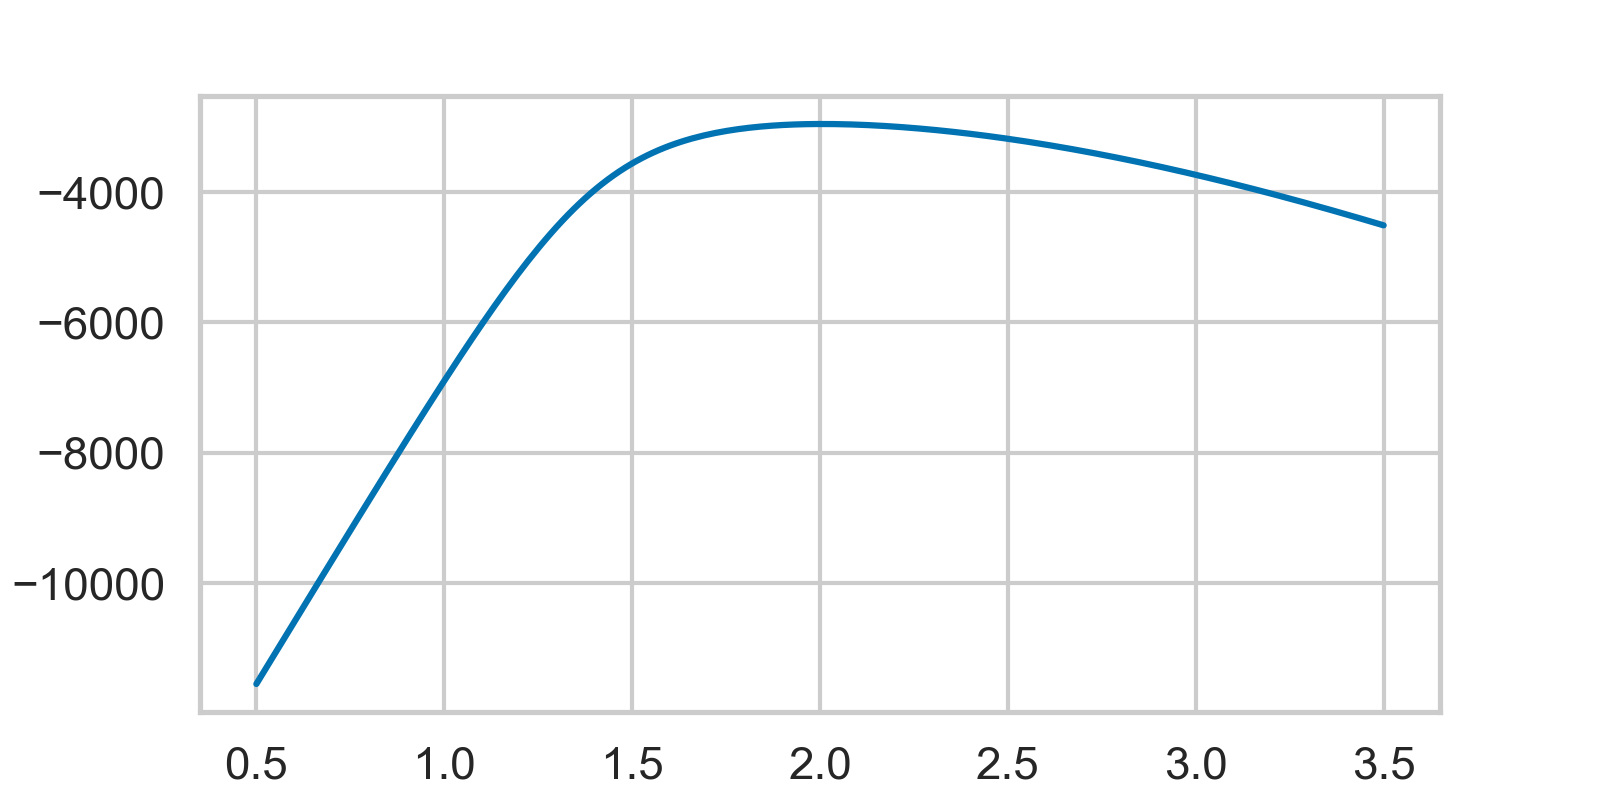

In [672]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(pars_all[:,1], llike_all)


That looks pretty good! I'd like to do the same for the power spectrum likelihood:

In [673]:
#fourier1_all_rn = np.array(fourier1_all_rn)
#lc1_counts_all_rn = np.array(lc1_counts_all_rn)

#avg_ps1_rn = AveragedPowerspectrum(lc1_all_rn, segment_size=lc1_all_rn[0].tseg, norm="leahy")

mrn = models.PowerLaw1D() + models.Const1D()
mrn.x_0_0.fixed=True

loglike_rn = PSDLogLikelihood(freqs[:1500],  csd_normed_all[1], model=mrn, m=1)

In [674]:
amp = np.ones(nvals) * res_rn.p_opt[0]
wn = np.ones(nvals) * 2.0
pidx = np.linspace(0.5, 3.5, nvals)

pars_ps_all = np.vstack([amp, pidx, wn]).T

In [675]:
llike_ps_all = []

for p in pars_ps_all:
    ll = loglike_rn(p, neg=False)
    llike_ps_all.append(ll)
    
llike_ps_all = np.array(llike_ps_all)

<IPython.core.display.Javascript object>


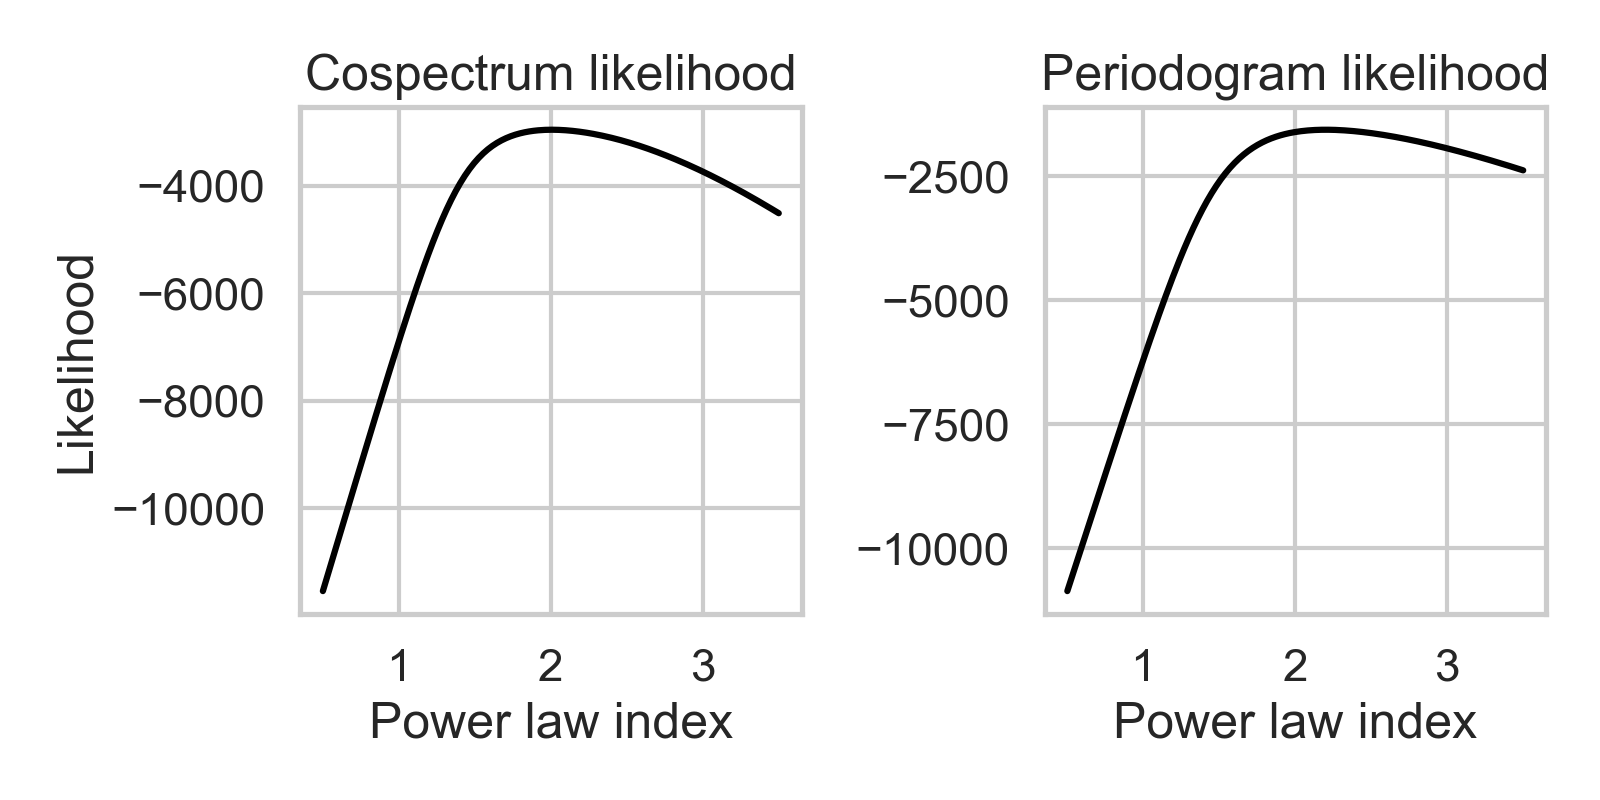

In [676]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.plot(pars_all[:,1], llike_all, color="black")
ax1.set_xlabel("Power law index")
ax1.set_ylabel("Likelihood")
ax1.set_title("Cospectrum likelihood")

ax2.plot(pars_ps_all[:,1], llike_ps_all, color="black")
ax2.set_xlabel("Power law index")
ax2.set_title("Periodogram likelihood")
plt.tight_layout()

Let's also try this for the averaged periodogram:

In [677]:
len(lc1_all)

5000

In [695]:
avg_ps1 = AveragedPowerspectrum(lc1_all[:20], segment_size=lc1_all[0].tseg, norm="leahy")

20it [00:00, 477.59it/s]


In [696]:
from stingray import AveragedCrossspectrum

In [697]:
avg_cs1 = AveragedCrossspectrum(lc1_all[:20], lc2_all[:20], segment_size=lc1_all[0].tseg, norm="leahy")

20it [00:00, 180.02it/s]
20it [00:00, 242.14it/s]
20it [00:00, 226.50it/s]


In [698]:
len(avg_cs1.freq)

4999

In [699]:
llike_avg_all = []

for p in pars_all:
    ll = cospectra_loglikelihood(p, powerlaw, avg_cs1.freq[:1500], 
                                 avg_cs1.power[:1500], avg_cs1.m, mean_nphot, 2./mean_nphot)
    llike_avg_all.append(ll)

llike_avg_all = np.array(llike_avg_all)

In [701]:
loglike_rn = PSDLogLikelihood(avg_ps1.freq[:1500], avg_ps1.power[:1500], 
                              model=mrn, m=avg_ps1.m)
llike_aps_all = []

for p in pars_ps_all:
    ll = loglike_rn(p, neg=False)
    llike_aps_all.append(ll)
    
llike_aps_all = np.array(llike_aps_all)

<IPython.core.display.Javascript object>


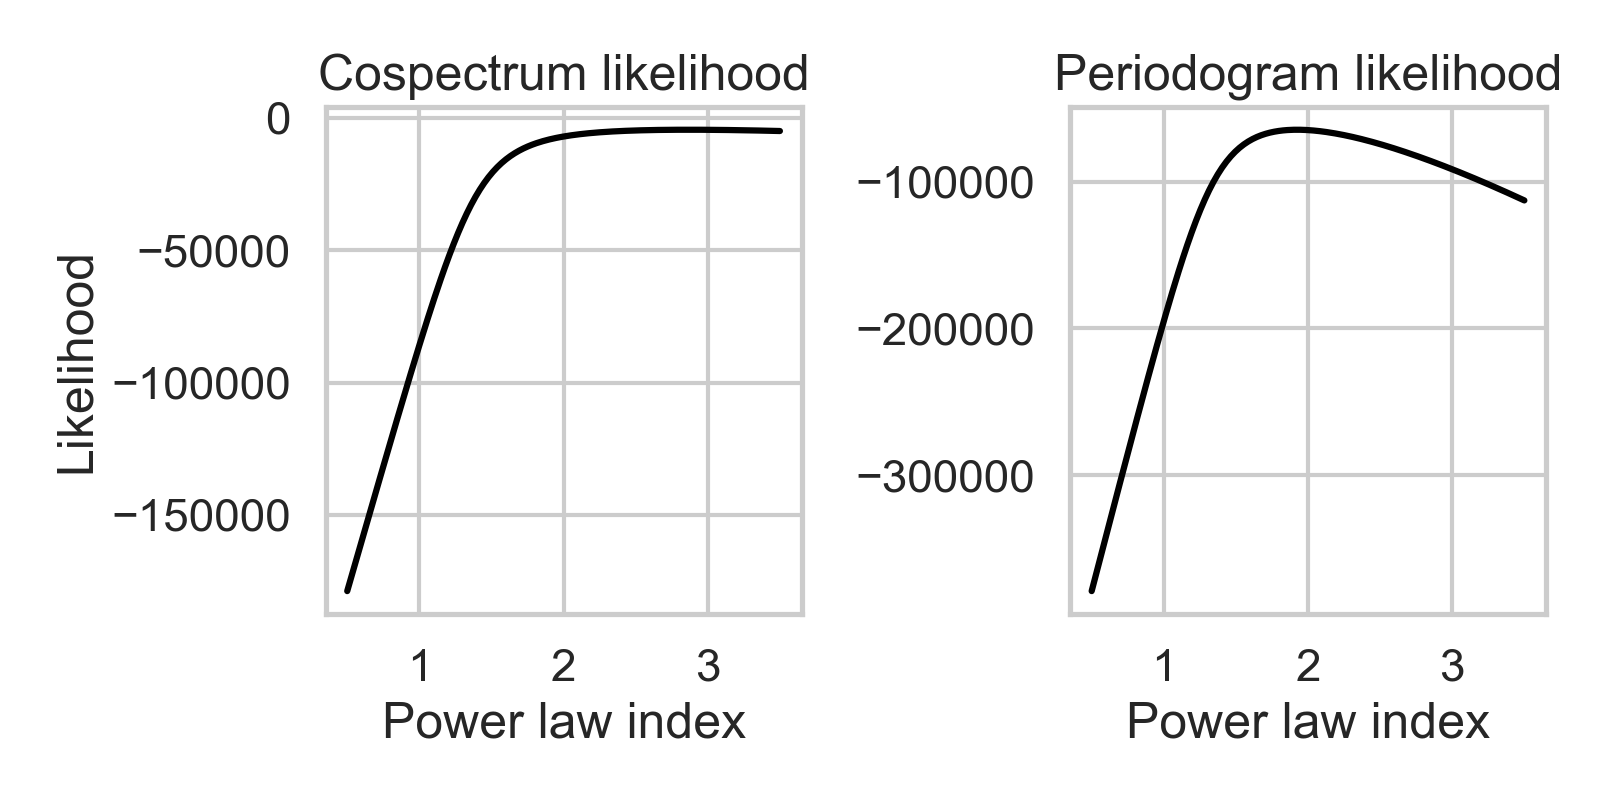

In [702]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.plot(pars_all[:,1], llike_avg_all, color="black")
ax1.set_xlabel("Power law index")
ax1.set_ylabel("Likelihood")
ax1.set_title("Cospectrum likelihood")

ax2.plot(pars_ps_all[:,1], llike_aps_all, color="black")
ax2.set_xlabel("Power law index")
ax2.set_title("Periodogram likelihood")
plt.tight_layout()

**TODO**: Check on result above: why is the cospectrum likelihood not more peaked?

In [ ]:
#fourier1_all_rn = np.array(fourier1_all_rn)
#lc1_counts_all_rn = np.array(lc1_counts_all_rn)

#avg_ps1_rn = AveragedPowerspectrum(lc1_all_rn, segment_size=lc1_all_rn[0].tseg, norm="leahy")

mrn = models.PowerLaw1D() + models.Const1D()
mrn.x_0_0.fixed=True

loglike_rn = PSDLogLikelihood(avg_ps1_rn.freq, avg_ps1_rn.power, model=mrn, m=avg_ps1_rn.m)

parest_rn = PSDParEst(avg_ps1_rn, max_post=False)
res_rn = parest.fit(loglike_rn, [3.24e4, 2, 2])

mrn.amplitude_0 = res_rn.p_opt[0]
mrn.alpha_0 = res_rn.p_opt[1]
mrn.amplitude_1 = res_rn.p_opt[2]

mps_rn = mrn(avg_ps1_rn.freq)

## Implementing the KLT Version of the Probability Density

Let's implement the KLT version from [Baudiquez et al (2020)]() and see whether that matches the distributions better. I've also tried before to implement their other distribution and failed, but I think given their insistence on variance-gamma distributions, they've just picked a really complicated way to reproduce the Gaunt results.

## Implementing the Baudiquez Likelihood

First, let us implement the direct probability distribution from [Baudiquez et al (2020)]() and see whether that matches the distributions better. For 1 degree of freedom (i.e. just the product of Fourier amplitudes, I think), we can use equation 12 from that paper:

In [283]:
def vg_distribution(x, var_signal, var_noise, m):
    """
    Variance-gamma distribution for the cospectrum, assuming that
    the noise in both detectors is equal. Note: the VG distribution 
    assumes independence in the variables added based on the degrees of 
    freedom, but our variables aren't independent.
    
    Parameters
    -----------
    
    x : numpy.ndarray
        The support over which to compute the distribution
        
    var_signal : float
        The signal variance
        
    var_noise : float
        The noise variance
        
    m : [1/2 or int]
        The number of averaged cospectra
    
    Returns
    -------
    prob : numpy.ndarray
        An array with the probability density
    
    """
    # denominator for alpha and beta parameter
    denom1 = (var_noise * (2 * var_noise + var_signal))
    
    # alpha and beta parameters
    alpha = (var_noise + var_signal) / denom1
    beta = var_signal / denom1
    
    # the gamma variable
    gamma = np.sqrt((alpha ** 2.) - (beta ** 2.))
    
    # the gamma function for the denominator
    gamma_fn = scipy.special.gamma(m)
    
    # the order of the Bessel function, also exponent of several terms
    order =  m - 0.5

    # calculate the hyperbolic bessel function of the second kind
    bessel = scipy.special.kv(order, alpha * np.abs(x))
    
    # compute the exponential term
    expon = np.exp(beta * x)
    
    # put together nominator
    nom_total = (gamma ** (2. * m)) * (np.abs(x)**order) * bessel
    
    # put together denominator
    denom_total = np.sqrt(np.pi) * gamma_fn * ((2*alpha)**order)
    
    # entire expression for the  probability
    prob = (nom_total / denom_total) * expon
    
    return prob
    

In [284]:
idx = 1400

min_val = np.min(fourier_squared_test[:,idx])
max_val = np.max(fourier_squared_test[:,idx])

print("minimum value for index %i is " + str(min_val))
print("maximum value for index %i is " + str(max_val))

x = np.linspace(min_val, max_val, 5000)

minimum value for index %i is -4098614.1832000064
maximum value for index %i is 4016823.8020383124


In [285]:
model_var_rn = (mps_rn[:1500])*np.mean(lc1_counts_all)/4
noise_var = 2. * np.mean(lc1_counts_all)/4.

In [286]:
model_var_rn[1400]

4371.461462196156

In [287]:
prob_test = vg_distribution(x, model_var_rn[idx], noise_var, 0.5)
prob_bessel_corr = bessel_probability_corr(x, model_std[idx],model_std[idx], corr_coeff_real[idx])

<IPython.core.display.Javascript object>


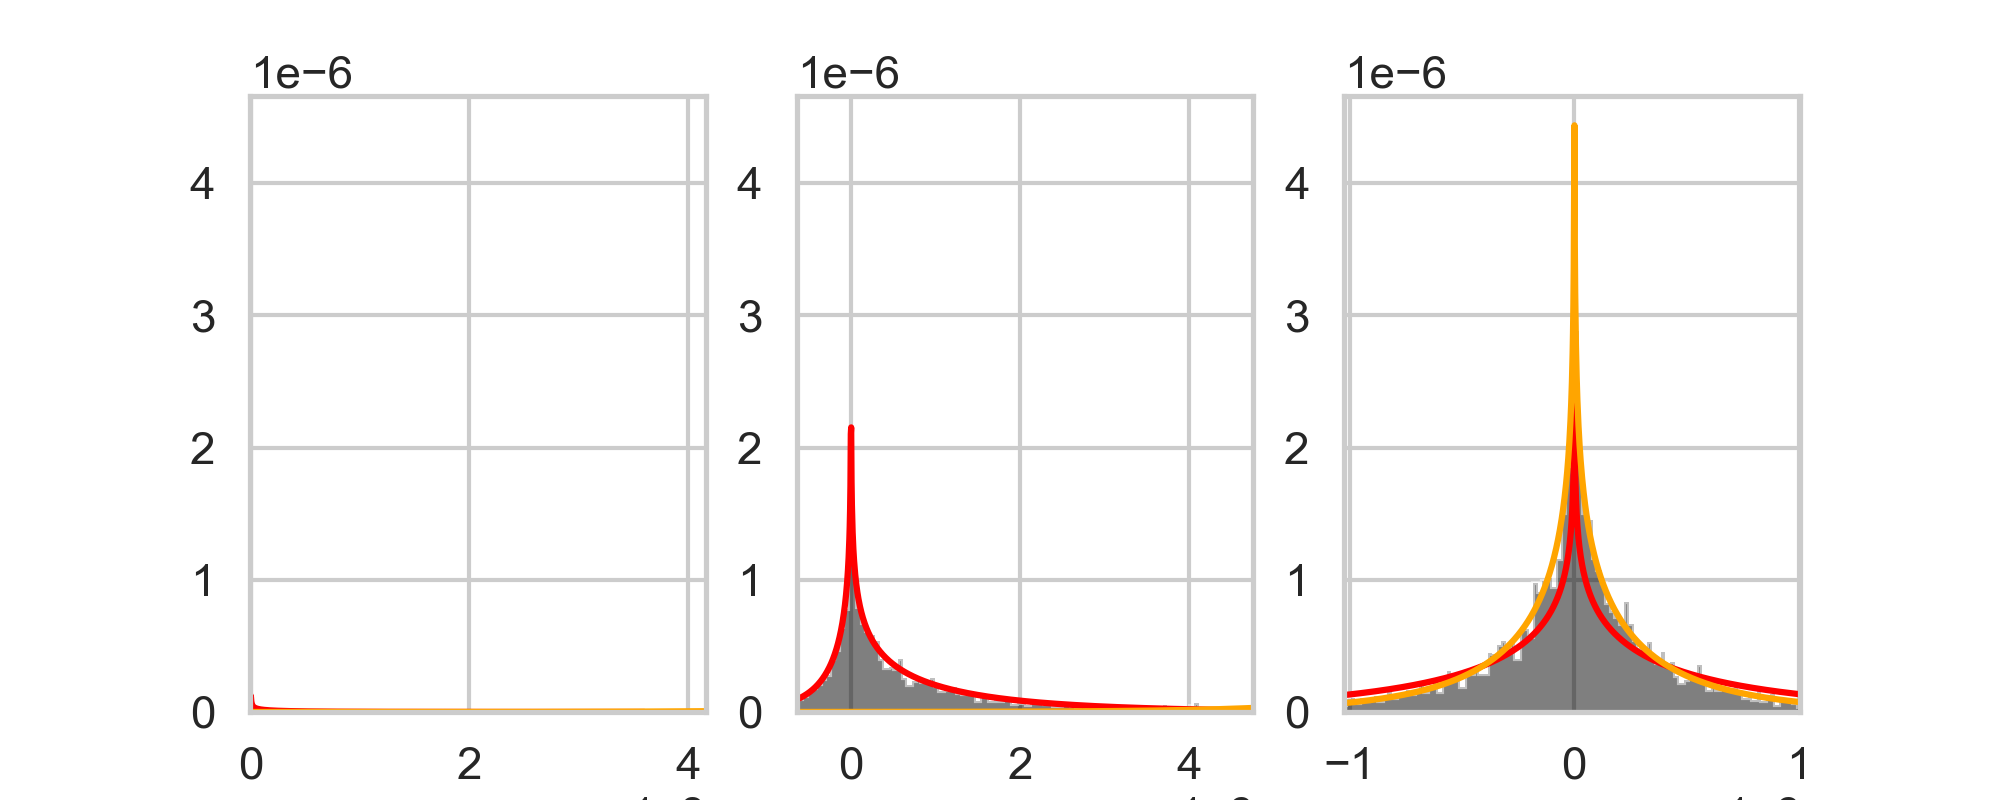

minimum value for index %i is -2416670.148922504
maximum value for index %i is 1664367106.2345088
minimum value for index %i is -2550835.804185355
maximum value for index %i is 19006246.472415466
minimum value for index %i is -4098614.1832000064
maximum value for index %i is 4016823.8020383124


In [333]:
npanel = 3
idx_all = [10, 100, 1400]

fig, axes = plt.subplots(1, npanel, figsize=(10,4))

for i in range(npanel):
    idx = idx_all[i]
    
    # get the minimum and maximum value from the 
    # array of experimental squared fourier frequencies
    # for plotting
    min_val = np.min(fourier_squared_test[:,idx])
    max_val = np.max(fourier_squared_test[:,idx])

    print("minimum value for index %i is " + str(min_val))
    print("maximum value for index %i is " + str(max_val))

    # calculate an array of x-values based on these values
    x = np.linspace(min_val, max_val, 5000)
    
    # calculate probability density function
    prob_test = vg_distribution(x, model_var_rn[idx], noise_var, 0.5)
    #prob_bessel = bessel_probability_corr(x, model_std[idx],model_std[idx], corr_coeff_real[idx])

    # plot histogram and theoretical expectation for PDF
    axes[i].hist(fourier_squared_test[:,idx], bins=200, histtype="stepfilled", alpha=0.5, 
            color="black", density=True, range=[min_val/2, max_val/2])
    axes[i].plot(x, prob_test, color="red")
    axes[i].plot(x, prob_bessel, color="orange")
    axes[i].set_xlim(min_val/4.0, max_val/4.)

Interesting. The Bessel correlation probability works for this case, but the Baudiquez expression does not. 

Let's investigate why. I think it must be related to the terms in gamma.

In [252]:
idx = 1400

# signal and noise variance
vs = model_var_rn[idx]
vn = noise_var

In [253]:
alpha = (vn + vs) / (vn * (2 * vn + vs))

beta = vs / (vn * (2 * vn + vs))

gamma = np.sqrt(alpha **2. - beta ** 2.)

What's the corresponding value from the distribution?

In [268]:
bessel_fac = 1./(model_std[idx] * model_std[idx] * (1-corr_coeff_real[idx]**2.))

In [269]:
bessel_fac

1.9831008436230392e-06

In [270]:
gamma

1.0042961651521026e-06

### Reproducing Figure 2 from the paper

So those don't agree. Can we reproduce the results from the paper itself?

I noted that they specifically used a version that doesn't contain any signal. So let's try to reproduce that.

First, the simulation step:

In [303]:
nsim = 10000000

var_c = 0.0
var_a = 2.0
var_b = 0.5
m = 2 

# drawing all the random varaibles
a_all = np.random.normal(0, var_a, size=(2*m, nsim))
b_all = np.random.normal(0, var_b, size=(2*m, nsim))
c_all = np.random.normal(0, var_c, size=(2*m, nsim))

In [304]:
z_all = (a_all + c_all) * (b_all + c_all)

In [308]:
z_sum = np.sum(z_all, axis=0)

<IPython.core.display.Javascript object>


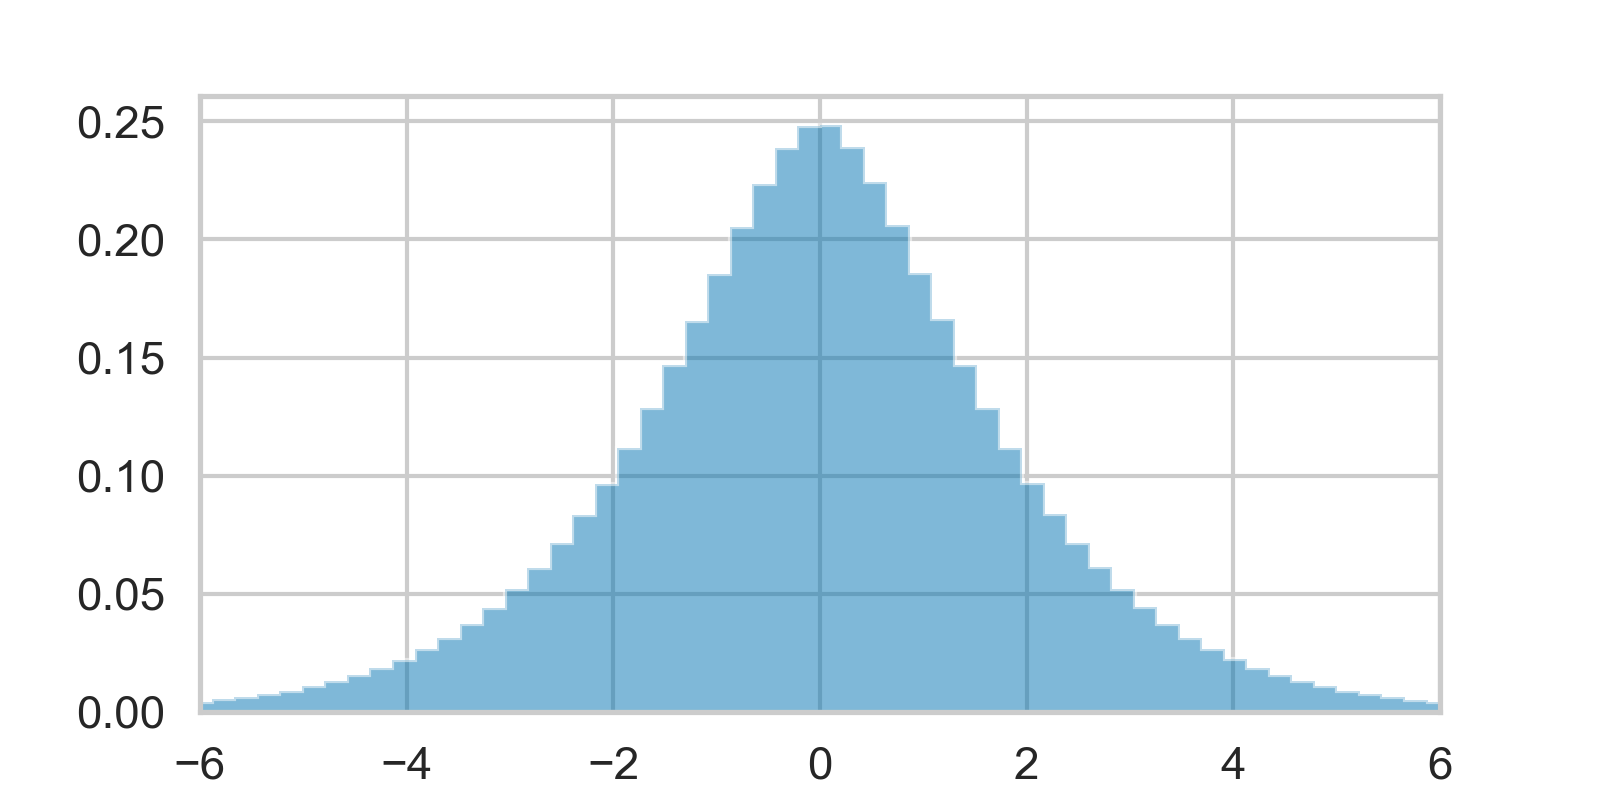

(-6.0, 6.0)

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.hist(z_sum, bins=200, histtype="stepfilled", alpha=0.5, density=True)
ax.set_xlim(-6, 6)

Now let's compute the distribution:

In [312]:
v1sq = var_a + var_b / 4 + var_c
v2sq = var_a + var_b

# denominator vor v2n term
v2n_denom = var_a + var_b + 4 * var_c

# nominator terms for all three components ov V2n
v2n_term1 = np.sqrt(var_a) * (var_b + 2*var_c) / v2n_denom
v2n_term2 = - np.sqrt(var_b) * (var_a + 2 * var_c) / v2n_denom
v2n_term3 = - np.sqrt(var_c) * (var_a - var_b) / v2n_denom

# expectation value for V1
e_v1 = (var_a / 4.) + (var_b / 4.) + var_c

# coeefficient ac1
k_ac1 = ((var_a / 2.) + var_c) / e_v1

# coefficient bc1
k_bc1 = ((var_b / 2.) + var_c) / e_v1

# expectation for V2n
e_v2n = (v2n_term1 ** 2.) + (v2n_term2 ** 2.) + (v2n_term3 ** 2.)

# v2n coefficients
k_ac2n = ((np.sqrt(var_a) * v2n_term1) - (np.sqrt(var_c) * v2n_term3)) / e_v2n
k_bc2n = (-(np.sqrt(var_b) * v2n_term2) - (np.sqrt(var_c) * v2n_term3)) / e_v2n


In [313]:
# newly rotated coefficients
k11 = k_ac1 * k_bc1 * (e_v1 ** 2.)
k22 = -k_ac2n * k_bc2n * (e_v2n ** 2.)
k12 = k_ac1 * k_bc2n * e_v1 * e_v2n + k_ac2n * k_bc1 * e_v1 * e_v2n

Now we can calculate the eigenvalues of the matrix:

In [315]:
delta = (k11 + k22)**2. + k12 ** 2.

l1 = 0.5 * (k11 - k22 - np.sqrt(delta))
l2 = 0.5 * (k11 - k22 + np.sqrt(delta))

l1sq = l1 ** 2.
l2sq = l2 ** 2.

Now we can calculate alpha and beta:

In [318]:
alpha = (l1sq + l2sq) / (4. * l1sq * l2sq)
beta = (l1sq - l2sq) / (4. * l1sq * l2sq)

m = 1

Now we can put together the distribution:

In [381]:
x = np.linspace(-6, 6, 1000)

In [382]:
gamma = np.sqrt(alpha ** 2. - beta ** 2.)
gamma_fn = scipy.special.gamma(m)

order = m - 0.5
abs_term = np.abs(x) ** order
bessel_term = scipy.special.kv(order, alpha * np.abs(x))
exp_term = np.exp(beta * x)

nom_total = (gamma ** (2.*m)) * abs_term * bessel_term
denom_total = np.sqrt(np.pi) * gamma_fn * (2. * alpha)**order

prob_test = nom_total * exp_term / denom_total

<IPython.core.display.Javascript object>


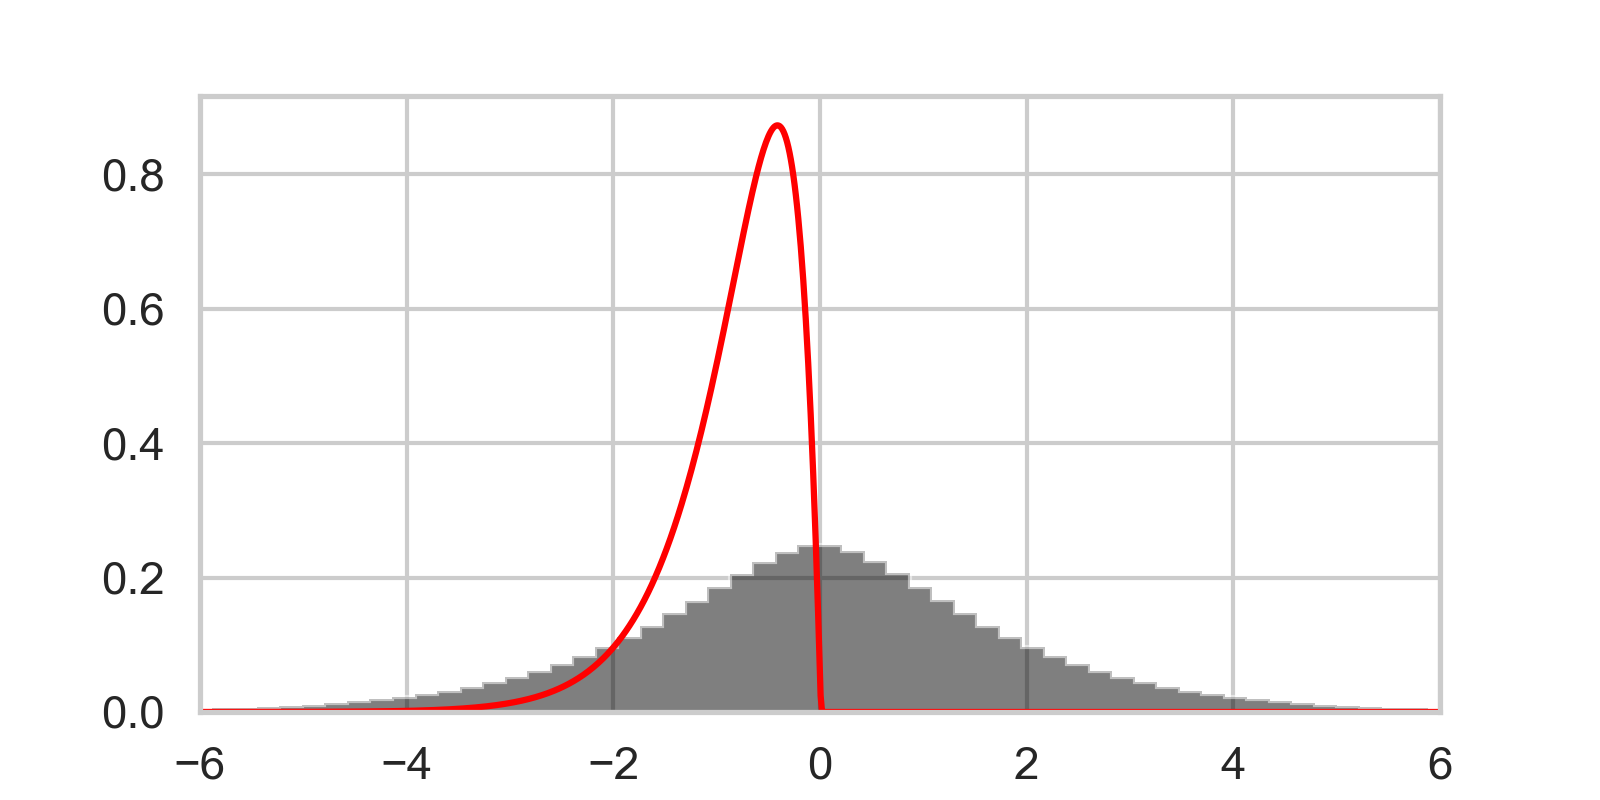

(-6.0, 6.0)

In [384]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.hist(z_sum, bins=200, histtype="stepfilled", alpha=0.5, density=True, color="black")
ax.plot(x, prob_test, color="red")
ax.set_xlim(-6, 6)

In [322]:
kappa = ((alpha ** 2.) - (beta ** 2.)) / (2. * alpha)
gamma = scipy.special.gamma(m-1.)

In [355]:
exponent = -alpha * np.abs(x) + (beta+5) * x

In [356]:
alpha

105.23456790123481

In [357]:
beta

-102.86149484071176

In [351]:
exp_factor = np.exp(-alpha * np.abs(x) + (beta+5) * x)

In [352]:
prob_paper = (kappa / gamma) * exp_factor

<IPython.core.display.Javascript object>


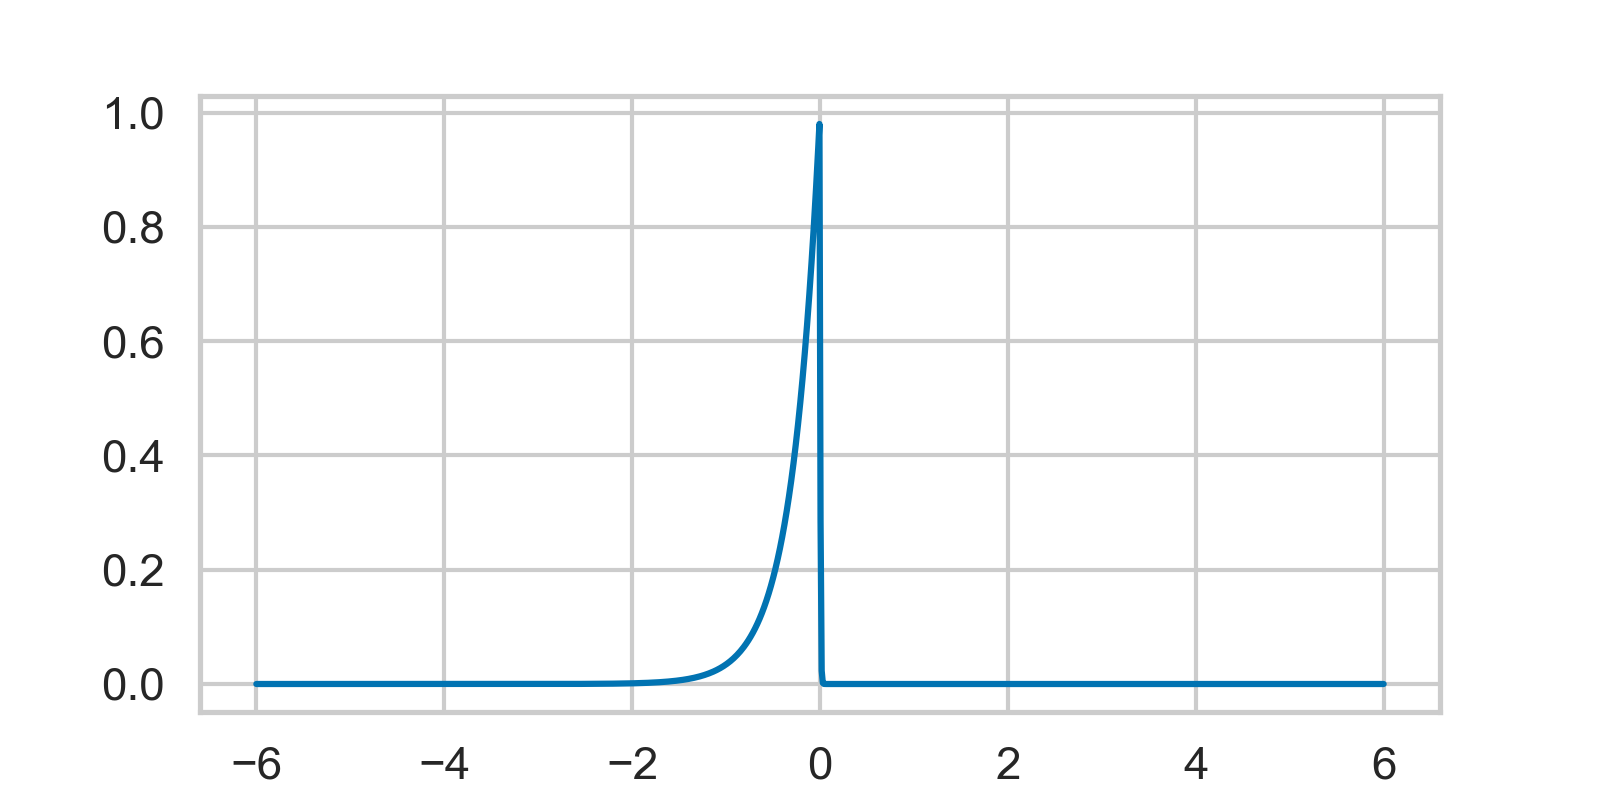

In [379]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

#ax.plot(x, -alpha * np.abs(x))
#ax.plot(x, beta * x)
ax.plot(x, np.exp(-(alpha+1) * np.abs(x) + (beta) * x))



<IPython.core.display.Javascript object>


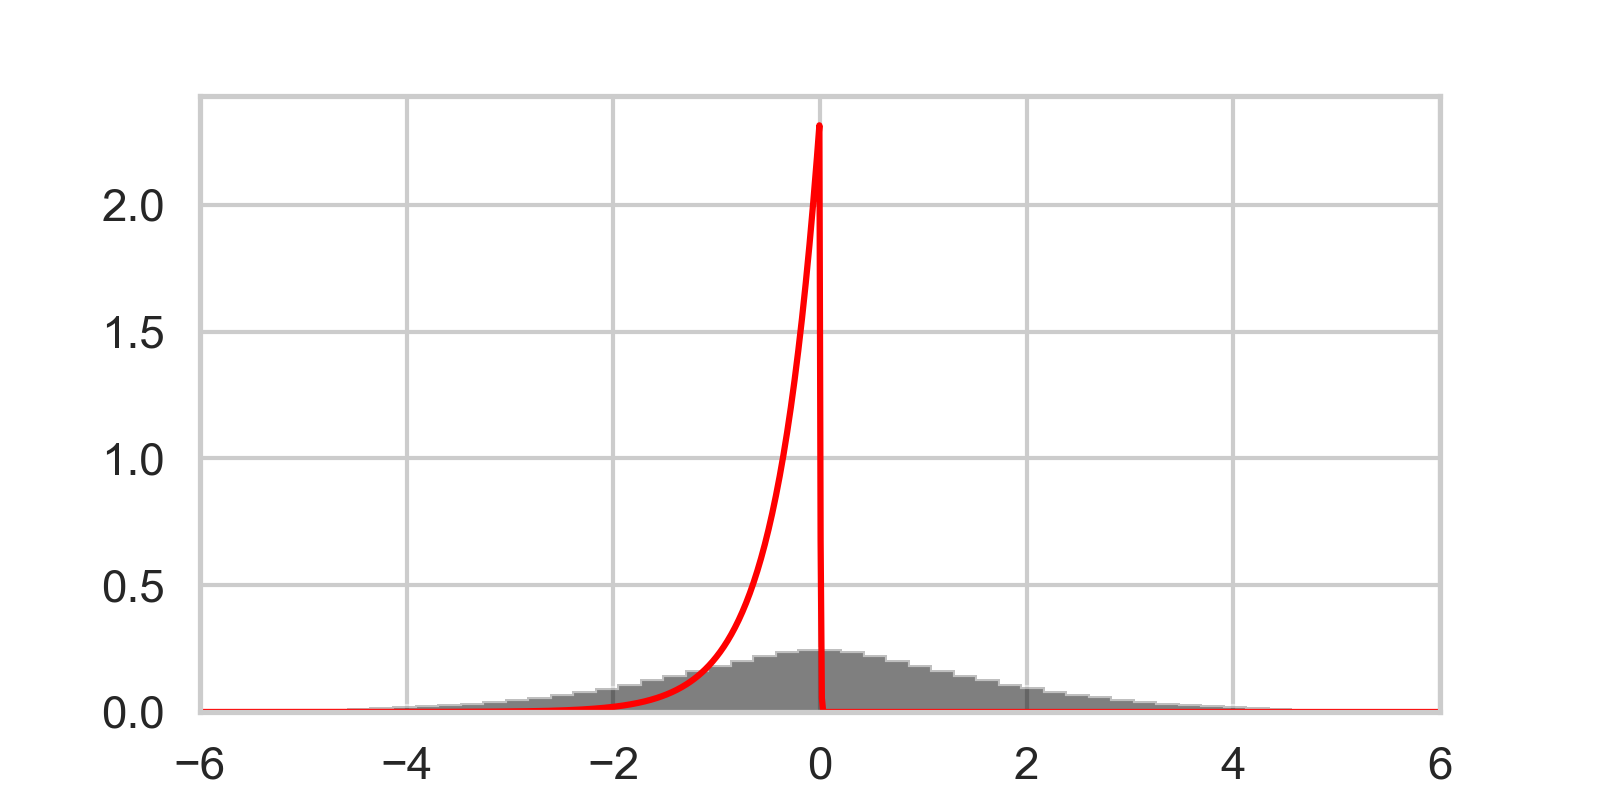

(-6.0, 6.0)

In [345]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.hist(z_sum, bins=200, histtype="stepfilled", alpha=0.5, density=True, color="black")
ax.plot(x, prob_paper, color="red")
ax.set_xlim(-6, 6)